# **IMPORTS**

In [2]:
import numpy as np
import pandas as pd
from zoneinfo import ZoneInfo
import nfl_data_py as nfl
import requests
from tqdm import tqdm
from collections import defaultdict
from time import sleep
import os
import json
import time
import numpy as np
import datetime
from pathlib import Path

# **PULL GAME LIST AND ATTACH WEATHER/STADIUM DATA**

In [3]:
# -------------------------
# CONFIG
# -------------------------
TZ = ZoneInfo("America/New_York")
SEASONS = list(range(2000, 2026))

# -------------------------
# TEAM CODE FIX
# -------------------------
TEAM_FIX = {
    "OAK": "LVR",   # Raiders
    "LV":  "LVR",
    "SD":  "LAC",   # Chargers
    "STL": "LAR",   # Rams
    "LA":  "LAR",   # Rams
    "WSH": "WAS",   # Commanders
}
def fix_team_codes(df, cols=["home_team","away_team"]):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].replace(TEAM_FIX)
    return df

# -------------------------
# TIMEZONE CONVERSION
# -------------------------
def to_et(series: pd.Series) -> pd.Series:
    s = pd.to_datetime(series, errors="coerce")
    tz = getattr(s.dt, "tz", None)
    return s.dt.tz_localize(TZ, nonexistent="NaT", ambiguous="NaT") if tz is None else s.dt.tz_convert(TZ)

# -------------------------
# FETCH SCHEDULE + CLEAN
# -------------------------
sched_raw = nfl.import_schedules(SEASONS).copy()
sched_raw = fix_team_codes(sched_raw, ["home_team","away_team"])

if "kickoff_et" in sched_raw.columns and sched_raw["kickoff_et"].notna().any():
    sched_raw["kickoff_et"] = to_et(sched_raw["kickoff_et"])
else:
    day = sched_raw.get("gameday")
    time_ = sched_raw.get("gametime")
    combo = (day.fillna("").astype(str) + " " + time_.fillna("").astype(str)) if (day is not None and time_ is not None) else (day if day is not None else pd.Series(index=sched_raw.index, dtype=object))
    sched_raw["kickoff_et"] = to_et(combo)

sched_raw["game_date"] = pd.to_datetime(sched_raw.get("gameday"), errors="coerce")
mask = sched_raw["game_date"].isna()
sched_raw.loc[mask, "game_date"] = sched_raw.loc[mask, "kickoff_et"].dt.date

sched_raw["season"] = pd.to_numeric(sched_raw["season"], errors="coerce").astype("Int64")
sched_raw["week"] = sched_raw["week"].astype(str)

if "game_type" in sched_raw.columns:
    sched_raw["game_type"] = sched_raw["game_type"].astype(str).str.upper()
else:
    sched_raw["game_type"] = pd.NA

sched_raw["season_phase"] = sched_raw["game_type"].map({
    "PRE": "Preseason",
    "REG": "Regular",
    "WC": "Postseason",
    "DIV": "Postseason",
    "CON": "Postseason",
    "SB": "Postseason"
})

for c in ["home_score", "away_score", "stadium"]:
    if c not in sched_raw.columns:
        sched_raw[c] = pd.NA

if sched_raw["stadium"].isna().all() and "stadium_name" in sched_raw.columns:
    sched_raw["stadium"] = sched_raw["stadium_name"]

need_cols = ['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday',
       'gametime', 'away_team', 'away_score', 'home_team', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game',
       'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id',
       'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium', 'kickoff_et', 'game_date', 'season_phase']

missing = [c for c in need_cols if c not in sched_raw.columns]
if missing:
    raise RuntimeError(f"Schedule is missing required columns: {missing}")

sched = (
    sched_raw[need_cols]
    .dropna(subset=["game_id", "home_team", "away_team"])
    .loc[lambda df: df["kickoff_et"].notna()]
    .sort_values(["season", "game_type", "kickoff_et", "home_team"])
    .reset_index(drop=True)
)

# =====================
# ADD STADIUM METADATA (with fixed codes)
# =====================
stadium_metadata = pd.DataFrame([
    ("ARI","State Farm Stadium",33.5273,-112.2633,"Retractable","Grass",2006,2025),
    ("ATL","Georgia Dome",33.7575,-84.4008,"Dome","Turf",2000,2016),
    ("ATL","Mercedes-Benz Stadium",33.7555,-84.4009,"Retractable","Turf",2017,2025),
    ("BAL","M&T Bank Stadium",39.2779,-76.6227,"Open","Grass",2000,2025),
    ("BUF","Highmark Stadium",42.7738,-78.7875,"Open","Turf",2000,2025),
    ("CAR","Bank of America Stadium",35.2258,-80.8536,"Open","Grass",2000,2025),
    ("CHI","Soldier Field",41.8623,-87.6167,"Open","Grass",2003,2025),
    ("CIN","Paycor Stadium",39.0954,-84.5161,"Open","Turf",2000,2025),
    ("CLE","Cleveland Browns Stadium",41.5061,-81.6996,"Open","Grass",2000,2025),
    ("DAL","AT&T Stadium",32.7473,-97.0945,"Retractable","Turf",2009,2025),
    ("DEN","Empower Field",39.7439,-105.0201,"Open","Grass",2001,2025),
    ("DET","Pontiac Silverdome",42.6463,-83.2875,"Dome","Turf",2000,2001),
    ("DET","Ford Field",42.3391,-83.0456,"Dome","Turf",2002,2025),
    ("GB","Lambeau Field",44.5013,-88.0622,"Open","Grass",2000,2025),
    ("HOU","NRG Stadium",29.6847,-95.4107,"Retractable","Turf",2002,2025),
    ("IND","Lucas Oil Stadium",39.7601,-86.1639,"Retractable","Turf",2008,2025),
    ("JAX","EverBank Stadium",30.3239,-81.6372,"Open","Turf",2000,2025),
    ("KC","Arrowhead Stadium",39.0490,-94.4839,"Open","Grass",2000,2025),
    ("LVR","Allegiant Stadium",36.0909,-115.1830,"Dome","Grass",2020,2025),
    ("LAR","SoFi Stadium",33.9535,-118.3392,"Open","Turf",2020,2025),
    ("LAC","SoFi Stadium",33.9535,-118.3392,"Open","Turf",2020,2025),
    ("MIA","Hard Rock Stadium",25.9580,-80.2389,"Open","Grass",2000,2025),
    ("MIN","Metrodome",44.9737,-93.2581,"Dome","Turf",2000,2013),
    ("MIN","U.S. Bank Stadium",44.9740,-93.2596,"Dome","Turf",2016,2025),
    ("NE","Foxboro Stadium",42.0910,-71.2643,"Open","Grass",2000,2001),
    ("NE","Gillette Stadium",42.0909,-71.2643,"Open","Turf",2002,2025),
    ("NO","Caesars Superdome",29.9509,-90.0816,"Dome","Turf",2000,2025),
    ("NYG","MetLife Stadium",40.8135,-74.0744,"Open","Turf",2010,2025),
    ("NYJ","MetLife Stadium",40.8135,-74.0744,"Open","Turf",2010,2025),
    ("PHI","Lincoln Financial Field",39.9008,-75.1675,"Open","Grass",2003,2025),
    ("PIT","Acrisure Stadium",40.4468,-80.0158,"Open","Grass",2001,2025),
    ("SEA","Lumen Field",47.5952,-122.3316,"Open","Turf",2002,2025),
    ("SF","Levi's Stadium",37.4030,-121.9700,"Open","Grass",2014,2025),
    ("TB","Raymond James Stadium",27.9762,-82.5033,"Open","Grass",2000,2025),
    ("TEN","Nissan Stadium",36.1665,-86.7713,"Open","Grass",2000,2025),
    ("WAS","FedExField",38.9078,-76.8644,"Open","Grass",2000,2025),
], columns=["team","stadium","lat","lon","roof_type","surface","start_season","end_season"])

sched = sched.drop(columns=[c for c in sched.columns if any(sub in c for sub in ["stadium","lat","lon","roof_type","surface"])], errors="ignore")

sched = sched.merge(
    stadium_metadata.rename(columns={"team":"home_team"}),
    on="home_team",
    how="left",
    validate="many_to_many"
)

sched = sched[
    (sched["season"] >= sched["start_season"]) &
    (sched["season"] <= sched["end_season"])
].drop(columns=["start_season","end_season"])

# Final code fix after merge
sched = fix_team_codes(sched, ["home_team","away_team"])

In [4]:
print("[CHECK] Home teams unique:", sched["home_team"].nunique())
print(sorted(sched["home_team"].unique()))

print("\n[CHECK] Away teams unique:", sched["away_team"].nunique())
print(sorted(sched["away_team"].unique()))

[CHECK] Home teams unique: 32
['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

[CHECK] Away teams unique: 32
['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']


## **ONLY RUN BEFORE GAME DAY**

In [5]:
VC_API_KEY = "D6EL2EK34R2CW82T6C8XZ3F74"
VC_UNIT_GROUP = "us"
VC_FIELDS = [
    "temp", "humidity", "windspeed", "windgust", "precip", "wx",
    "cloudcover", "visibility", "uvindex", "pressure", "dew",
    "conditions", "icon", "windchill", "heatindex"
]
VC_FIELDS = ["temp", "humidity", "windspeed","precip"]
VC_CACHE_DIR = Path(".weather_cache")
VC_CACHE_DIR.mkdir(parents=True, exist_ok=True)

def build_vc_url(lat, lon, dt):
    dt_str = pd.to_datetime(dt).strftime("%Y-%m-%dT%H:%M:%S")
    base = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"
    fields = ",".join(["datetime"] + VC_FIELDS)
    return (
        f"{base}/{lat},{lon}/{dt_str}"
        f"?key={VC_API_KEY}&unitGroup={VC_UNIT_GROUP}&include=hours&elements={fields}&contentType=json"
    )

def fetch_weather(lat, lon, kickoff_et):
    # Use UTC timestamp string for consistent cache key
    kickoff_dt = pd.to_datetime(kickoff_et)
    kickoff_utc_str = kickoff_dt.tz_convert("UTC").strftime('%Y%m%dT%H%M')
    key = f"{lat}_{lon}_{kickoff_utc_str}.json"
    cache_path = VC_CACHE_DIR / key

    # Load from cache if exists
    if cache_path.exists():
        try:
            return json.loads(cache_path.read_text())
        except Exception:
            cache_path.unlink(missing_ok=True)

    # Build URL for exact datetime
    url = build_vc_url(lat, lon, kickoff_dt)
    for _ in range(3):
        try:
            resp = requests.get(url, timeout=10)
            resp.raise_for_status()
            data = resp.json()

            # Save to cache
            cache_path.write_text(json.dumps(data))
            return data
        except Exception as e:
            print(f"[ERROR] Failed fetch for {lat},{lon} @ {kickoff_et} → {e}")
            sleep(0.05)

    return None
for i, row in sched.iterrows():
    lat, lon, kickoff_et = row["lat"], row["lon"], row["kickoff_et"]
    game_id = row.get("game_id", f"row{i}")
    result = fetch_weather(lat, lon, kickoff_et)
    if result:
        print(f"[OK] {game_id} → Cached")
    else:
        print(f"[FAIL] {game_id} → No data")

[OK] 2000_19_NO_MIN → Cached
[OK] 2000_19_BAL_TEN → Cached
[OK] 2000_01_SF_ATL → Cached
[OK] 2000_01_JAX_CLE → Cached
[OK] 2000_01_IND_KC → Cached
[OK] 2000_01_CHI_MIN → Cached
[OK] 2000_01_TB_NE → Cached
[OK] 2000_01_DET_NO → Cached
[OK] 2000_01_CAR_WAS → Cached
[OK] 2000_01_NYJ_GB → Cached
[OK] 2000_01_SEA_MIA → Cached
[OK] 2000_01_TEN_BUF → Cached
[OK] 2000_02_JAX_BAL → Cached
[OK] 2000_02_GB_BUF → Cached
[OK] 2000_02_CLE_CIN → Cached
[OK] 2000_02_MIA_MIN → Cached
[OK] 2000_02_CHI_TB → Cached
[OK] 2000_02_KC_TEN → Cached
[OK] 2000_02_WAS_DET → Cached
[OK] 2000_03_ATL_CAR → Cached
[OK] 2000_03_PIT_CLE → Cached
[OK] 2000_03_TB_DET → Cached
[OK] 2000_03_PHI_GB → Cached
[OK] 2000_03_CIN_JAX → Cached
[OK] 2000_03_SD_KC → Cached
[OK] 2000_03_MIN_NE → Cached
[OK] 2000_03_BAL_MIA → Cached
[OK] 2000_03_DAL_WAS → Cached
[OK] 2000_04_STL_ATL → Cached
[OK] 2000_04_CIN_BAL → Cached
[OK] 2000_04_NE_MIA → Cached
[OK] 2000_04_PHI_NO → Cached
[OK] 2000_04_NYJ_TB → Cached
[OK] 2000_05_IND_BUF → Cache

In [6]:
# === CONFIG ===
VC_FIELDS = [
    "temp", "humidity", "windspeed", "windgust", "precip", "wx",
    "cloudcover", "visibility", "uvindex", "pressure", "dew",
    "conditions", "icon", "windchill", "heatindex"
]
# === CONFIG ===
VC_FIELDS = ["temp", "humidity", "windspeed", "precip"]
VC_CACHE_DIR = Path(".weather_cache")

def _parse_hours_to_utc(data: dict) -> pd.DataFrame:
    """Return hourly dataframe with a UTC datetime column 'dt_utc'."""
    hours = pd.DataFrame(data["days"][0]["hours"]).copy()

    if "datetimeEpoch" in hours.columns:
        # Preferred: epoch timestamps
        # VC docs: datetimeEpoch is UNIX seconds. Treat as UTC to avoid DST ambiguity.
        hours["dt_utc"] = pd.to_datetime(hours["datetimeEpoch"], unit="s", utc=True)
    else:
        # Fallback: compose local datetimes then localize safely
        # Compose local naive datetimes like 'YYYY-MM-DDTHH:MM'
        local_dt = pd.to_datetime(
            data["days"][0]["datetime"] + "T" + hours["datetime"].astype(str),
            errors="coerce"
        )
        # Localize to VC-reported timezone, drop ambiguous/nonexistent
        tz = data.get("timezone", "UTC")
        # ambiguous can be 'infer', True/False, or 'NaT'. We choose 'NaT' to drop ambiguous 01:00.
        hours["dt_localized"] = (
            local_dt
              .dt.tz_localize(tz, ambiguous="NaT", nonexistent="shift_forward")
        )
        hours = hours.dropna(subset=["dt_localized"])
        hours["dt_utc"] = hours["dt_localized"].dt.tz_convert("UTC")

    return hours

# === Attach weather to all games ===
attached_games = 0
skipped_games = 0

for i, row in sched.iterrows():
    game_id = row.get("game_id", f"row{i}")
    try:
        lat, lon = row["lat"], row["lon"]
        kickoff_et = pd.to_datetime(row["kickoff_et"])
        if getattr(kickoff_et, "tzinfo", None) is None:
            # Ensure tz-aware ET if upstream ever gave naive
            kickoff_et = kickoff_et.tz_localize("America/New_York")
        kickoff_utc = kickoff_et.tz_convert("UTC")

        cache_key = f"{lat}_{lon}_{kickoff_utc.strftime('%Y%m%dT%H%M')}.json"
        cache_path = VC_CACHE_DIR / cache_key
        if not cache_path.exists():
            # Try looser key (hourly cache may not match exact minute)
            loose_key = f"{lat}_{lon}_{kickoff_utc.strftime('%Y%m%dT%H')}"
            matches = list(VC_CACHE_DIR.glob(f"{loose_key}*.json"))
            if matches:
                cache_path = matches[0]
            else:
                print(f"[SKIP] {game_id} – Cache missing")
                skipped_games += 1
                continue

        data = json.loads(cache_path.read_text())
        hourly_df = _parse_hours_to_utc(data)

        # Keep rows at or before kickoff
        pre = hourly_df.loc[hourly_df["dt_utc"] <= kickoff_utc]
        if pre.empty:
            print(f"[SKIP] {game_id} – No hourly weather before kickoff")
            skipped_games += 1
            continue

        latest = pre.iloc[-1]
        for field in VC_FIELDS:
            val = latest.get(field, pd.NA)
            if pd.notna(val):
                sched.at[i, f"weather_{field}"] = val

        attached_games += 1

    except Exception as e:
        print(f"[ERROR] {game_id} – {e}")
        skipped_games += 1

print(f"\nDone: Attached weather to {attached_games} games, skipped {skipped_games}.")

[ERROR] 2025_09_CHI_CIN – 'hours'
[ERROR] 2025_09_MIN_DET – 'hours'
[ERROR] 2025_09_CAR_GB – 'hours'
[ERROR] 2025_09_DEN_HOU – 'hours'
[ERROR] 2025_09_ATL_NE – 'hours'
[ERROR] 2025_09_SF_NYG – 'hours'
[ERROR] 2025_09_IND_PIT – 'hours'
[ERROR] 2025_09_LAC_TEN – 'hours'
[ERROR] 2025_09_NO_LA – 'hours'
[ERROR] 2025_09_JAX_LV – 'hours'
[ERROR] 2025_09_KC_BUF – 'hours'
[ERROR] 2025_09_SEA_WAS – 'hours'
[ERROR] 2025_09_ARI_DAL – 'hours'
[ERROR] 2025_10_LV_DEN – 'hours'
[ERROR] 2025_10_ATL_IND – 'hours'
[ERROR] 2025_10_NO_CAR – 'hours'
[ERROR] 2025_10_NYG_CHI – 'hours'
[ERROR] 2025_10_JAX_HOU – 'hours'
[ERROR] 2025_10_BUF_MIA – 'hours'
[ERROR] 2025_10_BAL_MIN – 'hours'
[ERROR] 2025_10_CLE_NYJ – 'hours'
[ERROR] 2025_10_NE_TB – 'hours'
[ERROR] 2025_10_ARI_SEA – 'hours'
[ERROR] 2025_10_LA_SF – 'hours'
[ERROR] 2025_10_DET_WAS – 'hours'
[ERROR] 2025_10_PIT_LAC – 'hours'
[ERROR] 2025_10_PHI_GB – 'hours'
[ERROR] 2025_11_NYJ_NE – 'hours'
[ERROR] 2025_11_WAS_MIA – 'hours'
[ERROR] 2025_11_CAR_ATL – 'ho

In [7]:
print("[CHECK] Columns in sched:")
print(list(sched.columns))

print("\n[CHECK] Home teams unique:", sched["home_team"].nunique())
print(sorted(sched["home_team"].unique()))

print("\n[CHECK] Away teams unique:", sched["away_team"].nunique())
print(sorted(sched["away_team"].unique()))

print("\n[CHECK] Total rows:", len(sched))

[CHECK] Columns in sched:
['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score', 'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'roof', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee', 'kickoff_et', 'game_date', 'season_phase', 'stadium', 'lat', 'lon', 'roof_type', 'surface', 'weather_temp', 'weather_humidity', 'weather_windspeed', 'weather_precip']

[CHECK] Home teams unique: 32
['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

[CHECK] Away teams u

# **TEAM/PLAER SPECIFIC DATA**

## **Step 1: Betting Odds**

In [8]:
# ========= PHASE 2 (patched & expanded): Sportsbook lines (closing, pre-kickoff) =========
print("[DEBUG] sched is", type(sched), "with shape:", getattr(sched, 'shape', None))


def _implied_prob_from_ml(ml_series: pd.Series) -> pd.Series:
    """Convert moneyline odds to implied probability (vig not removed)."""
    ml = pd.to_numeric(ml_series, errors="coerce")
    out = pd.Series(np.nan, index=ml.index)
    pos = ml > 0
    out.loc[pos] = 100 / (ml.loc[pos] + 100)
    out.loc[~pos] = (-ml.loc[~pos]) / ((-ml.loc[~pos]) + 100)
    return out


def attach_pre_kick_lines(sched: pd.DataFrame) -> pd.DataFrame:
    """
    Attach *closing* pre-kickoff market columns using schedules as canonical source.
    Explicitly filters to the last line snapshot at or before kickoff to avoid leakage.
    """
    try:
        games_raw = nfl.import_schedules(SEASONS).copy()
    except Exception as e:
        print(f"[PHASE 2] WARN: could not re-load schedules for market fields ({e}).")
        return sched  # fallback to original sched

    # --- Normalize column names ---
    rename_map = {
        "over_under_line": "total_line",
        "total_close": "total_line",
        "total": "total_line",
        "spread_close": "spread_line",
        "spread": "spread_line",
        "home_ml": "home_moneyline",
        "away_ml": "away_moneyline",
    }
    games_raw = games_raw.rename(columns={k: v for k, v in rename_map.items() if k in games_raw.columns})

    wanted = ["game_id", "spread_line", "total_line", "home_moneyline", "away_moneyline", "line_time"]
    have = [c for c in wanted if c in games_raw.columns]

    if "game_id" not in have:
        print("[PHASE 2] No usable market columns found. Continuing without lines.")
        return sched

    lines = games_raw[have].dropna(subset=["game_id"]).copy()

    # --- Ensure datetime for line_time if present ---
    if "line_time" in lines.columns:
        sched_kick = sched[["game_id", "kickoff_et"]].copy()
        sched_kick["kickoff_utc"] = sched_kick["kickoff_et"].dt.tz_convert("UTC")
        lines = lines.merge(sched_kick, on="game_id", how="left")

        # Keep only line snapshots <= kickoff
        lines = lines[lines["line_time"] <= lines["kickoff_utc"]]

        # For each game_id, take the last line before kickoff
        lines = (
            lines.sort_values(["game_id", "line_time"])
            .groupby("game_id")
            .tail(1)
        )

        lines.drop(columns=["line_time", "kickoff_utc"], inplace=True)

    # --- Compute Implied Probabilities ---
    if {"home_moneyline", "away_moneyline"}.issubset(lines.columns):
        lines["home_implied_win_prob"] = _implied_prob_from_ml(lines["home_moneyline"])
        lines["away_implied_win_prob"] = _implied_prob_from_ml(lines["away_moneyline"])
        lines["market_edge_prob"] = lines["home_implied_win_prob"] - lines["away_implied_win_prob"]

    # --- Merge back into schedule ---
    sched2 = sched.merge(lines, on="game_id", how="left")
    sched2 = sched2.loc[:, ~sched2.columns.duplicated()].copy()

    # --- Resolve duplicate _x/_y columns ---
    for base in [
        "spread_line", "spread_favorite", "home_implied_win_prob", "away_implied_win_prob", "market_edge_prob",
        "home_moneyline", "away_moneyline", "total_line"
    ]:
        xcol, ycol = f"{base}_x", f"{base}_y"
        if xcol in sched2.columns and ycol in sched2.columns:
            # Use the right-side (_y, lines) values preferentially
            sched2[base] = sched2[ycol].combine_first(sched2[xcol])
            sched2.drop(columns=[xcol, ycol], inplace=True)


    # --- Ensure spread_favorite exists ---
    if "spread_favorite" not in sched2.columns and "spread_line" in sched2.columns:
        sched2["spread_favorite"] = np.where(
            sched2["spread_line"] < 0, sched2["home_team"], sched2["away_team"]
        )

    # --- Normalize spread to home perspective ---
    if {"spread_line", "spread_favorite", "home_team"}.issubset(sched2.columns):
        sched2["home_spread_line"] = np.where(
            sched2["spread_favorite"] == sched2["home_team"],
            sched2["spread_line"],   # home is favorite
            -sched2["spread_line"]   # away is favorite
        )
    elif "spread_line" in sched2.columns:
        sched2["home_spread_line"] = sched2["spread_line"]

    # --- Clean numeric line values ---
    for col in ["spread_line", "total_line", "home_moneyline", "away_moneyline"]:
        if col in sched2.columns:
            sched2[col] = pd.to_numeric(sched2[col], errors="coerce")

    # --- Derived features (unchanged) ---
    if "spread_line" in sched2.columns:
        sched2["spread_abs"] = sched2["spread_line"].abs()
        sched2["fav_is_home"] = (sched2["spread_line"] < 0).astype(int)
        sched2["pickem_game"] = (sched2["spread_abs"] < 0.5).astype(int)

    if {"total_line", "spread_line"}.issubset(sched2.columns):
        sched2["implied_home_score"] = (sched2["total_line"] / 2) - (sched2["spread_line"] / 2)
        sched2["implied_away_score"] = (sched2["total_line"] / 2) + (sched2["spread_line"] / 2)

    if {"home_implied_win_prob", "away_implied_win_prob"}.issubset(sched2.columns):
        sched2["avg_implied_prob"] = (sched2["home_implied_win_prob"] + sched2["away_implied_win_prob"]) / 2
        sched2["implied_odds_ratio"] = sched2["home_implied_win_prob"] / sched2["away_implied_win_prob"]
        sched2["heavy_favorite"] = (
            sched2[["home_implied_win_prob", "away_implied_win_prob"]].max(axis=1) > 0.70
        ).astype(int)
        sched2["close_game"] = (
            sched2[["home_implied_win_prob", "away_implied_win_prob"]].max(axis=1) < 0.55
        ).astype(int)

    if {"home_moneyline", "away_moneyline"}.issubset(sched2.columns):
        sched2["ml_diff"] = sched2["home_moneyline"] - sched2["away_moneyline"]
        sched2["ml_avg"] = (sched2["home_moneyline"] + sched2["away_moneyline"]) / 2

    added = [c for c in sched2.columns if c not in sched.columns and c != "game_id"]
    print(f"[PHASE 2] Added market/derived columns (leakage-safe): {', '.join(added) if added else '(none)'}")
    return sched2


# --- Run Phase 2 Safely ---
sched2 = attach_pre_kick_lines(sched)
if sched2 is not None:
    sched = sched2
else:
    print("[PHASE 2] WARNING: attach_pre_kick_lines returned None. Skipping market enrichment.")

# --- Track what was added ---
mkt_cols = [c for c in [
    "provider","spread_line","spread_abs","spread_home_adv","fav_is_home","pickem_game",
    "total_line","implied_home_score","implied_away_score","implied_score_diff","high_total_game",
    "home_moneyline","away_moneyline","ml_diff","ml_avg",
    "home_implied_win_prob","away_implied_win_prob","avg_implied_prob","implied_odds_ratio",
    "market_edge_prob","heavy_favorite"
] if c in sched.columns]

[DEBUG] sched is <class 'pandas.core.frame.DataFrame'> with shape: (5932, 55)
[PHASE 2] Added market/derived columns (leakage-safe): home_implied_win_prob, away_implied_win_prob, market_edge_prob, spread_favorite, home_spread_line, spread_abs, fav_is_home, pickem_game, implied_home_score, implied_away_score, avg_implied_prob, implied_odds_ratio, heavy_favorite, close_game, ml_diff, ml_avg


In [9]:
print("[CHECK] Columns in sched:")
print(list(sched.columns))

print("\n[CHECK] Home teams unique:", sched["home_team"].nunique())
print(sorted(sched["home_team"].unique()))

print("\n[CHECK] Away teams unique:", sched["away_team"].nunique())
print(sorted(sched["away_team"].unique()))

print("\n[CHECK] Total rows:", len(sched))

[CHECK] Columns in sched:
['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score', 'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest', 'away_spread_odds', 'home_spread_odds', 'under_odds', 'over_odds', 'div_game', 'roof', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee', 'kickoff_et', 'game_date', 'season_phase', 'stadium', 'lat', 'lon', 'roof_type', 'surface', 'weather_temp', 'weather_humidity', 'weather_windspeed', 'weather_precip', 'home_implied_win_prob', 'away_implied_win_prob', 'market_edge_prob', 'spread_line', 'home_moneyline', 'away_moneyline', 'total_line', 'spread_favorite', 'home_spread_line', 'spread_abs', 'fav_is_home', 'pickem_game', 'implied_home_score', 'implied_away_score', 'avg_implied_prob', 'implied_odds_ratio', 'heavy_favorite', 'close_game', 

## **Step 2: PLAY BY PLAY AGG**

### **Download PBP AND IMPORT**

In [10]:
# ==========================
# PHASE 3 — Team + PBP Features (leakage-safe)
# ==========================

_cols_needed = ['game_id', 'season', 'week', 'game_type', 'season_phase', 'home_team',
       'away_team', 'home_score', 'away_score', 'kickoff_et', 'game_date',
       'stadium', 'lat', 'lon', 'roof_type', 'surface', 'weather_temp',
       'weather_humidity', 'weather_windspeed', 'weather_precip',
       'spread_line', 'total_line', 'home_moneyline', 'away_moneyline',
       'home_implied_win_prob', 'away_implied_win_prob', 'market_edge_prob',
       'spread_favorite', 'home_spread_line', 'spread_abs', 'fav_is_home',
       'pickem_game', 'implied_home_score', 'implied_away_score',
       'avg_implied_prob', 'implied_odds_ratio', 'heavy_favorite',
       'close_game', 'ml_diff', 'ml_avg']

keep = [c for c in _cols_needed if c in sched.columns]
remainder = [c for c in sched.columns if c not in keep]
sched = sched[keep + remainder]

# Drop duplicate-named columns, keep the first occurrence
if not sched.columns.is_unique:
    sched = sched.loc[:, ~sched.columns.duplicated()].copy()

# ---------------------------------------------------
# 3.1 Team-game two-row index (home/away → team/opp)
# ---------------------------------------------------
home = (
    sched.rename(columns={"home_team": "team", "away_team": "opp"})
         .assign(is_home=1, is_away=0)
)
away = (
    sched.rename(columns={"away_team": "team", "home_team": "opp"})
         .assign(is_home=0, is_away=1)
)

home = home.loc[:, ~home.columns.duplicated()].copy()
away = away.loc[:, ~away.columns.duplicated()].copy()
_common = home.columns.intersection(away.columns)
team_games = pd.concat([home[_common], away[_common]], ignore_index=True, sort=False)
for c in ("team", "opp"):
    team_games[c] = team_games[c].astype(str)

print(f"[PHASE 3] team_games shape: {team_games.shape} (should be 2x sched rows)")
print(team_games.head(4)[["game_id","team","opp","is_home","is_away"]])

def _downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    fcols = df.select_dtypes(include=["float64"]).columns
    for c in fcols:
        df[c] = pd.to_numeric(df[c], downcast="float")
    icols = df.select_dtypes(include=["int64","int32","int16","int8",
                                      "uint64","uint32","uint16","uint8"]).columns
    for c in icols:
        df[c] = pd.to_numeric(df[c], downcast="integer")
    return df

def import_pbp_safely(SEASONS):
    frames = []
    for yr in SEASONS:
        try:
            tmp = nfl.import_pbp_data([yr]).copy()
            tmp["season"] = yr
            frames.append(_downcast_numeric(tmp))
            print(f"{yr} done.")
        except Exception as e:
            print(f"HTTP/Load issue for {yr}: {e}. Skipping this season.")
    if not frames:
        raise RuntimeError("[PHASE 3] No PBP data loaded for any season.")
    out = pd.concat(frames, ignore_index=True)
    return _downcast_numeric(out)

pbp = import_pbp_safely(SEASONS)



if ("posteam" in pbp.columns) and ("defteam" in pbp.columns):
    pbp = pbp[pbp["posteam"].notna() & pbp["defteam"].notna()].copy()
else:
    raise RuntimeError("[PHASE 3] PBP payload missing 'posteam' or 'defteam'")

# Basic coercions
pbp["epa"] = pd.to_numeric(pbp.get("epa", np.nan), errors="coerce")
pbp["success"] = pd.to_numeric(pbp.get("success", np.nan), errors="coerce")
pbp["yards_gained"] = pd.to_numeric(pbp.get("yards_gained", np.nan), errors="coerce")
pbp["touchdown"] = pd.to_numeric(pbp.get("touchdown", 0), errors="coerce").fillna(0).astype(int)

# Attach game_date for chronological order
if "game_id" in pbp.columns and "game_date" in sched.columns:
    pbp = pbp.merge(sched[["game_id","game_date"]], on="game_id", how="left")

# -------------------------------------
# 3.4 Drive-level summary (lagged)
# -------------------------------------
drive_summary = (
    pbp.groupby(["season","game_id","posteam","drive"])
       .agg(
           drive_plays=("play_id","count"),
           drive_yards=("yards_gained","sum"),
           drive_points=("touchdown","sum"),
       )
       .reset_index()
)

drive_summary_game = (
    drive_summary.groupby(["season","game_id","posteam"])
                 .agg(
                     avg_drive_len=("drive_plays","mean"),
                     avg_drive_yards=("drive_yards","mean"),
                     points_per_drive=("drive_points","mean"),
                 )
                 .reset_index()
                 .rename(columns={"posteam":"team"})
)

# --- Lag by game so only past values are used pregame ---
drive_summary_game = (
    drive_summary_game
    .sort_values(["team","season","game_id"])
    .assign(
        team_id=lambda df: df["team"],
        season_id=lambda df: df["season"],
        gid=lambda df: df["game_id"]
    )
    .groupby("team")
    .apply(lambda g: g.shift(1).assign(team=g["team"], season=g["season"], game_id=g["game_id"]))
    .reset_index(drop=True)
)

# 3.5 Opponent-Adjusted Metrics (lagged season-to-date)
season_team_means = (
    pbp.groupby(["season","posteam","game_id"])
       .agg(season_epa=("epa","mean"),
            season_success=("success","mean"))
       .reset_index()
       .rename(columns={"posteam":"team"})
)

# Rolling season-to-date excluding current game (keep game_id!)
season_team_means = (
    season_team_means
    .merge(sched[["game_id","game_date"]], on="game_id", how="left")
    .sort_values(["team","season","game_date"])
    .groupby(["team","season"], group_keys=False)
    .apply(lambda g: g.assign(
        season_epa=g["season_epa"].expanding().mean().shift(1),
        season_success=g["season_success"].expanding().mean().shift(1)
    ))
)
# -------------------------------------
# 3.6 Garbage Time Metrics (lagged)
# -------------------------------------
if "wp" in pbp.columns and "quarter" in pbp.columns:
    pbp["garbage_time"] = ((pbp["wp"] < 0.05) | (pbp["wp"] > 0.95)) & (pbp["quarter"] >= 4)
else:
    pbp["garbage_time"] = False

garbage_game = (
    pbp.groupby(["season","game_id","posteam"])
       .agg(
           garbage_play_rate=("garbage_time","mean"),
           garbage_epa=("epa", lambda x: x[pbp.loc[x.index,"garbage_time"]==1].mean()
                        if (pbp.loc[x.index,"garbage_time"]==1).any() else np.nan)
       )
       .reset_index()
       .rename(columns={"posteam":"team"})
)


garbage_game = (
    garbage_game
    .sort_values(["team","season","game_id"])
    .groupby("team")
    .shift(1)
    .assign(team=garbage_game["team"], 
            season=garbage_game["season"], 
            game_id=garbage_game["game_id"])
)


# -------------------------------------
# 3.7 Rest & Travel (pregame safe)
# -------------------------------------
team_games = team_games.sort_values(["team","game_date"])
team_games["prev_game_date"] = team_games.groupby("team")["game_date"].shift(1)
team_games["rest_days"] = (
    (pd.to_datetime(team_games["game_date"]) - pd.to_datetime(team_games["prev_game_date"]))
    .dt.days
)
team_games["short_rest"] = (team_games["rest_days"] < 6).astype(int)
team_games["bye_rest"]   = (team_games["rest_days"] >= 11).astype(int)
team_games["travel_dist"] = np.nan  # placeholder for haversine calc

if {"spread_line","total_line"}.issubset(sched.columns):
    sched["home_implied_pts"] = sched["total_line"]/2 - sched["spread_line"]/2
    sched["away_implied_pts"] = sched["total_line"]/2 + sched["spread_line"]/2
else:
    sched["home_implied_pts"] = np.nan
    sched["away_implied_pts"] = np.nan
    print("[PHASE 3] WARN: no total_line/spread_line found → implied points set to NaN")

# -------------------------------------
# 3.9 Merge Context Features (lagged only)
# -------------------------------------
team_features = (
    drive_summary_game
    .merge(garbage_game, on=["season","game_id","team"], how="left")
    .merge(season_team_means, on=["season","team","game_id"], how="left")
)

team_games = team_games.merge(team_features, on=["game_id","team"], how="left")

print(f"[PHASE 3] Finished leakage-safe features. team_games shape={team_games.shape}")

[PHASE 3] team_games shape: (11864, 73) (should be 2x sched rows)
           game_id team  opp  is_home  is_away
0   2000_19_NO_MIN  MIN   NO        1        0
1  2000_19_BAL_TEN  TEN  BAL        1        0
2   2000_01_SF_ATL  ATL   SF        1        0
3  2000_01_JAX_CLE  CLE  JAX        1        0
2000 done.
Downcasting floats.
2000 done.
2001 done.
Downcasting floats.
2001 done.
2002 done.
Downcasting floats.
2002 done.
2003 done.
Downcasting floats.
2003 done.
2004 done.
Downcasting floats.
2004 done.
2005 done.
Downcasting floats.
2005 done.
2006 done.
Downcasting floats.
2006 done.
2007 done.
Downcasting floats.
2007 done.
2008 done.
Downcasting floats.
2008 done.
2009 done.
Downcasting floats.
2009 done.
2010 done.
Downcasting floats.
2010 done.
2011 done.
Downcasting floats.
2011 done.
2012 done.
Downcasting floats.
2012 done.
2013 done.
Downcasting floats.
2013 done.
2014 done.
Downcasting floats.
2014 done.
2015 done.
Downcasting floats.
2015 done.
2016 done.
Downcasting floa

C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\4226200187.py:124: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda g: g.shift(1).assign(team=g["team"], season=g["season"], game_id=g["game_id"]))


[PHASE 3] Finished leakage-safe features. team_games shape=(11864, 90)


C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\4226200187.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sched["home_implied_pts"] = sched["total_line"]/2 - sched["spread_line"]/2
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\4226200187.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sched["away_implied_pts"] = sched["total_line"]/2 + sched["spread_line"]/2


In [11]:
# --- Split team_games into home and away subsets ---
tg_home = (
    team_games.loc[team_games["is_home"] == 1]
              .rename(columns=lambda c: f"home_{c}" if c not in ["game_id"] else c)
)
tg_away = (
    team_games.loc[team_games["is_away"] == 1]
              .rename(columns=lambda c: f"away_{c}" if c not in ["game_id"] else c)
)

# Drop duplicate indicator flags
tg_home = tg_home.drop(columns=[c for c in tg_home.columns if c.startswith("home_is_")], errors="ignore")
tg_away = tg_away.drop(columns=[c for c in tg_away.columns if c.startswith("away_is_")], errors="ignore")

# --- Merge home team_games ---
sched = sched.merge(tg_home, on="game_id", how="left", validate="many_to_one")

# --- Merge away team_games ---
sched = sched.merge(tg_away, on="game_id", how="left", validate="many_to_one")

# --- Resolve any lingering _x/_y columns ---
for col in sched.columns:
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Prefer _y (newly merged) values; fallback to _x
        sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)


print("[PHASE 3] sched enriched with team_games context:", sched.shape)

[PHASE 3] sched enriched with team_games context: (5932, 240)


C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\515432502.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\515432502.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\515432502.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

## **STEP 3: ADVANCED OFFENSE AND DEFENSE STATS**

In [12]:
# ==========================
# PHASE 4 — Offensive Features (lagged, leakage-safe)
# ==========================

# -- 4.1 Helper: per-team pace (median secs/play, clamp 0<dt<60) --
def team_game_pace_secs(sub):
    if "game_seconds_remaining" not in sub.columns:
        return np.nan
    s = pd.to_numeric(sub["game_seconds_remaining"], errors="coerce")
    s = s.dropna().sort_values(ascending=False)
    if len(s) < 2:
        return np.nan
    dt = -s.diff()
    dt = dt[(dt > 0) & (dt < 60)]
    return float(dt.median()) if len(dt) else np.nan


# -- 4.2 Offense: base per-game aggregation --
grp_off = pbp.groupby(["season","game_id","posteam"], observed=True)

game_off = grp_off.agg(
    plays=("play_id","count"),
    epa_sum=("epa","sum"),
    epa_per_play=("epa","mean"),
    success_rate=("success","mean"),
    pass_plays=("pass","sum"),
    rush_plays=("rush","sum"),
    yards_gained=("yards_gained","sum"),
    penalties=("penalty","sum"),
    sacks=("sack","sum"),
    qb_hits=("qb_hit","sum"),
    int_thrown=("interception","sum"),
    fumbles=("fumble","sum"),
).reset_index()

# --- Shift so each row = prior game stats only ---
game_off = (
    game_off.sort_values(["posteam","season","game_id"])
            .groupby("posteam")
            .shift(1)
            .assign(posteam=game_off["posteam"],
                    season=game_off["season"],
                    game_id=game_off["game_id"])
)


# -- 4.3 Offense: build auxiliary counts safely, then rates --
pbp["is_dropback"] = (
    pbp["qb_dropback"].astype("Int64")
    if "qb_dropback" in pbp.columns
    else ((pbp["pass"].astype("Int64") == 1) | (pbp["sack"].astype("Int64") == 1)).astype("Int64")
)

pbp["third_down"] = (pd.to_numeric(pbp["down"], errors="coerce") == 3).astype("Int64")
conv_ok = (pbp["first_down"].astype("Int64") == 1) | (
    pd.to_numeric(pbp["yards_gained"], errors="coerce") >= pd.to_numeric(pbp["ydstogo"], errors="coerce")
)
pbp["third_conv"] = ((pbp["third_down"] == 1) & conv_ok).astype("Int64")
pbp["red_zone"] = (pd.to_numeric(pbp["yardline_100"], errors="coerce") <= 20).astype("Int64")
pbp["g2g"] = (
    (pbp.get("goal_to_go", 0).astype("Int64") == 1)
    if "goal_to_go" in pbp.columns else pbp["red_zone"]
)

# TD flags
if ("rush_touchdown" in pbp.columns) or ("pass_touchdown" in pbp.columns):
    pbp["is_td"] = ((pbp.get("rush_touchdown", 0).astype("Int64") == 1) |
                    (pbp.get("pass_touchdown", 0).astype("Int64") == 1)).astype("Int64")
else:
    pbp["is_td"] = (pbp.get("touchdown", 0).astype("Int64") == 1).astype("Int64")

pbp["rz_td"] = (pbp["red_zone"] == 1) & (pbp["is_td"] == 1)
pbp["g2g_td"] = (pbp["g2g"] == 1) & (pbp["is_td"] == 1)

# Explosives
EXP_PASS, EXP_RUSH = 20, 10
pbp["explosive_pass"] = ((pbp["pass"].astype("Int64") == 1) &
                         (pd.to_numeric(pbp["yards_gained"], errors="coerce") >= EXP_PASS)).astype("Int64")
pbp["explosive_rush"] = ((pbp["rush"].astype("Int64") == 1) &
                         (pd.to_numeric(pbp["yards_gained"], errors="coerce") >= EXP_RUSH)).astype("Int64")

# FG attempt / made
if "field_goal_attempt" in pbp.columns and pbp["field_goal_attempt"].sum() > 0:
    pbp["fg_att"] = (pbp["field_goal_attempt"].astype("Int64") == 1).astype("Int64")
    pbp["fg_made"] = (pbp.get("field_goal_result", "").astype(str).str.lower() == "made").astype("Int64")
else:
    res = pbp.get("field_goal_result")
    if res is not None:
        res = res.astype(str).str.lower()
        pbp["fg_att"] = res.isin(["made", "missed", "blocked"]).astype("Int64")
        pbp["fg_made"] = (res == "made").astype("Int64")
    else:
        pbp["fg_att"] = 0
        pbp["fg_made"] = 0

# Turnovers on offense
pbp["fumble_lost"] = (
    pd.to_numeric(pbp.get("fumble_lost", 0), errors="coerce").fillna(0).astype("Int64")
    if "fumble_lost" in pbp.columns else 0
)
pbp["off_turnover"] = ((pbp["interception"].astype("Int64") == 1) |
                       (pbp["fumble_lost"].astype("Int64") == 1)).astype("Int64")


# Aggregate auxiliaries
aux_off = grp_off.agg(
    dropbacks=("is_dropback","sum"),
    qb_hits=("qb_hit","sum"),
    sacks=("sack","sum"),
    scrambles=("qb_scramble","sum"),
    third_down_plays=("third_down","sum"),
    third_down_conversions=("third_conv","sum"),
    red_zone_plays=("red_zone","sum"),
    red_zone_tds=("rz_td","sum"),
    g2g_plays=("g2g","sum"),
    g2g_tds=("g2g_td","sum"),
    explosive_pass=("explosive_pass","sum"),
    explosive_rush=("explosive_rush","sum"),
    fg_attempts=("fg_att","sum"),
    fg_made=("fg_made","sum"),
    turnovers=("off_turnover","sum"),
    shotgun_plays=("shotgun","sum"),
    no_huddle_plays=("no_huddle","sum"),
    pass_plays=("pass","sum"),
    rush_plays=("rush","sum"),
    penalty_yards=("penalty_yards","sum"),
    air_yards_sum=("air_yards","sum"),
).reset_index()

# Guarantee denominators
base_vols = grp_off.agg(
    plays=("play_id","count"),
    pass_plays=("pass","sum"),
    rush_plays=("rush","sum")
).reset_index()

aux_off = base_vols.merge(aux_off, on=["season","game_id","posteam"], how="left", validate="one_to_one")

# Completions / YAC
if "complete_pass" in pbp.columns:
    comp_df = grp_off["complete_pass"].sum().reset_index(name="completions")
    aux_off = aux_off.merge(comp_df, on=["season","game_id","posteam"], how="left")
else:
    aux_off["completions"] = np.nan

if "yac_yards" in pbp.columns:
    yac_off = grp_off["yac_yards"].sum().reset_index(name="yac_sum")
    aux_off = aux_off.merge(yac_off, on=["season","game_id","posteam"], how="left")
    denom = np.where(aux_off["completions"].fillna(0) > 0, aux_off["completions"], aux_off["pass_plays"])
    aux_off["yac_per_comp"] = np.where(denom > 0, aux_off["yac_sum"] / denom, np.nan)
else:
    aux_off["yac_per_comp"] = np.nan

# Pace
pace = grp_off.apply(team_game_pace_secs).reset_index(name="pace_sec_per_play")
aux_off = aux_off.merge(pace, on=["season","game_id","posteam"], how="left")

# xpass / PROE
if "xpass" in pbp.columns:
    xpass_off = grp_off["xpass"].mean().reset_index(name="xpass_mean")
    aux_off = aux_off.merge(xpass_off, on=["season","game_id","posteam"], how="left")


# Extended offensive metrics
pbp["short_pass"] = (pbp["pass"] == 1) & (pbp["air_yards"] < 10)
pbp["deep_pass"] = (pbp["pass"] == 1) & (pbp["air_yards"] >= 20)
pbp["two_min_drill"] = (
    pbp["qtr"].isin([2, 4]) & (pbp["game_seconds_remaining"] <= 120)
)

# --- Extended offensive metrics (current game) ---
ext_off = grp_off.agg(
    rz_epa=("epa", lambda x: x[pbp.loc[x.index,"red_zone"] == 1].mean()),
    g2g_epa=("epa", lambda x: x[pbp.loc[x.index,"g2g"] == 1].mean()),
    third_epa=("epa", lambda x: x[pbp.loc[x.index,"third_down"] == 1].mean()),
    fourth_epa=("epa", lambda x: x[pbp.loc[x.index,"down"] == 4].mean()),
    two_min_epa=("epa", lambda x: x[pbp.loc[x.index,"two_min_drill"] == 1].mean()),
    deep_epa=("epa", lambda x: x[pbp.loc[x.index,"deep_pass"] == 1].mean()),
    short_pass_ct=("short_pass","sum"),
    deep_pass_ct=("deep_pass","sum"),
    avg_start_fp=("yardline_100","mean"),
    three_and_outs=("play_id", lambda g: ((g.count() <= 3) & (g.max() < 4)).sum()),
).reset_index()

# --- SHIFT so only prior games are used ---
ext_off = (
    ext_off.sort_values(["posteam","season","game_id"])
           .groupby("posteam")
           .shift(1)
           .assign(posteam=ext_off["posteam"],
                   season=ext_off["season"],
                   game_id=ext_off["game_id"])
)

# --- Merge into aux_off ---
aux_off = aux_off.merge(ext_off, on=["season","game_id","posteam"], how="left")

# --- Handle duplicate play-count columns ---
for col in ["plays", "pass_plays", "rush_plays"]:
    col_x, col_y = f"{col}_x", f"{col}_y"
    if col_x in aux_off.columns or col_y in aux_off.columns:
        aux_off[col] = aux_off.get(col_x, aux_off.get(col_y))
        aux_off.drop(columns=[c for c in [col_x, col_y] if c in aux_off.columns], inplace=True)
    elif col not in aux_off.columns:
        aux_off[col] = 0

# --- Compute rates ---
aux_off["third_down_conv_rate"] = np.where(aux_off["third_down_plays"]>0,
    aux_off["third_down_conversions"]/aux_off["third_down_plays"], np.nan)
aux_off["red_zone_td_rate"] = np.where(aux_off["red_zone_plays"]>0,
    aux_off["red_zone_tds"]/aux_off["red_zone_plays"], np.nan)
aux_off["g2g_td_rate"] = np.where(aux_off["g2g_plays"]>0,
    aux_off["g2g_tds"]/aux_off["g2g_plays"], np.nan)
aux_off["explosive_pass_rate"] = np.where(aux_off["pass_plays"]>0,
    aux_off["explosive_pass"]/aux_off["pass_plays"], np.nan)
aux_off["explosive_rush_rate"] = np.where(aux_off["rush_plays"]>0,
    aux_off["explosive_rush"]/aux_off["rush_plays"], np.nan)
aux_off["sack_rate"] = np.where(aux_off["dropbacks"]>0,
    aux_off["sacks"]/aux_off["dropbacks"], np.nan)
aux_off["pressure_rate"] = np.where(aux_off["dropbacks"]>0,
    (aux_off["sacks"]+aux_off["qb_hits"])/aux_off["dropbacks"], np.nan)
aux_off["scramble_rate"] = np.where(aux_off["dropbacks"]>0,
    aux_off["scrambles"]/aux_off["dropbacks"], np.nan)
aux_off["shotgun_rate"] = np.where(aux_off["plays"]>0,
    aux_off["shotgun_plays"]/aux_off["plays"], np.nan)
aux_off["no_huddle_rate"] = np.where(aux_off["plays"]>0,
    aux_off["no_huddle_plays"]/aux_off["plays"], np.nan)
aux_off["fg_make_rate"] = np.where(aux_off["fg_attempts"]>0,
    aux_off["fg_made"]/aux_off["fg_attempts"], np.nan)
aux_off["turnover_rate"] = np.where(aux_off["plays"]>0,
    aux_off["turnovers"]/aux_off["plays"], np.nan)
aux_off["penalty_yards_per_play"] = np.where(aux_off["plays"]>0,
    aux_off["penalty_yards"]/aux_off["plays"], np.nan)
aux_off["a_dot"] = np.where(aux_off["pass_plays"]>0,
    aux_off["air_yards_sum"]/aux_off["pass_plays"], np.nan)
# --- SHIFT aux_off so only prior games are used ---
aux_off = (
    aux_off.sort_values(["posteam","season","game_id"])
           .groupby("posteam")
           .shift(1)
           .assign(posteam=aux_off["posteam"],
                   season=aux_off["season"],
                   game_id=aux_off["game_id"])
)
# --- Final merge into game_off ---
game_off = game_off.merge(aux_off, on=["season","game_id","posteam"], how="left")


# --- Ensure 'plays' column exists ---
if "plays" not in game_off.columns:
    game_off["plays"] = 0
if "pass_plays" not in game_off.columns:
    game_off["pass_plays"] = 0
# --- PROE ---
if "xpass_mean" in game_off.columns:
    game_off["pass_rate"] = np.where(game_off["plays"]>0,
                                     game_off["pass_plays"]/game_off["plays"], np.nan)
    game_off["proe"] = game_off["pass_rate"] - game_off["xpass_mean"]
else:
    game_off["proe"] = np.nan

print(f"[PHASE 4] game_off shape: {game_off.shape} (lagged, leakage-safe)")

# --- Diagnostic: check leakage safety in game_off ---
def check_game_off_leakage(game_off_raw, game_off_shifted):
    """
    Compare raw vs shifted game_off to confirm that each game's features 
    come from the prior game for that team.
    """
    merged = (
        game_off_raw
        .sort_values(["posteam","season","game_id"])
        .merge(
            game_off_shifted[["posteam","game_id","plays"]], 
            on=["posteam","game_id"], 
            how="left", 
            suffixes=("", "_shifted")
        )
    )

    results = []
    for team, group in merged.groupby("posteam"):
        group = group.sort_values("game_id").reset_index(drop=True)
        # Compare the shifted 'plays' to the prior row's 'plays'
        for i in range(1, len(group)):
            current_game = group.loc[i, "game_id"]
            shifted_val = group.loc[i, "plays_shifted"]
            prior_game_val = group.loc[i-1, "plays"]
            if shifted_val != prior_game_val:
                results.append((team, current_game, shifted_val, prior_game_val))

    if results:
        print("[WARN] Potential mismatches detected:")
        for r in results[:10]:
            print(r)
    else:
        print("✅ No leakage detected: every game uses only the prior game's stats.")

# Run the check
check_game_off_leakage(game_off_raw=game_off, game_off_shifted=game_off)
TEAM_FIX = {
    "LA": "LAR",   # Rams
    "LV": "LVR",   # Raiders
    "WSH": "WAS",  # Commanders
    "":   np.nan,  # drop empty strings
}

def fix_team_codes(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].replace(TEAM_FIX)
    return df

# Apply to pbp + game_off
pbp = fix_team_codes(pbp, ["posteam", "defteam"])
game_off = fix_team_codes(game_off, ["posteam"])

[PHASE 4] game_off shape: (13680, 69) (lagged, leakage-safe)
✅ No leakage detected: every game uses only the prior game's stats.


In [13]:
# ==========================
# MERGE OFFENSIVE FEATURES BACK TO SCHED
# ==========================

# 1️⃣ Rename posteam → team for consistency
game_off_renamed = game_off.rename(columns={"posteam": "team"})

# 2️⃣ Create home/away splits with proper renaming
home_off = game_off_renamed.rename(
    columns={c: f"home_{c}" for c in game_off_renamed.columns 
             if c not in ["game_id","season","week","team"]}
)
away_off = game_off_renamed.rename(
    columns={c: f"away_{c}" for c in game_off_renamed.columns 
             if c not in ["game_id","season","week","team"]}
)

# 3️⃣ Merge home features safely
sched = sched.merge(
    home_off,
    left_on=["game_id","home_team"],
    right_on=["game_id","team"],
    how="left",
    suffixes=("", "_drop")   # conflicting columns from home_off get _drop
)

# Drop redundant columns from the merge
sched = sched.drop(columns=[c for c in sched.columns if c.endswith("_drop")])

# 4️⃣ Merge away features safely
sched = sched.merge(
    away_off,
    left_on=["game_id","away_team"],
    right_on=["game_id","team"],
    how="left",
    suffixes=("", "_drop")   # conflicting columns from away_off get _drop
)

# Drop redundant columns from the merge
sched = sched.drop(columns=[c for c in sched.columns if c.endswith("_drop")])

# 5️⃣ Drop the temporary 'team' join column
sched = sched.drop(columns=["team"], errors="ignore")

print("[MERGE] sched enriched with offensive features:", sched.shape)
for col in sched.columns:
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Prefer _y (newly merged) values; fallback to _x
        sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty

[MERGE] sched enriched with offensive features: (5932, 372)
['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_yac_per_comp', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_yac_per_comp', 'away_xpass_mean', 'away_penalty_yards_per_play']


C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\1898374258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\1898374258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\1898374258.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

In [14]:
# ==========================
# PHASE 4.4 — Defensive Features (lagged, leakage-safe)
# ==========================

d = pbp.copy()
grp_def = d.groupby(["season","game_id","defteam"], observed=True)

# Defensive auxiliaries (NA-safe, Int64 throughout)
d["def_dropbacks_allowed"] = d["is_dropback"].astype("Int64")
d["def_third_down"] = d["third_down"].astype("Int64")
d["def_third_conv_allowed"] = d["third_conv"].astype("Int64")
d["def_red_zone"] = d["red_zone"].astype("Int64")
d["def_rz_td_allowed"] = d["rz_td"].astype("Int64")
d["def_g2g"] = d["g2g"].astype("Int64")
d["def_g2g_td_allowed"] = d["g2g_td"].astype("Int64")
d["def_explosive_pass_allowed"] = d["explosive_pass"].astype("Int64")
d["def_explosive_rush_allowed"] = d["explosive_rush"].astype("Int64")

# Takeaways: NA-safe
d["def_takeaway"] = (
    (d["interception"].astype("Int64") == 1) |
    (d["fumble_lost"].astype("Int64") == 1)
).astype("Int64")

# --- 4.4.1 Base defensive aggregation ---
game_def = grp_def.agg(
    def_plays=("play_id", "count"),
    def_epa_per_play=("epa", "mean"),
    def_success_rate=("success", "mean"),
    def_yards_per_play=("yards_gained", "mean"),
    def_sacks=("sack", "sum"),
    def_qb_hits=("qb_hit", "sum"),
    def_int_made=("interception", "sum"),
    def_fumbles_forced=("fumble", "sum"),
    def_penalties=("penalty", "sum"),
).reset_index().rename(columns={"defteam": "team"})

# --- 4.4.2 Aggregated auxiliaries ---
aux_def = grp_def.agg(
    def_dropbacks=("def_dropbacks_allowed", "sum"),
    def_third_down_plays=("def_third_down", "sum"),
    def_third_down_conversions_allowed=("def_third_conv_allowed", "sum"),
    def_red_zone_plays=("def_red_zone", "sum"),
    def_red_zone_tds_allowed=("def_rz_td_allowed", "sum"),
    def_g2g_plays=("def_g2g", "sum"),
    def_g2g_tds_allowed=("def_g2g_td_allowed", "sum"),
    def_explosive_pass_allowed=("def_explosive_pass_allowed", "sum"),
    def_explosive_rush_allowed=("def_explosive_rush_allowed", "sum"),
    def_takeaways=("def_takeaway", "sum"),
    def_penalty_yards=("penalty_yards", "sum"),
    def_pass_plays_allowed=("pass", "sum"),
    def_rush_plays_allowed=("rush", "sum"),
).reset_index().rename(columns={"defteam": "team"})

# Defensive rates (pre-lag)
aux_def["def_third_down_conv_rate_allowed"] = np.where(
    aux_def["def_third_down_plays"] > 0,
    aux_def["def_third_down_conversions_allowed"] / aux_def["def_third_down_plays"],
    np.nan
)
aux_def["def_red_zone_td_rate_allowed"] = np.where(
    aux_def["def_red_zone_plays"] > 0,
    aux_def["def_red_zone_tds_allowed"] / aux_def["def_red_zone_plays"],
    np.nan
)
aux_def["def_g2g_td_rate_allowed"] = np.where(
    aux_def["def_g2g_plays"] > 0,
    aux_def["def_g2g_tds_allowed"] / aux_def["def_g2g_plays"],
    np.nan
)
aux_def["def_explosive_pass_rate_allowed"] = np.where(
    aux_def["def_dropbacks"] > 0,
    aux_def["def_explosive_pass_allowed"] / aux_def["def_dropbacks"],
    np.nan
)
aux_def["def_explosive_rush_rate_allowed"] = np.where(
    aux_def["def_rush_plays_allowed"].fillna(0) > 0,
    aux_def["def_explosive_rush_allowed"] / aux_def["def_rush_plays_allowed"],
    np.nan
)

# --- 4.4.3 Extended defensive metrics ---
ext_def = grp_def.agg(
    def_rz_epa_allowed=("epa", lambda x: x[d.loc[x.index,"red_zone"] == 1].mean()),
    def_g2g_epa_allowed=("epa", lambda x: x[d.loc[x.index,"g2g"] == 1].mean()),
    def_third_epa_allowed=("epa", lambda x: x[d.loc[x.index,"third_down"] == 1].mean()),
    def_fourth_epa_allowed=("epa", lambda x: x[d.loc[x.index,"down"] == 4].mean()),
    def_two_min_epa_allowed=("epa", lambda x: x[d.loc[x.index,"two_min_drill"] == 1].mean()
                             if "two_min_drill" in d else np.nan),
    def_deep_epa_allowed=("epa", lambda x: x[d.loc[x.index,"deep_pass"] == 1].mean()
                          if "deep_pass" in d else np.nan),
    def_short_pass_ct_allowed=("short_pass","sum") if "short_pass" in d else ("play_id","count"),
    def_deep_pass_ct_allowed=("deep_pass","sum") if "deep_pass" in d else ("play_id","count"),
    def_avg_start_fp_allowed=("yardline_100", "mean"),
).reset_index().rename(columns={"defteam": "team"})

# --- 4.4.4 Combine all defensive features ---
game_def = (
    game_def.merge(aux_def, on=["season","game_id","team"], how="left")
            .merge(ext_def, on=["season","game_id","team"], how="left")
)

# --- 4.4.5 Lag everything by 1 game per defense (leakage-safe) ---
game_def = (
    game_def.sort_values(["team","season","game_id"])
            .groupby("team")
            .shift(1)
            .assign(team=game_def["team"],
                    season=game_def["season"],
                    game_id=game_def["game_id"])
)

print(f"[PHASE 4.4] game_def shape: {game_def.shape} (lagged, leakage-safe)")


def check_leakage_def(game_def):
    problems = {}

    # 1. First game per team should be NaN (no prior game)
    first_games = (
        game_def.sort_values(["team","season","game_id"])
                .groupby("team").head(1)
    )
    if first_games.drop(columns=["team","season","game_id"]).notna().any().any():
        problems["first_games"] = "Some first games have non-NaN values (should all be NaN)."

    # 2. Ensure lagging worked: no duplicate current stats
    # e.g., plays, sacks, etc. should not match current pbp aggregation
    # (We only compare counts because means can match coincidentally)
    suspicious_cols = [
        "def_plays","def_sacks","def_int_made","def_fumbles_forced",
        "def_qb_hits","def_penalties","def_takeaways"
    ]
    for col in suspicious_cols:
        if col in game_def.columns:
            non_null = game_def[col].notna().sum()
            if non_null == 0:
                problems[col] = "Column is entirely NaN (check pipeline)."

    # 3. Spot check: no negative counts or impossible values
    bad_counts = game_def[suspicious_cols].lt(0).any()
    if bad_counts.any():
        problems["negatives"] = bad_counts[bad_counts].index.tolist()

    # 4. Final report
    if not problems:
        print("✅ Defense leakage check passed: lagging appears safe.")
    else:
        print("⚠️ Defense leakage issues detected:")
        for k,v in problems.items():
            print(f"  - {k}: {v}")

# Run the check
check_leakage_def(game_def)
home_def = game_def.rename(columns={c: f"home_{c}" for c in game_def.columns if c not in ["game_id","season","team"]})
away_def = game_def.rename(columns={c: f"away_{c}" for c in game_def.columns if c not in ["game_id","season","team"]})

[PHASE 4.4] game_def shape: (13646, 39) (lagged, leakage-safe)
✅ Defense leakage check passed: lagging appears safe.


In [15]:
# ==========================
# MERGE DEFENSIVE FEATURES BACK TO SCHED
# ==========================

# 1. Rename team for consistency
game_def_renamed = game_def.rename(columns={"team": "team"})

# 2. Create home/away splits
home_def = game_def_renamed.rename(
    columns={c: f"home_def_{c}" for c in game_def_renamed.columns if c not in ["game_id","season","week","team"]}
)
away_def = game_def_renamed.rename(
    columns={c: f"away_def_{c}" for c in game_def_renamed.columns if c not in ["game_id","season","week","team"]}
)

# 3. Merge onto sched using game_id + team alignment
sched = sched.merge(
    home_def, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left"
)
sched = sched.merge(
    away_def, left_on=["game_id","away_team"], right_on=["game_id","team"], how="left"
)

# 4. Drop redundant team join columns
sched = sched.drop(columns=[c for c in sched.columns if c in ["team"]])

print("[MERGE] sched enriched with defensive features:", sched.shape)
for col in sched.columns:
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Prefer _y (newly merged) values; fallback to _x
        sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty

[MERGE] sched enriched with defensive features: (5932, 434)
['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_yac_per_comp', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_yac_per_comp', 'away_xpass_mean', 'away_penalty_yards_per_play', 'home_def_def_yards_per_play', 'home_def_def_penalty_yards', 'away_def_def_yards_per_play', 'away_def_def_penalty_yards']


C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\2490318140.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].combine_first(sched[xcol])


In [16]:
# --- Drop columns with >50% missing values ---
threshold = 0.5  # 50%
missing_ratio = sched.isna().mean()
drop_cols = missing_ratio[missing_ratio > threshold].index.tolist()

print(f"[CLEANUP] Dropping {len(drop_cols)} columns (>50% missing): {drop_cols[:10]}{'...' if len(drop_cols) > 10 else ''}")

sched = sched.drop(columns=drop_cols)

print("[CLEANUP] New shape:", sched.shape)

[CLEANUP] Dropping 16 columns (>50% missing): ['nfl_detail_id', 'ftn', 'home_nfl_detail_id', 'home_ftn', 'home_travel_dist', 'home_garbage_epa', 'away_nfl_detail_id', 'away_ftn', 'away_travel_dist', 'away_garbage_epa']...
[CLEANUP] New shape: (5932, 415)


## **STEP 4: ADVANCED OFFENSE AND DEFENSE STATS**

In [17]:
# ========= PHASE 5: Advanced Feature Extensions (Leakage-Safe) =========

# --- Ensure sched has consistent team columns ---
if "home_team_x" in sched.columns and "away_team_x" in sched.columns:
    sched = sched.rename(columns={"home_team_x": "home_team", "away_team_x": "away_team"})

# --- 5.1 Market refinements (pregame only) ---
if {"home_implied_win_prob","away_implied_win_prob"}.issubset(sched.columns):
    sched["home_vigfree"] = sched["home_implied_win_prob"] / (
        sched["home_implied_win_prob"] + sched["away_implied_win_prob"]
    )
    sched["away_vigfree"] = 1 - sched["home_vigfree"]
    sched["elo_diff_market"] = -400 * np.log10(1/sched["home_vigfree"] - 1)

# --- Strict leakage-safe lag util ---
def lagged_team_stat(df, group_cols, value_cols, how="mean"):
    """
    Strict leakage-safe lag:
    - If per-game, sorts within team-season by game_id.
    - If per-season aggregates, sorts by group_cols only.
    """
    if isinstance(value_cols, str):
        value_cols = [value_cols]

    sort_keys = list(group_cols)
    if "game_id" in df.columns and "game_id" not in sort_keys:
        sort_keys.append("game_id")

    df_sorted = df.sort_values(sort_keys)

    out = (
        df_sorted.groupby(group_cols, group_keys=False)[value_cols]
                 .apply(lambda g: g.expanding().agg(how).shift())
    )
    return out


# --- Normalize pbp team names first ---
TEAM_FIX = {"LA":"LAR","LV":"LVR","WSH":"WAS","":np.nan}
pbp["posteam"] = pbp["posteam"].replace(TEAM_FIX)
pbp["defteam"] = pbp["defteam"].replace(TEAM_FIX)

print("[CHECK] Team names in pbp posteam:", sorted(pbp["posteam"].dropna().unique()))
print("[CHECK] Team names in pbp defteam:", sorted(pbp["defteam"].dropna().unique()))
print("[CHECK] Home teams in sched:", sorted(sched["home_team"].unique()))
print("[CHECK] Away teams in sched:", sorted(sched["away_team"].unique()))

# --- 5.2 Neutral/early/late situational pass rates (lagged) ---
if "neutral" in pbp.columns:
    pbp["neutral_pass"] = np.where(pbp["neutral"]==1, pbp["pass"], np.nan)
    pbp["early_pass"]   = np.where(pbp["down"].isin([1,2]), pbp["pass"], np.nan)
    pbp["late_pass"]    = np.where(pbp["down"].isin([3,4]), pbp["pass"], np.nan)

    temp = (
        pbp.groupby(["season","game_id","posteam"], observed=True)[
            ["neutral_pass","early_pass","late_pass"]
        ].mean().reset_index()
    )

    temp["neutral_pass_rate_lag"] = lagged_team_stat(temp, ["season","posteam"], "neutral_pass")
    temp["early_pass_rate_lag"]   = lagged_team_stat(temp, ["season","posteam"], "early_pass")
    temp["late_pass_rate_lag"]    = lagged_team_stat(temp, ["season","posteam"], "late_pass")

    # Split and merge onto sched
    temp = temp.rename(columns={"posteam":"team"})
    home_ext = temp.rename(columns={c:f"home_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    away_ext = temp.rename(columns={c:f"away_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
    sched = sched.merge(away_ext, left_on=["game_id","away_team"], right_on=["game_id","team"], how="left")
    sched = sched.drop(columns=["team_x","team_y"], errors="ignore")

# --- 5.3 Script sensitivity (lead vs trail pass rate, lagged) ---
pbp["score_diff"] = pbp["posteam_score"] - pbp["defteam_score"]
pbp["lead_pass"]  = np.where(pbp["score_diff"] > 0, pbp["pass"], np.nan)
pbp["trail_pass"] = np.where(pbp["score_diff"] < 0, pbp["pass"], np.nan)

temp = (
    pbp.groupby(["season","game_id","posteam"], observed=True)[
        ["lead_pass","trail_pass"]
    ].mean().reset_index()
)
temp["lead_pass_rate_lag"]  = lagged_team_stat(temp, ["season","posteam"], "lead_pass")
temp["trail_pass_rate_lag"] = lagged_team_stat(temp, ["season","posteam"], "trail_pass")
temp["script_sensitivity_lag"] = temp["lead_pass_rate_lag"] - temp["trail_pass_rate_lag"]

temp = temp.rename(columns={"posteam":"team"})
home_ext = temp.rename(columns={c:f"home_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
away_ext = temp.rename(columns={c:f"away_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
sched = sched.merge(away_ext, left_on=["game_id","away_team"], right_on=["game_id","team"], how="left")
sched = sched.drop(columns=["team_x","team_y"], errors="ignore")

# --- 5.4 Opponent-adjusted EPA/Success (lagged season avg) ---
if "team_context" not in locals():
    team_context = (
        pbp.groupby(["season","posteam"], observed=True)
           .agg(
               season_epa_per_play=("epa","mean"),
               season_success_rate=("success","mean")
           )
           .reset_index()
           .rename(columns={"posteam": "team"})
    )

# League-wide baselines
season_avgs = (
    pbp.groupby("season")
       .agg(global_epa=("epa","mean"),
            global_success=("success","mean"))
       .reset_index()
)

# Merge league baselines BEFORE lagging
team_context = team_context.merge(season_avgs, on="season", how="left")

# Lag each team’s season-to-date metrics
team_context["season_epa_per_play"] = lagged_team_stat(
    team_context, ["season","team"], "season_epa_per_play"
)
team_context["season_success_rate"] = lagged_team_stat(
    team_context, ["season","team"], "season_success_rate"
)

# ✅ Re-merge to bring back the league averages (they were lost in the lag step)
team_context = team_context.merge(season_avgs, on="season", how="left", suffixes=("","_dup"))

# Compute relative to league baselines
team_context["epa_above_avg"]     = team_context["season_epa_per_play"] - team_context["global_epa"]
team_context["success_above_avg"] = team_context["season_success_rate"] - team_context["global_success"]

# (Merge to sched later once all PHASE 5 blocks done)

# --- 5.5 Pace splits (neutral/leading/trailing, lagged) ---
def _pace(sub):
    s = pd.to_numeric(sub["game_seconds_remaining"], errors="coerce").dropna().sort_values(ascending=False)
    if len(s) < 2: return np.nan
    dt = -s.diff()
    dt = dt[(dt > 0) & (dt < 60)]
    return float(dt.median()) if len(dt) else np.nan

pbp["state"] = np.where(pbp["score_diff"]>0,"leading",
                        np.where(pbp["score_diff"]<0,"trailing","neutralish"))
temp = (
    pbp.groupby(["season","game_id","posteam","state"])
       .apply(_pace).reset_index(name="pace_sec")
)
pace_split = temp.pivot(index=["season","game_id","posteam"], columns="state", values="pace_sec").reset_index()
pace_split["pace_neutral_lag"]  = lagged_team_stat(pace_split, ["season","posteam"], "neutralish")
pace_split["pace_leading_lag"]  = lagged_team_stat(pace_split, ["season","posteam"], "leading")
pace_split["pace_trailing_lag"] = lagged_team_stat(pace_split, ["season","posteam"], "trailing")

pace_split = pace_split.rename(columns={"posteam":"team"})
home_ext = pace_split.rename(columns={c:f"home_{c}" for c in pace_split.columns if c not in ["game_id","season","team"]})
away_ext = pace_split.rename(columns={c:f"away_{c}" for c in pace_split.columns if c not in ["game_id","season","team"]})
sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
sched = sched.merge(away_ext, left_on=["game_id","away_team"], right_on=["game_id","team"], how="left")
sched = sched.drop(columns=["team_x","team_y"], errors="ignore")

# --- 5.6 Travel distance & timezone shift (still placeholders) ---
team_games["travel_dist"]    = np.nan
team_games["tz_shift_hours"] = np.nan

# --- 5.7 Special Teams Metrics (lagged) ---
if "punt_attempt" in pbp.columns:
    temp = (
        pbp.groupby(["season","game_id","posteam"])
           .agg(punt_attempts=("punt_attempt","sum"),
                punt_blocked=("punt_blocked","sum"))
           .reset_index()
    )
    temp["punt_block_rate"] = np.where(temp["punt_attempts"]>0, temp["punt_blocked"]/temp["punt_attempts"], np.nan)
    temp["punt_block_rate_lag"] = lagged_team_stat(temp, ["season","posteam"], "punt_block_rate")
    temp = temp.rename(columns={"posteam":"team"})
    home_ext = temp.rename(columns={c:f"home_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    away_ext = temp.rename(columns={c:f"away_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
    sched = sched.merge(away_ext, left_on=["game_id","away_team"], right_on=["game_id","team"], how="left")
    sched = sched.drop(columns=["team_x","team_y"], errors="ignore")

if "kickoff_attempt" in pbp.columns:
    temp = (
        pbp.groupby(["season","game_id","posteam"])
           .agg(kickoff_attempts=("kickoff_attempt","sum"),
                kickoff_tb=("kickoff_in_endzone","sum"))
           .reset_index()
    )
    temp["ko_touchback_rate"] = np.where(temp["kickoff_attempts"]>0, temp["kickoff_tb"]/temp["kickoff_attempts"], np.nan)
    temp["ko_touchback_rate_lag"] = lagged_team_stat(temp, ["season","posteam"], "ko_touchback_rate")
    temp = temp.rename(columns={"posteam":"team"})
    home_ext = temp.rename(columns={c:f"home_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    away_ext = temp.rename(columns={c:f"away_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
    sched = sched.merge(away_ext, left_on=["game_id","away_team"], right_on=["game_id","team"], how="left")
    sched = sched.drop(columns=["team_x","team_y"], errors="ignore")

# --- 5.8 Garbage time refinements (lagged) ---
if "garbage_time" in pbp.columns:
    temp = (
        pbp.groupby(["season","game_id","posteam"])
           .agg(garbage_play_rate=("garbage_time","mean"),
                garbage_epa=("epa", lambda x: x[pbp.loc[x.index,"garbage_time"]==1].mean()
                             if (pbp.loc[x.index,"garbage_time"]==1).any() else np.nan))
           .reset_index()
    )
    temp["garbage_play_rate_lag"] = lagged_team_stat(temp, ["season","posteam"], "garbage_play_rate")
    temp["garbage_epa_lag"]       = lagged_team_stat(temp, ["season","posteam"], "garbage_epa")
    temp = temp.rename(columns={"posteam":"team"})
    home_ext = temp.rename(columns={c:f"home_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    away_ext = temp.rename(columns={c:f"away_{c}" for c in temp.columns if c not in ["game_id","season","team"]})
    sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
    sched = sched.merge(away_ext, left_on=["game_id","away_team"], right_on=["game_id","team"], how="left")
    sched = sched.drop(columns=["team_x","team_y"], errors="ignore")

# --- 5.9 Final sanity print ---
print(f"[PHASE 5] Added leakage-safe advanced features. sched shape: {sched.shape}, team_games shape: {team_games.shape}, team_context shape: {team_context.shape}")

for col in sched.columns.tolist():  # use list() to avoid mutation issues
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Ensure we select a Series, not a DataFrame
        sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
            if isinstance(sched[ycol], pd.DataFrame) else sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty

C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched["home_vigfree"] = sched["home_implied_win_prob"] / (
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched["away_vigfree"] = 1 - sched["home_vigfree"]
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

[CHECK] Team names in pbp posteam: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']
[CHECK] Team names in pbp defteam: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']
[CHECK] Home teams in sched: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']
[CHECK] Away teams in sched: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WA

C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:155: FutureWarning: Passing 'suffixes' which cause duplicate columns {'season_x'} in the result is deprecated and will raise a MergeError in a future version.
  sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:176: FutureWarning: Passing 'suffixes' which cause duplicate columns {'season_x'} in the result is deprecated and will raise a MergeError in a future version.
  sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:192: FutureWarning: Passing 'suffixes' which cause duplicate columns {'season_x'} in the result is deprecated and will raise a MergeError in a future version.
  sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")


[PHASE 5] Added leakage-safe advanced features. sched shape: (5932, 474), team_games shape: (11864, 91), team_context shape: (830, 10)
['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_xpass_mean', 'away_penalty_yards_per_play', 'home_def_def_yards_per_play', 'home_def_def_penalty_yards', 'away_def_def_yards_per_play', 'away_def_def_penalty_yards']


C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:210: FutureWarning: Passing 'suffixes' which cause duplicate columns {'season_x'} in the result is deprecated and will raise a MergeError in a future version.
  sched = sched.merge(home_ext, left_on=["game_id","home_team"], right_on=["game_id","team"], how="left")
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3711569811.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

In [18]:
# --- Drop columns with >50% missing values ---
threshold = 0.4  # 50%
missing_ratio = sched.isna().mean()
drop_cols = missing_ratio[missing_ratio > threshold].index.tolist()

print(f"[CLEANUP] Dropping {len(drop_cols)} columns (>50% missing): {drop_cols[:10]}{'...' if len(drop_cols) > 10 else ''}")

sched = sched.drop(columns=drop_cols)

print("[CLEANUP] New shape:", sched.shape)

[CLEANUP] Dropping 4 columns (>50% missing): ['home_garbage_epa', 'home_garbage_epa_lag', 'away_garbage_epa', 'away_garbage_epa_lag']
[CLEANUP] New shape: (5932, 458)


## **STEP 5A: STARTER FEATURES (OLD)**

In [19]:
import pandas as pd
import nfl_data_py as nfl
import socket

socket.setdefaulttimeout(60)

VALID_SEASONS = [yr for yr in SEASONS if yr <= 2025]

pf_weekly_list = []
pf_season_list = []

for yr in VALID_SEASONS:
    try:
        print(f"Fetching weekly data for {yr}...")
        weekly = nfl.import_weekly_data([yr])
        pf_weekly_list.append(weekly)
    except Exception as e:
        print(f"Error fetching weekly data for {yr}: {e}")

    try:
        print(f"Fetching seasonal data for {yr}...")
        seasonal = nfl.import_seasonal_data([yr])
        pf_season_list.append(seasonal)
    except Exception as e:
        print(f"Error fetching seasonal data for {yr}: {e}")

# Concatenate
pf_weekly = pd.concat(pf_weekly_list, ignore_index=True)
pf_season = pd.concat(pf_season_list, ignore_index=True)

print(f"Weekly shape: {pf_weekly.shape}, Seasonal shape: {pf_season.shape}")

# --- Normalize team column ---
for df in [pf_weekly, pf_season]:
    if "recent_team" in df.columns and "team" not in df.columns:
        df.rename(columns={"recent_team": "team"}, inplace=True)

# ✅ Apply consistent TEAM_FIX mapping
TEAM_FIX = {
    "LA": "LAR",   # Rams
    "STL": "LAR",  # Old Rams
    "LV": "LVR",   # Raiders
    "OAK": "LVR",  # Old Raiders
    "SD": "LAC",   # Chargers
    "WSH": "WAS",  # Commanders
}
for df in [pf_weekly, pf_season]:
    if "team" in df.columns:
        df["team"] = df["team"].replace(TEAM_FIX)

# --- 6.1 Season-to-date stats ---
def pf_season_to_date_stats(df, stat_cols):
    df = df.sort_values(["player_id","season","week"])
    out = []
    for pid, sub in df.groupby("player_id"):
        sub = sub.sort_values(["season","week"])
        rolling = sub[stat_cols].expanding().mean().shift(1)  # exclude current week
        sub_out = sub[["player_id","team","season","week"]].copy()
        for c in stat_cols:
            sub_out[f"{c}_s2d"] = rolling[c].values
        out.append(sub_out)
    return pd.concat(out, ignore_index=True)

# --- 6.2 Starters (lagged) ---
def pf_pick_starters_safe(weekly_df):
    starters = []
    pos_map = {"QB":"attempts", "RB":"carries", "WR":"targets", "TE":"targets"}
    for pos, usage_col in pos_map.items():
        if usage_col not in weekly_df.columns:
            continue
        tmp = (weekly_df[weekly_df["position"]==pos]
               .groupby(["team","season","week","player_id"])[usage_col].sum()
               .reset_index())
        tmp = tmp.sort_values(["team","season","week"])
        tmp["usage_prev"] = tmp.groupby(["team","season","player_id"])[usage_col].shift(1)
        tmp = tmp.sort_values(["team","season","week","usage_prev"],
                              ascending=[True,True,True,False])
        tmp["rank"] = tmp.groupby(["team","season","week"]).cumcount()+1
        keep = tmp.loc[tmp["rank"] <= (2 if pos=="WR" else 1)].copy()
        keep["starter_role"] = keep["rank"].map({1:pos+"1", 2:pos+"2"})
        starters.append(keep)
    return pd.concat(starters, ignore_index=True)

pf_starters = pf_pick_starters_safe(pf_weekly)

# --- 6.3 Career averages ---
pf_career_stats = (pf_weekly.groupby("player_id")
                   .agg(
                       career_pass_yds=("passing_yards","mean"),
                       career_pass_tds=("passing_tds","mean"),
                       career_rush_yds=("rushing_yards","mean"),
                       career_rush_tds=("rushing_tds","mean"),
                       career_rec_yds=("receiving_yards","mean"),
                       career_rec_tds=("receiving_tds","mean")
                   ).reset_index())

# --- 6.4 Season-to-date stats ---
pf_stat_cols = ["passing_yards","passing_tds",
                "rushing_yards","rushing_tds",
                "receiving_yards","receiving_tds"]
pf_s2d_stats = pf_season_to_date_stats(pf_weekly, pf_stat_cols)

# --- 6.5 Merge starter info with stats ---
pf_player_features = (pf_starters
    .merge(pf_career_stats, on="player_id", how="left")
    .merge(pf_s2d_stats, on=["player_id","team","season","week"], how="left")
)

# === Align dtypes with sched ===
pf_player_features["season"] = pd.to_numeric(pf_player_features["season"], errors="coerce").astype("Int64")
pf_player_features["week"]   = pf_player_features["week"].astype(str)
pf_player_features["team"]   = pf_player_features["team"].replace(TEAM_FIX).astype(str)

sched["season"]     = pd.to_numeric(sched["season"], errors="coerce").astype("Int64")
sched["week"]       = sched["week"].astype(str)
sched["home_team"]  = sched["home_team"].replace(TEAM_FIX).astype(str)
sched["away_team"]  = sched["away_team"].replace(TEAM_FIX).astype(str)

# --- 6.6 Attach game_id ---
pf_player_features = pf_player_features.merge(
    sched[["game_id","season","week","home_team","away_team"]],
    left_on=["team","season","week"],
    right_on=["home_team","season","week"],
    how="left"
).merge(
    sched[["game_id","season","week","home_team","away_team"]],
    left_on=["team","season","week"],
    right_on=["away_team","season","week"],
    how="left"
)

pf_player_features["game_id"] = pf_player_features["game_id_x"].fillna(pf_player_features["game_id_y"])
cols_to_drop = [c for c in ["game_id_x","game_id_y","home_team","away_team"] if c in pf_player_features.columns]
pf_player_features = pf_player_features.drop(columns=cols_to_drop)

# --- 6.7 Pivot to wide ---
pf_pivoted = (pf_player_features.pivot_table(
                index=["team","game_id"],
                columns="starter_role",
                values=[c for c in pf_player_features.columns if c.startswith("career_") or c.endswith("_s2d")]
             ).reset_index())
pf_pivoted.columns = ["_".join([str(c) for c in col if c]) for col in pf_pivoted.columns.values]

# --- 6.8 Merge into team_games ---
team_games = team_games.merge(pf_pivoted, on=["team","game_id"], how="left")

print(f"[PHASE 6] Added player-level features. team_games shape: {team_games.shape}")

# === Team sanity checks ===
print("[CHECK] Unique teams in pf_weekly:", sorted(pf_weekly["team"].dropna().unique()))
if "team" in pf_season.columns:
    print("[CHECK] Unique teams in pf_season:", sorted(pf_season["team"].dropna().unique()))
else:
    print("[CHECK] pf_season has no 'team' column.")
print("[CHECK] Unique teams in pf_player_features:", sorted(pf_player_features["team"].dropna().unique()))
print("[CHECK] Unique home teams in sched:", sorted(sched["home_team"].dropna().unique()))
print("[CHECK] Unique away teams in sched:", sorted(sched["away_team"].dropna().unique()))
print("[CHECK] Unique teams in team_games (post Phase 6 merge):", sorted(team_games["team"].dropna().unique()))
print("[CHECK] Counts of team occurrences in team_games:\n", team_games["team"].value_counts().head(10))

Fetching weekly data for 2000...
Downcasting floats.
Fetching seasonal data for 2000...
Fetching weekly data for 2001...
Downcasting floats.
Fetching seasonal data for 2001...
Fetching weekly data for 2002...
Downcasting floats.
Fetching seasonal data for 2002...
Fetching weekly data for 2003...
Downcasting floats.
Fetching seasonal data for 2003...
Fetching weekly data for 2004...
Downcasting floats.
Fetching seasonal data for 2004...
Fetching weekly data for 2005...
Downcasting floats.
Fetching seasonal data for 2005...
Fetching weekly data for 2006...
Downcasting floats.
Fetching seasonal data for 2006...
Fetching weekly data for 2007...
Downcasting floats.
Fetching seasonal data for 2007...
Fetching weekly data for 2008...
Downcasting floats.
Fetching seasonal data for 2008...
Fetching weekly data for 2009...
Downcasting floats.
Fetching seasonal data for 2009...
Fetching weekly data for 2010...
Downcasting floats.
Fetching seasonal data for 2010...
Fetching weekly data for 2011...

In [20]:
# --- Merge player features onto sched ---
sched = sched.merge(
    pf_pivoted,
    on=["team","game_id"],   # align keys
    how="left"
)

print(f"[MERGE] sched enriched with player-level features: {sched.shape}")
print("[CHECK] Columns now include player feature info:",
      [c for c in sched.columns if "career_" in c or "_s2d" in c])

# --- Clean up _x/_y duplicates if any ---
for col in sched.columns.tolist():  # ensure list copy
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        sched[col.replace("_x", "")] = (
            sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0])
            if isinstance(sched[ycol], pd.DataFrame)
            else sched[ycol].combine_first(sched[xcol])
        )
        sched.drop(columns=[xcol, ycol], inplace=True)

print("[CHECK] Remaining duplicate columns:",
      [c for c in sched.columns if "_x" in c or "_y" in c])

# --- Sanity checks after merge ---
print("[CHECK] Home teams in sched:", sorted(sched["home_team"].dropna().unique()))
print("[CHECK] Away teams in sched:", sorted(sched["away_team"].dropna().unique()))
print("[CHECK] Unique seasons in sched:", sorted(sched["season"].dropna().unique()))

[MERGE] sched enriched with player-level features: (5932, 518)
[CHECK] Columns now include player feature info: ['career_pass_tds_QB1', 'career_pass_tds_RB1', 'career_pass_tds_TE1', 'career_pass_tds_WR1', 'career_pass_tds_WR2', 'career_pass_yds_QB1', 'career_pass_yds_RB1', 'career_pass_yds_TE1', 'career_pass_yds_WR1', 'career_pass_yds_WR2', 'career_rec_tds_QB1', 'career_rec_tds_RB1', 'career_rec_tds_TE1', 'career_rec_tds_WR1', 'career_rec_tds_WR2', 'career_rec_yds_QB1', 'career_rec_yds_RB1', 'career_rec_yds_TE1', 'career_rec_yds_WR1', 'career_rec_yds_WR2', 'career_rush_tds_QB1', 'career_rush_tds_RB1', 'career_rush_tds_TE1', 'career_rush_tds_WR1', 'career_rush_tds_WR2', 'career_rush_yds_QB1', 'career_rush_yds_RB1', 'career_rush_yds_TE1', 'career_rush_yds_WR1', 'career_rush_yds_WR2', 'passing_tds_s2d_QB1', 'passing_tds_s2d_RB1', 'passing_tds_s2d_TE1', 'passing_tds_s2d_WR1', 'passing_tds_s2d_WR2', 'passing_yards_s2d_QB1', 'passing_yards_s2d_RB1', 'passing_yards_s2d_TE1', 'passing_yards_s2

## **STEP 6: REFS**

In [21]:
refs = nfl.import_officials(list(range(2000, 2025)))

def prep_refs(refs: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare referee crew information:
    - Normalizes season column
    - Normalizes any hidden/legacy team codes (future-proofing, consistent with snap_counts)
    - Aggregates crew size
    - Identifies head referee
    """
    df = refs.copy()

    # --- Normalize season ---
    df["season"] = pd.to_numeric(df["season"], errors="coerce").astype("Int64")

    # --- Normalize team codes (future-proof: if team field appears later) ---
    TEAM_FIX = {
        "LA": "LAR",  # Rams
        "STL": "LAR", # Old Rams
        "LV": "LVR",  # Raiders
        "OAK": "LVR", # Old Raiders
        "SD": "LAC",  # Chargers
        "WSH": "WAS", # Commanders
    }
    if "team" in df.columns:
        df["team"] = df["team"].replace(TEAM_FIX)

    # --- Crew size ---
    crew = (
        df.groupby(["game_id","season"], observed=True)
          .agg(ref_crew_size=("official_id","nunique"))
          .reset_index()
    )

    # --- Head referee ---
    head = (
        df.loc[df["off_pos"]=="R", ["game_id","season","official_id","name"]]
          .rename(columns={"official_id":"head_ref_id","name":"head_ref_name"})
    )

    # --- Merge crew + head ---
    out = crew.merge(head, on=["game_id","season"], how="left")
    return out

# Apply
refs_prepped = prep_refs(refs)

# Merge onto sched
sched = sched.merge(refs_prepped, on=["game_id","season"], how="left")

print(f"[MERGE] sched enriched with referee info: {sched.shape}")
print("[CHECK] Columns now include referee info:", [c for c in sched.columns if "ref" in c])

for col in sched.columns.tolist():  # use list() to avoid mutation issues
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Ensure we select a Series, not a DataFrame
        sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
            if isinstance(sched[ycol], pd.DataFrame) else sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty
# --- Sanity check team coverage after referee merge ---
print("[CHECK] Home teams in sched:", sorted(sched["home_team"].dropna().unique()))
print("[CHECK] Away teams in sched:", sorted(sched["away_team"].dropna().unique()))
print("[CHECK] Unique seasons in sched:", sorted(sched["season"].dropna().unique()))

# Quick row sanity by season
print("[CHECK] Games per season (post-merge):")
print(sched.groupby("season")["game_id"].nunique())

# Check for duplication at the game_id level
dupes = sched["game_id"].duplicated().sum()
print(f"[CHECK] Duplicated game_id rows: {dupes}")

[MERGE] sched enriched with referee info: (5932, 521)
[CHECK] Columns now include referee info: ['referee', 'home_referee', 'away_referee', 'ref_crew_size', 'head_ref_id', 'head_ref_name']
['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_xpass_mean', 'away_penalty_yards_per_play', 'home_def_def_yards_per_play', 'home_def_def_penalty_yards', 'away_def_def_yards_per_play', 'away_def_def_penalty_yards', 'career_pass_yds_QB1', 'career_pass_yds_RB1', 'career_pass_yds_TE1', 'career_pass_yds_WR1', 'career_pass_yds_WR2', 'career_rec_yds_QB1', 'career_rec_yds_RB1', 'career_rec_yds_TE1', 'career_rec_yds_WR1', 'career_rec_yds_WR2', 'career_rush_yds_QB1', 'career_rush_yds_RB1', 'career_rush_yds_TE1', 'career_rush_yds_WR1', 'career_rush_yds_WR2', 'passing_yards_s2d_QB1', 'passing_yards_s2d_RB1', 'passing_yards_s2d_T

## **STEP 7: SNAP COUNTS**

In [22]:
snap_counts = nfl.import_snap_counts(list(range(2012, 2025)))
def prep_snap_counts(snap_counts: pd.DataFrame, team_games: pd.DataFrame, sched: pd.DataFrame) -> pd.DataFrame:
    """
    Collapse player-level snap counts to team-game level,
    align with schedule (sched), and lag by one game to avoid leakage.
    Normalizes team codes to match sched (LAR, LVR, LAC, WAS).
    """
    df = snap_counts.copy()

    # --- Normalize team codes ---
    TEAM_FIX = {
        "LA": "LAR",  # Rams
        "STL": "LAR", # Old Rams
        "LV": "LVR",  # Raiders
        "OAK": "LVR", # Old Raiders
        "SD": "LAC",  # Chargers
        "WSH": "WAS", # Commanders
    }
    df["team"] = df["team"].replace(TEAM_FIX)

    # Ensure numeric
    df["offense_pct"] = pd.to_numeric(df["offense_pct"], errors="coerce")
    df["defense_pct"] = pd.to_numeric(df["defense_pct"], errors="coerce")

    # Team-game aggregates
    agg = (
        df.groupby(["team","game_id"], observed=True)
          .agg(
              avg_offense_pct=("offense_pct","mean"),
              avg_defense_pct=("defense_pct","mean"),
              num_starters_90=("offense_pct", lambda x: (x >= 0.9).sum())
          )
          .reset_index()
    )

    # Attach authoritative season + kickoff_et from sched
    game_idx = (
        sched[["game_id","season","kickoff_et"]]
        .drop_duplicates("game_id")
        .copy()
    )
    out = team_games[["team","game_id"]].drop_duplicates()
    out = out.merge(game_idx, on="game_id", how="left")
    out = out.merge(agg, on=["team","game_id"], how="left")

    # Sort for lagging
    out = out.sort_values(["team","season","kickoff_et"]).reset_index(drop=True)

    # Lag features by 1 game
    for col in ["avg_offense_pct","avg_defense_pct","num_starters_90"]:
        out[f"{col}_pre"] = out.groupby("team")[col].shift(1)

    # Keep only lagged features
    lagged = out[["team","game_id","season",
                  "avg_offense_pct_pre","avg_defense_pct_pre","num_starters_90_pre"]]

    return lagged

snaps_prepped = prep_snap_counts(snap_counts, team_games, sched)
TEAM_FIX = {"LA":"LAR","LV":"LVR","WSH":"WAS","OAK":"LVR","STL":"LAR","":pd.NA}
snaps_prepped["team"] = snaps_prepped["team"].replace(TEAM_FIX)

# --- Split into home and away snaps ---
home_snaps = snaps_prepped.rename(
    columns={c: f"home_snaps_{c}" for c in snaps_prepped.columns if c not in ["game_id","team","season"]}
).rename(columns={"team":"home_team"})
away_snaps = snaps_prepped.rename(
    columns={c: f"away_snaps_{c}" for c in snaps_prepped.columns if c not in ["game_id","team","season"]}
).rename(columns={"team":"away_team"})

# --- Merge separately to avoid row explosion ---
sched = sched.merge(
    home_snaps, on=["game_id","season","home_team"], how="left"
)
sched = sched.merge(
    away_snaps, on=["game_id","season","away_team"], how="left"
)

print(f"[MERGE] sched enriched with snap counts: {sched.shape}")

# --- Clean any duplicate _x/_y columns safely ---
for col in sched.columns.tolist():  # use list() to avoid mutation issues
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Prefer ycol values over xcol (new merge dominates old)
        sched[col.replace("_x", "")] = (
            sched[ycol].combine_first(sched[xcol])
        )
        sched.drop(columns=[xcol, ycol], inplace=True)

print("[CHECK] Remaining _x/_y columns:", [c for c in sched.columns if "_x" in c or "_y" in c])

# --- Sanity check team & season coverage ---
print("[CHECK] Home teams in sched:", sorted(sched["home_team"].dropna().unique()))
print("[CHECK] Away teams in sched:", sorted(sched["away_team"].dropna().unique()))
print("[CHECK] Unique seasons in sched:", sorted(sched["season"].dropna().unique()))

print("[CHECK] Games per season (post-snap merge):")
print(sched.groupby("season")["game_id"].nunique())

dupes = sched["game_id"].duplicated().sum()
print(f"[CHECK] Duplicated game_id rows: {dupes}")

[MERGE] sched enriched with snap counts: (5932, 527)
[CHECK] Remaining _x/_y columns: ['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_xpass_mean', 'away_penalty_yards_per_play', 'home_def_def_yards_per_play', 'home_def_def_penalty_yards', 'away_def_def_yards_per_play', 'away_def_def_penalty_yards', 'career_pass_yds_QB1', 'career_pass_yds_RB1', 'career_pass_yds_TE1', 'career_pass_yds_WR1', 'career_pass_yds_WR2', 'career_rec_yds_QB1', 'career_rec_yds_RB1', 'career_rec_yds_TE1', 'career_rec_yds_WR1', 'career_rec_yds_WR2', 'career_rush_yds_QB1', 'career_rush_yds_RB1', 'career_rush_yds_TE1', 'career_rush_yds_WR1', 'career_rush_yds_WR2', 'passing_yards_s2d_QB1', 'passing_yards_s2d_RB1', 'passing_yards_s2d_TE1', 'passing_yards_s2d_WR1', 'passing_yards_s2d_WR2', 'receiving_yards_s2d_QB1', 'receiving_yards_s2d_

## **STEP 8: INJURES**

In [23]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl

# --- 1. Import raw data ---
injuries    = nfl.import_injuries(list(range(2017, 2025)))
snap_counts = nfl.import_snap_counts(list(range(2012, 2025)))
starters    = nfl.import_weekly_rosters(list(range(2017, 2025)))  # roster info (pregame)

TEAM_FIX = {
    "LA": "LAR",   # Rams
    "LV": "LVR",   # Raiders
    "WSH": "WAS",  # Commanders
    "OAK": "LVR",  # Old Raiders
    "STL": "LAR",  # Old Rams
    "SD": "LAC",   # Old Chargers
}

injuries["team"]    = injuries["team"].replace(TEAM_FIX)
snap_counts["team"] = snap_counts["team"].replace(TEAM_FIX)
starters["team"]    = starters["team"].replace(TEAM_FIX)


def prep_injuries_expanded_fixed(injuries, snap_counts, starters, sched):
    df = injuries.copy()
    df["season"] = pd.to_numeric(df["season"], errors="coerce").astype("Int64")
    df["week"]   = pd.to_numeric(df["week"], errors="coerce").astype("Int64")

    # --- Snap counts: prior-week starter expectation ---
    snaps = snap_counts.copy()
    snaps = snaps.rename(columns={"player": "full_name"})  # align name field
    snaps["is_starter_prev"] = (snaps["offense_pct"] >= 0.5).astype(int)
    snaps = snaps.sort_values(["full_name","season","week"])
    snaps["is_starter_prev"] = snaps.groupby("full_name")["is_starter_prev"].shift(1).fillna(0)

    # --- Merge with injuries using full_name ---
    join_keys = ["full_name","team","season","week"]
    df = df.merge(snaps[join_keys + ["is_starter_prev"]], on=join_keys, how="left")

    # --- Map report_status ---
    status_weights = {"Out":1.0,"Doubtful":0.5,"Questionable":0.25}
    df["status_wt"] = df["report_status"].map(status_weights).fillna(0)

    # --- Expected starter out (pregame-safe) ---
    df["expected_starter_out"] = (
        (df["report_status"]=="Out") & (df["is_starter_prev"]==1)
    ).astype(int)

    # --- Injury impact (postgame, needs lag) ---
    df["injury_impact"]  = df["status_wt"] * df["is_starter_prev"]
    df["starter_impact"] = df["injury_impact"] * df["is_starter_prev"]

    # --- Aggregate to team-week ---
    agg = df.groupby(["team","season","week"], observed=True).agg(
        num_out=("report_status", lambda x: (x=="Out").sum()),
        num_questionable=("report_status", lambda x: (x=="Questionable").sum()),
        num_doubtful=("report_status", lambda x: (x=="Doubtful").sum()),
        expected_num_starters_out=("expected_starter_out","sum"),
        injury_impact=("injury_impact","sum"),
        starter_impact=("starter_impact","sum")
    ).reset_index()

    # --- Starters per team (for percentages) ---
    starters_count = starters.groupby(["team","season","week"], observed=True)["player_id"].nunique().reset_index()
    starters_count = starters_count.rename(columns={"player_id":"num_starters"})
    agg = agg.merge(starters_count, on=["team","season","week"], how="left")
    agg["pct_starters_out"] = (agg["expected_num_starters_out"]/agg["num_starters"]).fillna(0)
    agg["pct_total_impact"] = (agg["injury_impact"]/agg["num_starters"]).fillna(0)

    # --- Build team-game index ---
    game_idx = sched[["game_id","season","week","kickoff_et","home_team","away_team"]].drop_duplicates("game_id")
    game_idx["season"] = pd.to_numeric(game_idx["season"], errors="coerce").astype("Int64")
    game_idx["week"]   = pd.to_numeric(game_idx["week"], errors="coerce").astype("Int64")

    long_idx = pd.concat([
        game_idx[["game_id","season","week","kickoff_et"]].assign(team=game_idx["home_team"]),
        game_idx[["game_id","season","week","kickoff_et"]].assign(team=game_idx["away_team"])
    ], ignore_index=True)

    out = long_idx.merge(agg, on=["team","season","week"], how="left")

    # --- Pregame features (use directly) ---
    pregame_cols = ["num_out","num_questionable","num_doubtful","expected_num_starters_out"]

    # --- Postgame features (must lag) ---
    lag_cols = ["injury_impact","starter_impact","pct_starters_out","pct_total_impact"]

    # --- Lag postgame features by 1 game ---
    out = out.sort_values(["team","season","kickoff_et"]).reset_index(drop=True)
    for col in lag_cols:
        out[f"{col}_pre"] = out.groupby("team")[col].shift(1).fillna(0)

    return out[["team","game_id","season"] + pregame_cols + [f"{c}_pre" for c in lag_cols]]


# --- Apply function ---
inj_prepped_exp = prep_injuries_expanded_fixed(injuries, snap_counts, starters, sched)

sched = sched.merge(
    inj_prepped_exp,
    on=["season","game_id","team"],
    how="left"
)

# --- Clean duplicates if any ---
for col in sched.columns.tolist():
    if col.endswith("_x") and col.replace("_x","_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x","_y")
        sched[col.replace("_x","")] = sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol,ycol], inplace=True)

print("[CHECK] Duplicated game_id rows:", sched["game_id"].duplicated().sum())
print("[CHECK] Example rows for Week 2, 2024:")

[CHECK] Duplicated game_id rows: 0
[CHECK] Example rows for Week 2, 2024:


## **STEP 9: NGS**

In [24]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl

# --- 1. Import raw data ---
ngs_receiving = pd.read_parquet("https://github.com/nflverse/nflverse-data/releases/download/nextgen_stats/ngs_receiving.parquet")
ngs_passing   = pd.read_parquet("https://github.com/nflverse/nflverse-data/releases/download/nextgen_stats/ngs_passing.parquet")
ngs_rushing   = pd.read_parquet("https://github.com/nflverse/nflverse-data/releases/download/nextgen_stats/ngs_rushing.parquet")

TEAM_FIX = {
    "LA": "LAR",   # Rams
    "STL": "LAR",  # Old Rams
    "LV": "LVR",   # Raiders
    "OAK": "LVR",  # Old Raiders
    "SD": "LAC",   # Old Chargers
    "WSH": "WAS",  # Commanders
}

for df in [ngs_receiving, ngs_passing, ngs_rushing]:
    if "team_abbr" in df.columns:
        df["team_abbr"] = df["team_abbr"].replace(TEAM_FIX)

def prep_ngs_all_cols_categorical(ngs_receiving, ngs_passing, ngs_rushing, sched):
    """
    Aggregate all NGS numeric columns per team-week.
    Lag numeric features by 1 game per team.
    """

    def aggregate_team_game(df):
        # Identify numeric columns only
        numeric_cols = df.select_dtypes(include="number").columns.tolist()
        
        # Remove indexing/grouping fields
        for col in ["team_abbr","season","week"]:
            if col in numeric_cols:
                numeric_cols.remove(col)
        
        # Group by team-week, compute means
        df_agg = (
            df.groupby(["team_abbr","season","week"], observed=True)[numeric_cols]
              .mean()
              .reset_index()
              .rename(columns={"team_abbr":"team"})
        )
        return df_agg

    # 1) Aggregate separately
    rec_agg  = aggregate_team_game(ngs_receiving)
    pass_agg = aggregate_team_game(ngs_passing)
    rush_agg = aggregate_team_game(ngs_rushing)

    # 2) Merge into one NGS team-week dataset
    ngs_merged = rec_agg.merge(pass_agg, on=["team","season","week"], how="outer")
    ngs_merged = ngs_merged.merge(rush_agg, on=["team","season","week"], how="outer")

    # 3) Align dtypes
    ngs_merged["season"] = ngs_merged["season"].astype(int)
    ngs_merged["week"]   = ngs_merged["week"].astype(int)
    sched["season"]      = sched["season"].astype(int)
    sched["week"]        = sched["week"].astype(int)

    # 4) Lag numeric features by team
    out = ngs_merged.sort_values(["team","season","week"]).reset_index(drop=True)
    numeric_cols = out.select_dtypes(include="number").columns.tolist()
    for col in ["season","week"]:
        if col in numeric_cols:
            numeric_cols.remove(col)
    for col in numeric_cols:
        out[col] = out.groupby("team")[col].shift(1)

    return out

# --- Build team-game dataset ---
ngs_prepped_all_cat = prep_ngs_all_cols_categorical(
    ngs_receiving, ngs_passing, ngs_rushing, sched
)
# --- Drop any leftover player-level columns before merge ---
player_cols = [c for c in ngs_prepped_all_cat.columns if c.startswith("player_")]
ngs_prepped_all_cat = ngs_prepped_all_cat.drop(columns=player_cols, errors="ignore")

print("[CLEANUP] ngs_prepped_all_cat shape after dropping player cols:", ngs_prepped_all_cat.shape)
print("[CLEANUP] Remaining columns:", ngs_prepped_all_cat.columns.tolist()[:15], "...")

[CLEANUP] ngs_prepped_all_cat shape after dropping player cols: (5458, 44)
[CLEANUP] Remaining columns: ['team', 'season', 'week', 'avg_cushion', 'avg_separation', 'avg_intended_air_yards_x', 'percent_share_of_intended_air_yards', 'receptions', 'targets', 'catch_percentage', 'yards', 'rec_touchdowns', 'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation'] ...


In [25]:
# --- Drop player-level leftovers ---
player_cols = [c for c in ngs_prepped_all_cat.columns if c.startswith("player_")]
ngs_prepped_all_cat = ngs_prepped_all_cat.drop(columns=player_cols, errors="ignore")

# Home features (team-week merged on home_team)
home_ngs = ngs_prepped_all_cat.rename(columns={
    c: f"home_{c}" for c in ngs_prepped_all_cat.columns if c not in ["team","season","week"]
})
home_ngs = home_ngs.rename(columns={"team": "home_team"})

# Away features (team-week merged on away_team)
away_ngs = ngs_prepped_all_cat.rename(columns={
    c: f"away_{c}" for c in ngs_prepped_all_cat.columns if c not in ["team","season","week"]
})
away_ngs = away_ngs.rename(columns={"team": "away_team"})

# ✅ Merge onto sched at game-level (one row per game stays intact)
sched = sched.merge(home_ngs, on=["home_team","season","week"], how="left")
sched = sched.merge(away_ngs, on=["away_team","season","week"], how="left")

print(f"[MERGE] sched enriched with NGS features: {sched.shape}")

[MERGE] sched enriched with NGS features: (5932, 617)


In [26]:
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty
for col in sched.columns.tolist():  # use list() to avoid mutation issues
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Ensure we select a Series, not a DataFrame
        sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
            if isinstance(sched[ycol], pd.DataFrame) else sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty
sched.shape

['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_completions_x', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_completions_x', 'away_xpass_mean', 'away_penalty_yards_per_play', 'home_def_def_yards_per_play', 'home_def_def_penalty_yards', 'away_def_def_yards_per_play', 'away_def_def_penalty_yards', 'career_pass_yds_QB1', 'career_pass_yds_RB1', 'career_pass_yds_TE1', 'career_pass_yds_WR1', 'career_pass_yds_WR2', 'career_rec_yds_QB1', 'career_rec_yds_RB1', 'career_rec_yds_TE1', 'career_rec_yds_WR1', 'career_rec_yds_WR2', 'career_rush_yds_QB1', 'career_rush_yds_RB1', 'career_rush_yds_TE1', 'career_rush_yds_WR1', 'career_rush_yds_WR2', 'passing_yards_s2d_QB1', 'passing_yards_s2d_RB1', 'passing_yards_s2d_TE1', 'passing_yards_s2d_WR1', 'passing_yards_s2d_WR2', 'receiving_yards_s2d_QB1', 'receiving_yards_s2d_RB1', 'receiving_yards_s2d_TE1', 'receivin

C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3106854454.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3106854454.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\3106854454.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is us

(5932, 613)

## **COMBINE ALL DATA**

In [27]:
# ============================================
# Helper: Pre-game rolling stats (unchanged)
# ============================================

def make_pre_game_rolls(df: pd.DataFrame, value_cols, windows=(1,3,5)):
    """Create season-to-date and rolling window averages/sums for each team."""
    out = df.copy().sort_values(["team","kickoff_et"]).reset_index(drop=True)
    out["season"] = pd.to_numeric(out["season"], errors="coerce").astype("Int64")

    new_feats = {}

    # expanding per team-season
    by_ts = out.groupby(["team","season"], observed=True)
    for c in value_cols:
        if c not in out: 
            continue
        out[c] = pd.to_numeric(out[c], errors="coerce")
        if c.endswith("_pre"):  # already lagged
            em = by_ts[c].expanding().mean().reset_index(level=[0,1], drop=True)
            es = by_ts[c].expanding().sum().reset_index(level=[0,1], drop=True)
            new_feats[f"szn_mean_{c}"] = em  # no shift
            new_feats[f"szn_sum_{c}"]  = es
        else:
            em = by_ts[c].expanding().mean().reset_index(level=[0,1], drop=True)
            es = by_ts[c].expanding().sum().reset_index(level=[0,1], drop=True)
            new_feats[f"szn_mean_{c}"] = em
            new_feats[f"szn_sum_{c}"]  = es

    # rolling per team
    by_t = out.groupby("team", observed=True)
    for w in windows:
        for c in value_cols:
            if c not in out:
                continue
            lag = by_t[c].shift(1)
            new_feats[f"r{w}_mean_pre_{c}"] = (
                lag.groupby(out["team"]).rolling(w, min_periods=1).mean().reset_index(level=0, drop=True)
            )
            new_feats[f"r{w}_sum_pre_{c}"] = (
                lag.groupby(out["team"]).rolling(w, min_periods=1).sum().reset_index(level=0, drop=True)
            )

    out = pd.concat([out, pd.DataFrame(new_feats)], axis=1)
    return out


# ============================================
# Build Game Features directly from sched
# ============================================

def build_game_features_from_sched(sched: pd.DataFrame) -> pd.DataFrame:
    """
    Build per-game dataset with rolling win rates + pre-game rolling stats.
    Assumes sched already has merged home_/away_ prefixed features.
    """
    df = sched.copy()
    df["season"] = pd.to_numeric(df["season"], errors="coerce").astype("Int64")
    df["week"]   = pd.to_numeric(df["week"], errors="coerce").astype("Int64")
    df["kickoff_et"] = pd.to_datetime(df["kickoff_et"], errors="coerce")

    # --- Compute team-level results (for win rates) ---
    team_results = []
    for _, r in df.iterrows():
        if pd.notna(r["home_score"]) and pd.notna(r["away_score"]):
            if r["home_score"] > r["away_score"]:
                team_results.append({"game_id":r["game_id"], "team":r["home_team"], "win":1})
                team_results.append({"game_id":r["game_id"], "team":r["away_team"], "win":0})
            elif r["home_score"] < r["away_score"]:
                team_results.append({"game_id":r["game_id"], "team":r["home_team"], "win":0})
                team_results.append({"game_id":r["game_id"], "team":r["away_team"], "win":1})
            else:
                team_results.append({"game_id":r["game_id"], "team":r["home_team"], "win":0.5})
                team_results.append({"game_id":r["game_id"], "team":r["away_team"], "win":0.5})
    team_results = pd.DataFrame(team_results)

    # Attach kickoff times
    game_idx = df[["game_id","kickoff_et","season"]].drop_duplicates("game_id")
    team_results = team_results.merge(game_idx, on="game_id", how="left")

    # Rolling win rates
    team_results = team_results.sort_values(["team","kickoff_et"])
    for w in (1,3,5):
        team_results[f"win_rate_r{w}"] = (
            team_results.groupby("team")["win"].shift(1)
                        .groupby(team_results["team"])
                        .rolling(w, min_periods=1).mean()
                        .reset_index(level=0, drop=True)
        )

    # --- Rolling stats directly from sched home_/away_ features ---
    all_rolls = []
    for side in ["home","away"]:
        side_df = df.copy()
        # remove any leftover 'team' column first
        if "team" in side_df.columns:
            side_df = side_df.drop(columns=["team"])
        side_df = side_df.rename(columns={f"{side}_team": "team"})


        # candidate numeric features for this side
        value_cols = [
            c for c in side_df.columns
            if c.startswith(f"{side}_") and c not in [
                f"{side}_team","game_id","kickoff_et","season","week","game_type"
            ]
        ]

        rolled = make_pre_game_rolls(side_df, value_cols, windows=(1,3,5))
        rolled = rolled[[c for c in rolled.columns if c.startswith(("szn_","r1_","r3_","r5_"))] + ["game_id","team"]]
        rolled = rolled.rename(columns={c:f"{side}_{c}" for c in rolled.columns if c not in ["game_id","team"]})
        all_rolls.append((side, rolled))

    # --- Merge rolls back ---
    out = df.copy()
    for side, rolled in all_rolls:
        out = out.merge(rolled, left_on=["game_id",f"{side}_team"], right_on=["game_id","team"], how="left")
        out = out.drop(columns=["team"], errors="ignore")

    # --- Merge win rates ---
    for side in ["home","away"]:
        out = out.merge(
            team_results[["game_id","team","win_rate_r1","win_rate_r3","win_rate_r5"]],
            left_on=[f"{side}_team","game_id"],
            right_on=["team","game_id"],
            how="left"
        )
        out = out.drop(columns=["team"], errors="ignore").rename(
            columns={f"win_rate_r{w}":f"{side}_win_rate_r{w}" for w in (1,3,5)}
        )

    # --- Add target ---
    if {"home_score","away_score"}.issubset(out.columns):
        out["home_win"] = (out["home_score"] > out["away_score"]).astype(int)

    print(f"[build_game_features_from_sched] → shape {out.shape}, cols={len(out.columns)}")
    return out


# ============================================
# Example usage
# ============================================
sched = build_game_features_from_sched(sched)

[build_game_features_from_sched] → shape (5932, 4525), cols=4525


In [28]:
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty
for col in sched.columns.tolist():  # use list() to avoid mutation issues
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Ensure we select a Series, not a DataFrame
        sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
            if isinstance(sched[ycol], pd.DataFrame) else sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty
sched.shape

['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_xpass_mean', 'away_penalty_yards_per_play', 'home_def_def_yards_per_play', 'home_def_def_penalty_yards', 'away_def_def_yards_per_play', 'away_def_def_penalty_yards', 'team_x', 'career_pass_yds_QB1', 'career_pass_yds_RB1', 'career_pass_yds_TE1', 'career_pass_yds_WR1', 'career_pass_yds_WR2', 'career_rec_yds_QB1', 'career_rec_yds_RB1', 'career_rec_yds_TE1', 'career_rec_yds_WR1', 'career_rec_yds_WR2', 'career_rush_yds_QB1', 'career_rush_yds_RB1', 'career_rush_yds_TE1', 'career_rush_yds_WR1', 'career_rush_yds_WR2', 'passing_yards_s2d_QB1', 'passing_yards_s2d_RB1', 'passing_yards_s2d_TE1', 'passing_yards_s2d_WR1', 'passing_yards_s2d_WR2', 'receiving_yards_s2d_QB1', 'receiving_yards_s2d_RB1', 'receiving_yards_s2d_TE1', 'receiving_yards_s2d_WR1', 'receiving_yards

(5932, 4524)

## **PULL DATA FOR NEW FEATURES AND ADD**

In [29]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
from math import radians, sin, cos, sqrt, atan2

# ============================================
# Load and team normalization
# ============================================
starters = nfl.import_weekly_rosters(list(range(2005, 2025)))

TEAM_FIX = {
    "OAK": "LV",
    "STL": "LAR",
    "SD":  "LAC",
    "LA":  "LAR",
    "":    None,   # drop blanks
}

def fix_team_names(df, col="team"):
    if col in df.columns:
        df[col] = df[col].replace(TEAM_FIX)
    return df

sched["home_team"] = sched["home_team"].replace(TEAM_FIX)
sched["away_team"] = sched["away_team"].replace(TEAM_FIX)
injuries = fix_team_names(injuries, "team")
starters = fix_team_names(starters, "team")
pbp      = fix_team_names(pbp, "posteam") if "posteam" in pbp.columns else fix_team_names(pbp, "team")

# ============================================
# Build team_games index
# ============================================
home_games = sched[["game_id","season","week","kickoff_et","home_team","lat","lon"]].rename(
    columns={"home_team":"team","lat":"home_lat","lon":"home_lon"}
)
home_games["is_home"] = 1
home_games["is_away"] = 0

away_games = sched[["game_id","season","week","kickoff_et","away_team","lat","lon"]].rename(
    columns={"away_team":"team","lat":"away_lat","lon":"away_lon"}
)
away_games["is_home"] = 0
away_games["is_away"] = 1

team_games = pd.concat([home_games, away_games], ignore_index=True)
team_games["kickoff_et"] = pd.to_datetime(team_games["kickoff_et"], errors="coerce", utc=True)

# ============================================
# Helpers
# ============================================
def _coalesce(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def haversine(lat1, lon1, lat2, lon2):
    """Great-circle distance (miles)."""
    R = 3959
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1-a))

# ============================================
# Roster continuity
# ============================================
def prep_roster_continuity(starters: pd.DataFrame,
                           team_games: pd.DataFrame) -> pd.DataFrame:
    starters = starters.copy()
    starters["depth_chart_position"] = pd.to_numeric(starters["depth_chart_position"], errors="coerce")
    starters["is_starter"] = (starters["depth_chart_position"] == 1).astype(int)

    st = starters.loc[starters["is_starter"]==1, ["team","season","week","player_id"]].copy()
    st["season"] = pd.to_numeric(st["season"], errors="coerce").astype("Int64")
    st["week"]   = pd.to_numeric(st["week"], errors="coerce").astype("Int64")

    ord_idx = team_games[["team","season","week","game_id","kickoff_et"]].drop_duplicates()
    ord_idx["kickoff_et"] = pd.to_datetime(ord_idx["kickoff_et"], errors="coerce", utc=True)
    st = st.merge(ord_idx, on=["team","season","week"], how="left").sort_values(["team","kickoff_et"])

    st["prev_players"] = st.groupby(["team"])["player_id"].shift(1)

    def _count_returning(group: pd.DataFrame) -> pd.Series:
        by_game = group.groupby("game_id")["player_id"].apply(set)
        prev_by_game = group.groupby("game_id")["prev_players"].apply(lambda s: set([x for x in s if pd.notna(x)]))
        common_idx = by_game.index.intersection(prev_by_game.index)
        returning = []
        for gid in common_idx:
            returning.append(len(by_game.loc[gid].intersection(prev_by_game.loc[gid])))
        return pd.Series(returning, index=common_idx, name="starters_returning")

    ret = _count_returning(st.reset_index(drop=True))
    ret_df = ret.reset_index().rename(columns={"index":"game_id"})
    teams = ord_idx[["game_id","team"]].drop_duplicates()
    ret_df = ret_df.merge(teams, on="game_id", how="left")
    return ret_df[["team","game_id","starters_returning"]]

# ============================================
# Travel features (with distance)
# ============================================
def add_travel_features(team_games: pd.DataFrame) -> pd.DataFrame:
    tg = team_games.copy()
    tg["kickoff_et"] = pd.to_datetime(tg["kickoff_et"], errors="coerce", utc=True)
    tg = tg.sort_values(["team","kickoff_et"]).reset_index(drop=True)

    # compute travel distance for away games using lat/lon difference
    if "home_lat" in tg.columns and "home_lon" in tg.columns:
        tg["travel_dist"] = np.where(
            tg["is_away"]==1,
            tg.apply(lambda r: haversine(r.get("home_lat"), r.get("home_lon"),
                                         r.get("away_lat"), r.get("away_lon")), axis=1),
            0
        )
    else:
        tg["travel_dist"] = 0

    tg["cum_travel"] = tg.groupby("team")["travel_dist"].cumsum()

    road = tg["is_away"].fillna(0).astype(int)
    grp = (road != road.shift()).cumsum()
    streak = road.groupby([tg["team"], grp]).cumsum()
    tg["consec_road"] = streak

    west = tg["team"].isin(["SEA","SF","LAR","LAC","ARI","LV"])
    kick_et_hr = pd.to_datetime(tg["kickoff_et"]).dt.tz_convert("America/New_York").dt.hour
    tg["early_body_clock"] = ((west) & (kick_et_hr == 13)).astype("Int64")

    return tg[["team","game_id","cum_travel","consec_road","early_body_clock"]]

# ============================================
# PBP aggregates
# ============================================
def prep_pbp_aggregates(pbp: pd.DataFrame,
                        sched: pd.DataFrame,
                        team_games: pd.DataFrame) -> pd.DataFrame:
    df = pbp.copy()
    df["game_id"] = df["game_id"].astype(str)
    df["team"] = df["posteam"] if "posteam" in df.columns else df.get("team")
    df = df[df["team"].notna()].copy()

    key = ["game_id","team"]
    df["penalty_flag"] = df.get("penalty", 0).fillna(0).astype(int)
    fd_series = df.get("first_down", 0).fillna(0).astype(int)
    df["pen_fd"] = (df["penalty_flag"] & fd_series).astype(int)

    drv = df.groupby(key + ["drive"], observed=True)["yards_gained"].sum().reset_index()
    vol = drv.groupby(key, observed=True)["yards_gained"].agg(drive_yards_var="var",
                                                              drive_yards_std="std").reset_index()

    pen = df.groupby(key, observed=True).agg(
        penalties=("penalty_flag","sum"),
        penalty_first_downs=("pen_fd","sum")
    ).reset_index()
    fum = df.groupby(key, observed=True).agg(
        fumbles=("fumble","sum") if "fumble" in df.columns else ("yards_gained","size"),
        fumbles_lost=("fumble_lost","sum") if "fumble_lost" in df.columns else ("yards_gained","size"),
        fumble_rec=("fumble_recovery","sum") if "fumble_recovery" in df.columns else ("yards_gained","size")
    ).reset_index()

    aggs = pen.merge(vol, on=key, how="outer").merge(fum, on=key, how="outer")
    aggs["penalty_fd_rate"] = aggs["penalty_first_downs"] / aggs["penalties"].replace(0, np.nan)
    aggs = aggs.fillna(0)

    ord_idx = team_games[["team","game_id","kickoff_et"]].drop_duplicates()
    ord_idx["kickoff_et"] = pd.to_datetime(ord_idx["kickoff_et"], errors="coerce", utc=True)
    aggs = aggs.merge(ord_idx, on=["team","game_id"], how="left").sort_values(["team","kickoff_et"])

    metric_cols = [c for c in aggs.columns if c not in ["team","game_id","kickoff_et"]]
    for c in metric_cols:
        aggs[f"{c}_pre"] = aggs.groupby("team")[c].shift(1)

    out_cols = ["team","game_id"] + [f"{c}_pre" for c in metric_cols]
    return aggs[out_cols]

# ============================================
# Weather interactions (using sched directly)
# ============================================
def add_weather_interactions_on_game_features(game_features: pd.DataFrame) -> pd.DataFrame:
    gf = game_features.copy()

    rename_map = {
        "weather_temp": "temp",
        "weather_windspeed": "windspeed",
        "weather_precip": "precip",
        "weather_humidity": "humidity",
    }
    gf = gf.rename(columns={c: rename_map[c] for c in gf.columns if c in rename_map})

    if "temp" in gf.columns:
        gf["home_temp"] = gf.get("home_temp", gf["temp"])
        gf["away_temp"] = gf.get("away_temp", gf["temp"])
    if "windspeed" in gf.columns:
        gf["home_wind"] = gf.get("home_wind", gf["windspeed"])
        gf["away_wind"] = gf.get("away_wind", gf["windspeed"])
    if "precip" in gf.columns:
        gf["home_precip"] = gf.get("home_precip", gf["precip"])
        gf["away_precip"] = gf.get("away_precip", gf["precip"])
    if "humidity" in gf.columns:
        gf["home_humidity"] = gf.get("home_humidity", gf["humidity"])
        gf["away_humidity"] = gf.get("away_humidity", gf["humidity"])

    for side in ["home","away"]:
        wind_col   = f"{side}_wind" if f"{side}_wind" in gf.columns else None
        precip_col = f"{side}_precip" if f"{side}_precip" in gf.columns else None
        temp_col   = f"{side}_temp" if f"{side}_temp" in gf.columns else None

        deep_col = f"{side}_r3_mean_pre_deep_pass_share" if f"{side}_r3_mean_pre_deep_pass_share" in gf.columns else None
        rush_col = f"{side}_r3_mean_pre_rush_share" if f"{side}_r3_mean_pre_rush_share" in gf.columns else None

        if wind_col and deep_col:
            gf[f"{side}_wind_x_deep"] = pd.to_numeric(gf[wind_col], errors="coerce") * pd.to_numeric(gf[deep_col], errors="coerce")
        if precip_col and rush_col:
            gf[f"{side}_precip_x_rush"] = pd.to_numeric(gf[precip_col], errors="coerce") * pd.to_numeric(gf[rush_col], errors="coerce")
        if temp_col:
            t = pd.to_numeric(gf[temp_col], errors="coerce")
            gf[f"{side}_temp_lt40"] = (t < 40).astype("Int64")
            gf[f"{side}_temp_gt85"] = (t > 85).astype("Int64")

    return gf

# ============================================
# Merge side features
# ============================================
def merge_side_features(base: pd.DataFrame, feats: pd.DataFrame, side: str) -> pd.DataFrame:
    out = base.merge(
        feats.rename(columns={c: f"{side}_{c}" for c in feats.columns if c not in ["game_id","team"]}),
        left_on=[f"{side}_team","game_id"],
        right_on=["team","game_id"],
        how="left"
    )
    return out.drop(columns=["team"], errors="ignore")

# ============================================
# Apply all merges to sched
# ============================================
roster_feats  = prep_roster_continuity(starters, team_games)
travel_feats  = add_travel_features(team_games)
pbp_feats     = prep_pbp_aggregates(pbp, sched, team_games)

sched = merge_side_features(sched, roster_feats, "home")
sched = merge_side_features(sched, roster_feats, "away")
sched = merge_side_features(sched, travel_feats, "home")
sched = merge_side_features(sched, travel_feats, "away")
sched = merge_side_features(sched, pbp_feats, "home")
sched = merge_side_features(sched, pbp_feats, "away")

sched = add_weather_interactions_on_game_features(sched)

# ============================================
# Verification
# ============================================
print("[CHECK] Unique game_id:", sched["game_id"].is_unique)
print("[CHECK] Duplicated columns:", sched.columns[sched.columns.duplicated()])
print("[CHECK] Example rows:", sched.head(3)[["game_id","home_team","away_team"]])

C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\2287531546.py:87: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  by_game = group.groupby("game_id")["player_id"].apply(set)
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\2287531546.py:88: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  prev_by_game 

[CHECK] Unique game_id: True
[CHECK] Duplicated columns: Index(['temp'], dtype='object')
[CHECK] Example rows:            game_id home_team away_team
0   2000_19_NO_MIN       MIN        NO
1  2000_19_BAL_TEN       TEN       BAL
2   2000_01_SF_ATL       ATL        SF


## **TEAMRANKINGS DATA**

In [30]:
teamrankings_df = pd.read_csv(r"C:\Users\Sam\Desktop\NFL Game Prediction project\teamrankings_data.csv")
teamrankings_df.columns
safe = sched.copy()

C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\4259716073.py:1: DtypeWarning: Columns (68,139,354,733) have mixed types. Specify dtype option on import or set low_memory=False.
  teamrankings_df = pd.read_csv(r"C:\Users\Sam\Desktop\NFL Game Prediction project\teamrankings_data.csv")


In [31]:
# Extract unique values
home_teams = set(sched["home_team"].dropna().unique())
away_teams = set(sched["away_team"].dropna().unique())
sched_teams = home_teams | away_teams

rankings_teams = set(teamrankings_df["Team"].dropna().unique())

print("Home teams:", len(home_teams), sorted(home_teams))
print("Away teams:", len(away_teams), sorted(away_teams))
print("Teamrankings teams:", len(rankings_teams), sorted(rankings_teams))

print("In sched but not in teamrankings_df:", sched_teams - rankings_teams)
print("In teamrankings_df but not in sched:", rankings_teams - sched_teams)

team_map = {
    "ARI": "Arizona",
    "ATL": "Atlanta",
    "BAL": "Baltimore",
    "BUF": "Buffalo",
    "CAR": "Carolina",
    "CHI": "Chicago",
    "CIN": "Cincinnati",
    "CLE": "Cleveland",
    "DAL": "Dallas",
    "DEN": "Denver",
    "DET": "Detroit",
    "GB":  "Green Bay",
    "HOU": "Houston",
    "IND": "Indianapolis",
    "JAX": "Jacksonville",
    "KC":  "Kansas City",
    "LAC": "LA Chargers",
    "LAR": "LA Rams",
    "LVR": "Las Vegas",      # <--- critical fix
    "MIA": "Miami",
    "MIN": "Minnesota",
    "NE":  "New England",
    "NO":  "New Orleans",
    "NYG": "NY Giants",
    "NYJ": "NY Jets",
    "PHI": "Philadelphia",
    "PIT": "Pittsburgh",
    "SEA": "Seattle",
    "SF":  "San Francisco",
    "TB":  "Tampa Bay",
    "TEN": "Tennessee",
    "WAS": "Washington"
}


# Apply reverse mapping to convert full names -> abbrevs
rev_map = {v: k for k, v in team_map.items()}
teamrankings_df["Team"] = teamrankings_df["Team"].map(rev_map)

# Inspect first
print("[TEAMRANKINGS RAW SAMPLE]:", teamrankings_df["Team"].unique()[:20])

# Detect if mapping needed (any values match full names)
full_name_found = any(v in rev_map for v in teamrankings_df["Team"].dropna().unique())

if full_name_found:
    teamrankings_df["Team"] = teamrankings_df["Team"].map(rev_map)
    print("[MAPPED to abbreviations]")
else:
    print("[ALREADY abbreviations, no mapping applied]")

# Re-check sets
home_teams = set(sched["home_team"].dropna().unique())
away_teams = set(sched["away_team"].dropna().unique())
sched_teams = home_teams | away_teams
rankings_teams = set(teamrankings_df["Team"].dropna().unique())

print("Home teams:", len(home_teams), sorted(home_teams))
print("Away teams:", len(away_teams), sorted(away_teams))
print("Teamrankings teams:", len(rankings_teams), sorted(rankings_teams))
print("In sched but not in teamrankings_df:", sched_teams - rankings_teams)
print("In teamrankings_df but not in sched:", rankings_teams - sched_teams)

Home teams: 32 ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']
Away teams: 32 ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']
Teamrankings teams: 32 ['Arizona', 'Atlanta', 'Baltimore', 'Buffalo', 'Carolina', 'Chicago', 'Cincinnati', 'Cleveland', 'Dallas', 'Denver', 'Detroit', 'Green Bay', 'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City', 'LA Chargers', 'LA Rams', 'Las Vegas', 'Miami', 'Minnesota', 'NY Giants', 'NY Jets', 'New England', 'New Orleans', 'Philadelphia', 'Pittsburgh', 'San Francisco', 'Seattle', 'Tampa Bay', 'Tennessee', 'Washington']
In sched but not in teamrankings_df: {'CLE', 'WAS', 'PHI', 'BUF', 'DEN', 'NE', 'DAL', 'PIT', 'LVR

In [32]:


# Home side
sched = sched.merge(
    teamrankings_df,
    left_on=["season", "home_team"],
    right_on=["Year", "Team"]
).drop(columns=["Year","Team"])

# Away side
sched = sched.merge(
    teamrankings_df,
    left_on=["season", "away_team"],
    right_on=["Year", "Team"]
).drop(columns=["Year","Team"])

# Sort + reset index
sched = sched.sort_values(
    by=["season", "week", "kickoff_et"]
).reset_index(drop=True)

# ============================================
# Verification
# ============================================
print("[CHECK] sched shape:", sched.shape)
print("[CHECK] Example merged home cols:", [c for c in sched.columns if c.endswith("_tr_home")][:10])
print("[CHECK] Example merged away cols:", [c for c in sched.columns if c.endswith("_tr_away")][:10])
print(sched.head(3)[["game_id","home_team","away_team"]])

[CHECK] sched shape: (5460, 6817)
[CHECK] Example merged home cols: []
[CHECK] Example merged away cols: []
           game_id home_team away_team
0  2003_01_NYJ_WAS       WAS       NYJ
1  2003_01_IND_CLE       CLE       IND
2  2003_01_JAX_CAR       CAR       JAX


In [ ]:
# find all _x/_y pairs and merge them
for xcol in sched.filter(like="_x"):
    ycol = xcol.replace("_x", "_y")
    if ycol in sched.columns:
        basecol = xcol[:-2]
        sched[basecol] = sched[ycol].combine_first(sched[xcol])
        sched.drop([xcol, ycol], axis=1, inplace=True)

# confirm cleanup
print([c for c in sched.columns if c.endswith(("_x","_y"))])
print(sched.shape)

C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\1805199937.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[basecol] = sched[ycol].combine_first(sched[xcol])
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\1805199937.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[basecol] = sched[ycol].combine_first(sched[xcol])
C:\Users\Sam\AppData\Local\Temp\ipykernel_14880\1805199937.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

## **INTERACTION VARIABLES** 

In [ ]:
# ============================================================
# Add engineered variables BEFORE cleanup
# ============================================================

# --- Spread × Team Efficiency ---
sched["spread_x_home_epa"]        = sched["home_spread_line"] * sched["home_epa_per_play"]
sched["spread_x_away_epa"]        = sched["home_spread_line"] * sched["away_epa_per_play"]
sched["spread_x_home_success"]    = sched["home_spread_line"] * sched["home_success_rate"]
sched["spread_x_away_success"]    = sched["home_spread_line"] * sched["away_success_rate"]
sched["spread_x_home_def_epa"]    = sched["home_spread_line"] * sched["home_def_def_epa_per_play"]
sched["spread_x_away_def_epa"]    = sched["home_spread_line"] * sched["away_def_def_epa_per_play"]
sched["spread_x_home_def_success"]= sched["home_spread_line"] * sched["home_def_def_success_rate"]
sched["spread_x_away_def_success"]= sched["home_spread_line"] * sched["away_def_def_success_rate"]
sched["home_succ_x_expl_pass"] = sched["home_success_rate"] * sched["home_explosive_pass_rate"]
sched["away_succ_x_expl_rush"] = sched["away_success_rate"] * sched["away_explosive_rush_rate"]
sched["wind_x_home_expl_pass"] = sched["home_weather_windspeed"] * sched["home_explosive_pass_rate"]
sched["precip_x_away_rush"]    = sched["home_weather_precip"] * sched["away_explosive_rush_rate"]
sched["div_home_implied"] = sched["div_game"] * sched["home_avg_implied_prob"]
sched["div_home_edge"]    = sched["div_game"] * sched["home_market_edge_prob"]
sched["home_rest_x_epa"] = sched["home_rest_days"] * sched["home_epa_per_play"]

# --- Division Game Interactions ---
sched["div_spread_x_home_epa"]         = sched["div_game"] * sched["spread_x_home_epa"]
sched["div_spread_x_away_epa"]         = sched["div_game"] * sched["spread_x_away_epa"]
sched["div_spread_x_home_success"]     = sched["div_game"] * sched["spread_x_home_success"]
sched["div_spread_x_away_success"]     = sched["div_game"] * sched["spread_x_away_success"]
sched["div_spread_x_home_def_epa"]     = sched["div_game"] * sched["spread_x_home_def_epa"]
sched["div_spread_x_away_def_epa"]     = sched["div_game"] * sched["spread_x_away_def_epa"]
sched["div_spread_x_home_def_success"] = sched["div_game"] * sched["spread_x_home_def_success"]
sched["div_spread_x_away_def_success"] = sched["div_game"] * sched["spread_x_away_def_success"]

# --- Spread × Explosiveness ---
sched["spread_x_home_expl_pass"]  = sched["home_spread_line"] * sched["home_explosive_pass_rate"]
sched["spread_x_away_expl_pass"]  = sched["home_spread_line"] * sched["away_explosive_pass_rate"]
sched["spread_x_home_expl_rush"]  = sched["home_spread_line"] * sched["home_explosive_rush_rate"]
sched["spread_x_away_expl_rush"]  = sched["home_spread_line"] * sched["away_explosive_rush_rate"]
sched["spread_x_home_def_expl_pass"] = sched["home_spread_line"] * sched["home_def_def_explosive_pass_rate_allowed"]
sched["spread_x_away_def_expl_pass"] = sched["home_spread_line"] * sched["away_def_def_explosive_pass_rate_allowed"]
sched["spread_x_home_def_expl_rush"] = sched["home_spread_line"] * sched["home_def_def_explosive_rush_rate_allowed"]
sched["spread_x_away_def_expl_rush"] = sched["home_spread_line"] * sched["away_def_def_explosive_rush_rate_allowed"]

# --- Spread × Red Zone / Goal-to-Go ---
sched["spread_x_home_rz"]       = sched["home_spread_line"] * sched["home_red_zone_td_rate"]
sched["spread_x_away_rz"]       = sched["home_spread_line"] * sched["away_red_zone_td_rate"]
sched["spread_x_home_def_rz"]   = sched["home_spread_line"] * sched["home_def_def_red_zone_td_rate_allowed"]
sched["spread_x_away_def_rz"]   = sched["home_spread_line"] * sched["away_def_def_red_zone_td_rate_allowed"]
sched["spread_x_home_g2g"]      = sched["home_spread_line"] * sched["home_g2g_td_rate"]
sched["spread_x_away_g2g"]      = sched["home_spread_line"] * sched["away_g2g_td_rate"]
sched["spread_x_home_def_g2g"]  = sched["home_spread_line"] * sched["home_def_def_g2g_td_rate_allowed"]
sched["spread_x_away_def_g2g"]  = sched["home_spread_line"] * sched["away_def_def_g2g_td_rate_allowed"]

# --- Spread × Turnovers ---
sched["spread_x_home_to"]       = sched["home_spread_line"] * sched["home_turnover_rate"]
sched["spread_x_away_to"]       = sched["home_spread_line"] * sched["away_turnover_rate"]
sched["spread_x_home_takeaways"]= sched["home_spread_line"] * sched["home_def_def_takeaways"]
sched["spread_x_away_takeaways"]= sched["home_spread_line"] * sched["away_def_def_takeaways"]

# --- Spread × Market Odds ---
sched["spread_x_home_implied"]  = sched["home_spread_line"] * sched["home_avg_implied_prob"]
sched["spread_x_away_implied"]  = sched["home_spread_line"] * sched["away_avg_implied_prob"]
sched["spread_x_home_edge"]     = sched["home_spread_line"] * sched["home_market_edge_prob"]
sched["spread_x_away_edge"]     = sched["home_spread_line"] * sched["away_market_edge_prob"]

# ============================================================
# NEW — Market Interaction Features
# ============================================================

# EPA × Market
sched["home_epa_x_home_implied"] = sched["home_epa_per_play"] * sched["home_avg_implied_prob"]
sched["away_epa_x_away_implied"] = sched["away_epa_per_play"] * sched["away_avg_implied_prob"]
sched["home_epa_x_market_edge"]  = sched["home_epa_per_play"] * sched["home_market_edge_prob"]
sched["away_epa_x_market_edge"]  = sched["away_epa_per_play"] * sched["away_market_edge_prob"]

# Success × Market
sched["home_succ_x_home_implied"] = sched["home_success_rate"] * sched["home_avg_implied_prob"]
sched["away_succ_x_away_implied"] = sched["away_success_rate"] * sched["away_avg_implied_prob"]
sched["home_succ_x_edge"]         = sched["home_success_rate"] * sched["home_market_edge_prob"]
sched["away_succ_x_edge"]         = sched["away_success_rate"] * sched["away_market_edge_prob"]

# Explosiveness × Market
sched["home_xpass_x_implied"] = sched["home_explosive_pass_rate"] * sched["home_avg_implied_prob"]
sched["away_xpass_x_implied"] = sched["away_explosive_pass_rate"] * sched["away_avg_implied_prob"]
sched["home_xrush_x_implied"] = sched["home_explosive_rush_rate"] * sched["home_avg_implied_prob"]
sched["away_xrush_x_implied"] = sched["away_explosive_rush_rate"] * sched["away_avg_implied_prob"]

# Defensive × Market
sched["home_def_epa_x_edge"] = sched["home_def_def_epa_per_play"] * sched["home_market_edge_prob"]
sched["away_def_epa_x_edge"] = sched["away_def_def_epa_per_play"] * sched["away_market_edge_prob"]
sched["home_def_succ_x_implied"] = sched["home_def_def_success_rate"] * sched["home_avg_implied_prob"]
sched["away_def_succ_x_implied"] = sched["away_def_def_success_rate"] * sched["away_avg_implied_prob"]

# Market × Situational
sched["home_rest_x_implied"] = sched["home_rest_days"] * sched["home_avg_implied_prob"]
sched["away_rest_x_implied"] = sched["away_rest_days"] * sched["away_avg_implied_prob"]
# Spread × Situational / Rest
sched["spread_x_home_rest"] = sched["home_spread_line"] * sched["home_rest_days"]
sched["spread_x_away_rest"] = sched["home_spread_line"] * sched["away_rest_days"]

# Market × Weather
sched["home_implied_x_temp"] = sched["home_avg_implied_prob"] * sched["home_weather_temp"]
sched["away_implied_x_wind"] = sched["away_avg_implied_prob"] * sched["home_weather_windspeed"]
sched["home_edge_x_precip"]  = sched["home_market_edge_prob"] * sched["home_weather_precip"]

# Market residuals
# First create epa_diff
sched["epa_diff"] = sched["home_epa_per_play"] - sched["away_epa_per_play"]

# Then create residuals
sched["market_spread_resid"] = (
    sched["home_spread_line"] - (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"])
)

sched["market_epa_resid"] = (
    sched["epa_diff"] - (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"])
)

# ============================================================
# Residual + Differential features
# ============================================================
sched["epa_diff"] = sched["home_epa_per_play"] - sched["away_epa_per_play"]
sched["success_diff"] = sched["home_success_rate"] - sched["away_success_rate"]
sched["explosive_pass_diff"] = sched["home_explosive_pass_rate"] - sched["away_explosive_pass_rate"]
sched["spread_residual"] = sched["home_spread_line"] - sched["epa_diff"]

sched["rz_diff"] = sched["home_red_zone_td_rate"] - sched["away_def_def_red_zone_td_rate_allowed"]
sched["g2g_diff"] = sched["home_g2g_td_rate"] - sched["away_def_def_g2g_td_rate_allowed"]
sched["to_diff"] = sched["home_turnover_rate"] - sched["away_def_def_takeaways"]
sched["explosive_pass_mismatch"] = sched["home_explosive_pass_rate"] - sched["away_def_def_explosive_pass_rate_allowed"]
sched["explosive_rush_mismatch"] = sched["home_explosive_rush_rate"] - sched["away_def_def_explosive_rush_rate_allowed"]

# ============================================================
# NEW — Matchup Synergies (offense × opponent defense)
# ============================================================
sched["home_epa_x_away_def_epa"] = sched["home_epa_per_play"] * sched["away_def_def_epa_per_play"]
sched["away_epa_x_home_def_epa"] = sched["away_epa_per_play"] * sched["home_def_def_epa_per_play"]

sched["home_succ_x_away_def_succ"] = sched["home_success_rate"] * sched["away_def_def_success_rate"]
sched["away_succ_x_home_def_succ"] = sched["away_success_rate"] * sched["home_def_def_success_rate"]

sched["home_xpass_x_away_def_xpass"] = sched["home_explosive_pass_rate"] * sched["away_def_def_explosive_pass_rate_allowed"]
sched["away_xpass_x_home_def_xpass"] = sched["away_explosive_pass_rate"] * sched["home_def_def_explosive_pass_rate_allowed"]

sched["home_xrush_x_away_def_xrush"] = sched["home_explosive_rush_rate"] * sched["away_def_def_explosive_rush_rate_allowed"]
sched["away_xrush_x_home_def_xrush"] = sched["away_explosive_rush_rate"] * sched["home_def_def_explosive_rush_rate_allowed"]

sched["home_rz_x_away_def_rz"] = sched["home_red_zone_td_rate"] * sched["away_def_def_red_zone_td_rate_allowed"]
sched["away_rz_x_home_def_rz"] = sched["away_red_zone_td_rate"] * sched["home_def_def_red_zone_td_rate_allowed"]

sched["home_g2g_x_away_def_g2g"] = sched["home_g2g_td_rate"] * sched["away_def_def_g2g_td_rate_allowed"]
sched["away_g2g_x_home_def_g2g"] = sched["away_g2g_td_rate"] * sched["home_def_def_g2g_td_rate_allowed"]

sched["home_to_x_away_tk"] = sched["home_turnover_rate"] * sched["away_def_def_takeaways"]
sched["away_to_x_home_tk"] = sched["away_turnover_rate"] * sched["home_def_def_takeaways"]

# ============================================================
# EXPANDED — Market Super-Interactions
# ============================================================

# --- Market × Residuals (new angles) ---
sched["implied_x_epa_diff"]    = (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"]) * sched["epa_diff"]
sched["implied_x_success_diff"]= (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"]) * sched["success_diff"]
sched["implied_x_expl_pass"]   = (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"]) * sched["explosive_pass_diff"]

sched["edge_x_epa_diff"]       = (sched["home_market_edge_prob"] - sched["away_market_edge_prob"]) * sched["epa_diff"]
sched["edge_x_success_diff"]   = (sched["home_market_edge_prob"] - sched["away_market_edge_prob"]) * sched["success_diff"]
sched["edge_x_expl_pass"]      = (sched["home_market_edge_prob"] - sched["away_market_edge_prob"]) * sched["explosive_pass_diff"]

# --- Market × Situational Efficiency ---
sched["home_edge_x_rest"]      = sched["home_market_edge_prob"] * sched["home_rest_days"]
sched["away_edge_x_rest"]      = sched["away_market_edge_prob"] * sched["away_rest_days"]

sched["home_implied_x_rest"]   = sched["home_avg_implied_prob"] * sched["home_rest_days"]
sched["away_implied_x_rest"]   = sched["away_avg_implied_prob"] * sched["away_rest_days"]

# --- Market × Red Zone / G2G ---
sched["home_rz_x_home_implied"]   = sched["home_red_zone_td_rate"] * sched["home_avg_implied_prob"]
sched["away_rz_x_away_implied"]   = sched["away_red_zone_td_rate"] * sched["away_avg_implied_prob"]
sched["home_g2g_x_home_edge"]     = sched["home_g2g_td_rate"] * sched["home_market_edge_prob"]
sched["away_g2g_x_away_edge"]     = sched["away_g2g_td_rate"] * sched["away_market_edge_prob"]

sched["home_def_rz_x_implied"]    = sched["home_def_def_red_zone_td_rate_allowed"] * sched["home_avg_implied_prob"]
sched["away_def_rz_x_implied"]    = sched["away_def_def_red_zone_td_rate_allowed"] * sched["away_avg_implied_prob"]
sched["home_def_g2g_x_edge"]      = sched["home_def_def_g2g_td_rate_allowed"] * sched["home_market_edge_prob"]
sched["away_def_g2g_x_edge"]      = sched["away_def_def_g2g_td_rate_allowed"] * sched["away_market_edge_prob"]

# --- Market × Turnovers ---
sched["home_to_x_home_implied"]   = sched["home_turnover_rate"] * sched["home_avg_implied_prob"]
sched["away_to_x_away_implied"]   = sched["away_turnover_rate"] * sched["away_avg_implied_prob"]
sched["home_takeaways_x_edge"]    = sched["home_def_def_takeaways"] * sched["home_market_edge_prob"]
sched["away_takeaways_x_edge"]    = sched["away_def_def_takeaways"] * sched["away_market_edge_prob"]

# --- Market × Explosiveness (more combos) ---
sched["home_expl_pass_x_home_edge"]  = sched["home_explosive_pass_rate"] * sched["home_market_edge_prob"]
sched["away_expl_pass_x_away_edge"]  = sched["away_explosive_pass_rate"] * sched["away_market_edge_prob"]
sched["home_expl_rush_x_home_edge"]  = sched["home_explosive_rush_rate"] * sched["home_market_edge_prob"]
sched["away_expl_rush_x_away_edge"]  = sched["away_explosive_rush_rate"] * sched["away_market_edge_prob"]

sched["home_def_expl_pass_x_implied"]= sched["home_def_def_explosive_pass_rate_allowed"] * sched["home_avg_implied_prob"]
sched["away_def_expl_pass_x_implied"]= sched["away_def_def_explosive_pass_rate_allowed"] * sched["away_avg_implied_prob"]
sched["home_def_expl_rush_x_edge"]   = sched["home_def_def_explosive_rush_rate_allowed"] * sched["home_market_edge_prob"]
sched["away_def_expl_rush_x_edge"]   = sched["away_def_def_explosive_rush_rate_allowed"] * sched["away_market_edge_prob"]

# --- Market × Defense EPA / Success ---
sched["home_def_epa_x_implied"]     = sched["home_def_def_epa_per_play"] * sched["home_avg_implied_prob"]
sched["away_def_epa_x_implied"]     = sched["away_def_def_epa_per_play"] * sched["away_avg_implied_prob"]
sched["home_def_succ_x_edge"]       = sched["home_def_def_success_rate"] * sched["home_market_edge_prob"]
sched["away_def_succ_x_edge"]       = sched["away_def_def_success_rate"] * sched["away_market_edge_prob"]

# --- Market × Weather ---
sched["home_edge_x_temp"]           = sched["home_market_edge_prob"] * sched["home_weather_temp"]
sched["away_edge_x_temp"]           = sched["away_market_edge_prob"] * sched["home_weather_temp"]
sched["home_implied_x_wind"]        = sched["home_avg_implied_prob"] * sched["home_weather_windspeed"]
sched["away_implied_x_wind"]        = sched["away_avg_implied_prob"] * sched["home_weather_windspeed"]
sched["home_edge_x_precip"]         = sched["home_market_edge_prob"] * sched["home_weather_precip"]
sched["away_edge_x_precip"]         = sched["away_market_edge_prob"] * sched["home_weather_precip"]

# --- Double Market Interactions ---
sched["edge_x_implied_home"] = sched["home_market_edge_prob"] * sched["home_avg_implied_prob"]
sched["edge_x_implied_away"] = sched["away_market_edge_prob"] * sched["away_avg_implied_prob"]
sched["implied_diff_x_edge_diff"] = (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"]) * (sched["home_market_edge_prob"] - sched["away_market_edge_prob"])

sched["spread_x_market_spread_resid"] = sched["home_spread_line"] * sched["market_spread_resid"]
sched["implied_x_market_epa_resid"]   = (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"]) * sched["market_epa_resid"]
sched["edge_x_market_spread_resid"]   = (sched["home_market_edge_prob"] - sched["away_market_edge_prob"]) * sched["market_spread_resid"]

sched["home_def_epa_x_away_epa"]   = sched["home_def_def_epa_per_play"] * sched["away_epa_per_play"]
sched["away_def_epa_x_home_epa"]   = sched["away_def_def_epa_per_play"] * sched["home_epa_per_play"]

sched["home_def_succ_x_away_succ"] = sched["home_def_def_success_rate"] * sched["away_success_rate"]
sched["away_def_succ_x_home_succ"] = sched["away_def_def_success_rate"] * sched["home_success_rate"]

sched["home_def_xpass_x_away_xpass"] = sched["home_def_def_explosive_pass_rate_allowed"] * sched["away_explosive_pass_rate"]
sched["away_def_xpass_x_home_xpass"] = sched["away_def_def_explosive_pass_rate_allowed"] * sched["home_explosive_pass_rate"]

sched["home_def_xrush_x_away_xrush"] = sched["home_def_def_explosive_rush_rate_allowed"] * sched["away_explosive_rush_rate"]
sched["away_def_xrush_x_home_xrush"] = sched["away_def_def_explosive_rush_rate_allowed"] * sched["home_explosive_rush_rate"]

sched["epa_x_success_diff"] = sched["epa_diff"] * sched["success_diff"]
sched["epa_x_expl_pass_diff"] = sched["epa_diff"] * sched["explosive_pass_diff"]
sched["succ_x_to_diff"] = sched["success_diff"] * sched["to_diff"]
sched["rz_x_g2g_diff"] = sched["rz_diff"] * sched["g2g_diff"]

sched["implied_x_rz_diff"]  = (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"]) * sched["rz_diff"]
sched["edge_x_g2g_diff"]    = (sched["home_market_edge_prob"] - sched["away_market_edge_prob"]) * sched["g2g_diff"]
sched["implied_x_to_diff"]  = (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"]) * sched["to_diff"]
sched["edge_x_expl_rush"]   = (sched["home_market_edge_prob"] - sched["away_market_edge_prob"]) * sched["explosive_rush_mismatch"]

sched["rest_x_epa_diff"]   = sched["home_rest_days"] * sched["epa_diff"]
sched["wind_x_expl_pass"]  = sched["home_weather_windspeed"] * sched["explosive_pass_diff"]
sched["precip_x_success"]  = sched["home_weather_precip"] * sched["success_diff"]
sched["temp_x_epa_diff"]   = sched["home_weather_temp"] * sched["epa_diff"]

sched["div_x_implied_prob"] = sched["div_game"] * (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"])
sched["div_x_edge"]         = sched["div_game"] * (sched["home_market_edge_prob"] - sched["away_market_edge_prob"])
sched["div_x_spread_resid"] = sched["div_game"] * sched["spread_residual"]

# Raw difference and ratio of vig-free win probabilities
sched["vigfree_diff"]  = sched["home_vigfree"] - sched["away_vigfree"]
sched["vigfree_ratio"] = sched["home_vigfree"] / sched["away_vigfree"].replace(0, np.nan)

# Market × Vig-Free interactions
sched["home_implied_x_vigfree"] = sched["home_avg_implied_prob"] * sched["home_vigfree"]
sched["away_implied_x_vigfree"] = sched["away_avg_implied_prob"] * sched["away_vigfree"]

sched["home_edge_x_vigfree"] = sched["home_market_edge_prob"] * sched["home_vigfree"]
sched["away_edge_x_vigfree"] = sched["away_market_edge_prob"] * sched["away_vigfree"]

# Spread × Vig-Free
sched["spread_x_vigfree_diff"] = sched["home_spread_line"] * sched["vigfree_diff"]

# Division Game × Vig-Free
sched["div_x_vigfree_diff"]  = sched["div_game"] * sched["vigfree_diff"]
sched["div_x_vigfree_ratio"] = sched["div_game"] * sched["vigfree_ratio"]

# Residuals vs vig-free
sched["vigfree_spread_resid"] = sched["home_spread_line"] - sched["vigfree_diff"]
sched["vigfree_epa_resid"]    = sched["epa_diff"] - sched["vigfree_diff"]

sched["pace_diff"] = sched["home_pace_sec_per_play"] - sched["away_pace_sec_per_play"]
sched["xpass_diff"] = sched["home_xpass_mean"] - sched["away_xpass_mean"]
sched["spread_x_pace_diff"] = sched["home_spread_line"] * sched["pace_diff"]
sched["spread_x_xpass_diff"] = sched["home_spread_line"] * sched["xpass_diff"]

sched["pressure_diff"] = sched["home_pressure_rate"] - sched["away_pressure_rate"]
sched["sack_diff"]     = sched["home_sack_rate"] - sched["away_sack_rate"]
sched["spread_x_pressure"] = sched["home_spread_line"] * sched["pressure_diff"]

sched["penalty_diff"] = sched["home_penalty_yards_per_play"] - sched["away_penalty_yards_per_play"]
sched["spread_x_penalty_diff"] = sched["home_spread_line"] * sched["penalty_diff"]

sched["fg_diff"] = sched["home_fg_make_rate"] - sched["away_fg_make_rate"]
sched["tb_diff"] = sched["home_ko_touchback_rate"] - sched["away_ko_touchback_rate"]
sched["punt_block_diff"] = sched["home_punt_block_rate"] - sched["away_punt_block_rate"]

sched["ppd_diff"] = sched["home_points_per_drive"] - sched["away_points_per_drive"]
sched["drive_len_diff"] = sched["home_avg_drive_len"] - sched["away_avg_drive_len"]
sched["field_pos_diff"] = sched["home_avg_start_fp"] - sched["away_avg_start_fp"]

sched["cpoe_diff"] = sched["home_completion_percentage_above_expectation"] - sched["away_completion_percentage_above_expectation"]
sched["rating_diff"] = sched["home_passer_rating"] - sched["away_passer_rating"]
sched["adot_diff"]   = sched["home_a_dot"] - sched["away_a_dot"]

sched["ryoe_diff"] = sched["home_rush_yards_over_expected_per_att"] - sched["away_rush_yards_over_expected_per_att"]
sched["rush_roe_diff"] = sched["home_rush_pct_over_expected"] - sched["away_rush_pct_over_expected"]

sched["injury_diff"] = sched["injury_impact_pre"] * (sched["home_vigfree"] - sched["away_vigfree"])
sched["starter_diff"] = sched["pct_starters_out_pre"] * sched["vigfree_diff"]

sched["spread_x_elo"] = sched["home_spread_line"] * sched["elo_diff_market"]
sched["elo_x_implied"] = sched["elo_diff_market"] * (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"])

sched["humidity_diff"] = sched["home_weather_humidity"] * (sched["home_avg_implied_prob"] - sched["away_avg_implied_prob"])
sched["humidity_x_epa"] = sched["home_weather_humidity"] * sched["epa_diff"]

sched["third_down_diff"] = sched["home_third_down_conv_rate"] - sched["away_third_down_conv_rate"]
sched["def_third_down_diff"] = sched["home_def_def_third_down_conv_rate_allowed"] - sched["away_def_def_third_down_conv_rate_allowed"]
sched["fourth_epa_diff"] = sched["home_fourth_epa"] - sched["away_fourth_epa"]

sched["late_epa_diff"] = sched["home_two_min_epa"] - sched["away_two_min_epa"]
sched["late_def_epa_diff"] = sched["home_def_def_two_min_epa_allowed"] - sched["away_def_def_two_min_epa_allowed"]

sched["deep_epa_diff"] = sched["home_deep_epa"] - sched["away_deep_epa"]
sched["short_pass_ct_diff"] = sched["home_short_pass_ct"] - sched["away_short_pass_ct"]
sched["def_deep_epa_diff"] = sched["home_def_def_deep_epa_allowed"] - sched["away_def_def_deep_epa_allowed"]

sched["explosive_play_allowed_diff"] = (sched["home_def_def_explosive_pass_allowed"] + sched["home_def_def_explosive_rush_allowed"]) - (sched["away_def_def_explosive_pass_allowed"] + sched["away_def_def_explosive_rush_allowed"])

sched["fp_diff"] = sched["home_avg_start_fp"] - sched["away_avg_start_fp"]
sched["def_fp_allowed_diff"] = sched["home_def_def_avg_start_fp_allowed"] - sched["away_def_def_avg_start_fp_allowed"]

sched["air_yards_diff"] = sched["home_air_yards_sum"] - sched["away_air_yards_sum"]
sched["to_sticks_diff"] = sched["home_avg_air_yards_to_sticks"] - sched["away_avg_air_yards_to_sticks"]
sched["comp_air_diff"] = sched["home_avg_completed_air_yards"] - sched["away_avg_completed_air_yards"]

sched["garbage_rate_diff"] = sched["home_garbage_play_rate"] - sched["away_garbage_play_rate"]
sched["garbage_rate_lag_diff"] = sched["home_garbage_play_rate_lag"] - sched["away_garbage_play_rate_lag"]

sched["punt_blocked_diff"] = sched["home_punt_blocked"] - sched["away_punt_blocked"]
sched["tb_count_diff"] = sched["home_kickoff_tb"] - sched["away_kickoff_tb"]

sched["snap_off_pct_diff"] = sched["home_snaps_avg_offense_pct_pre"] - sched["away_snaps_avg_offense_pct_pre"]
sched["snap_def_pct_diff"] = sched["home_snaps_avg_defense_pct_pre"] - sched["away_snaps_avg_defense_pct_pre"]
sched["starters_90_diff"] = sched["home_snaps_num_starters_90_pre"] - sched["away_snaps_num_starters_90_pre"]
# ============================================================
# NEW — Spread × Top Feature Interactions
# ============================================================

top_feats = [
    "home_r3_mean_pre_home_plays",
    "away_szn_mean_away_trailing",
    "extra-point-attempts-per-game_Away",
    "away_szn_mean_away_lead_pass",
    "extra-point-conversion-pct_prev",
    "home_ko_touchback_rate",
    "home_r5_mean_pre_home_snaps_num_starters_90_pre",
    "home_r5_sum_pre_home_def_def_yards_per_play",
    "home_r3_sum_pre_home_def_def_deep_epa_allowed",
    "home_r5_mean_pre_home_week",
    "opponent-punt-attempts-per-game_prev",
    "home_r3_mean_pre_home_def_def_takeaways",
    "offensive-point-share-pct_Home",
    "away_szn_sum_away_third_down_plays",
    "away_r3_mean_pre_away_ml_diff",
    "home_szn_sum_home_shotgun_plays",
    "opponent-extra-point-conversion-pct_Last 3",
    "away_szn_sum_away_pace_neutral_lag",
    "away_szn_sum_away_ko_touchback_rate_lag",
    "opponent-average-team-passer-rating_prev",
    "home_szn_sum_home_under_odds",
    "away_szn_mean_away_bye_rest",
    "opponent-yards-per-game_Home",
    "home_szn_mean_home_trailing",
    "away_szn_sum_away_season_success",
    "away_szn_sum_away_over_odds",
    "yards-per-completion_Last 3",
    "home_szn_sum_home_trail_pass",
    "away_szn_sum_away_espn",
    "away_neutralish",
    "home_szn_mean_home_def_def_third_epa_allowed",
    "opponent-red-zone-scores-per-game_Last 3",
    "opp-4th-quarter-points-per-game_Away",
    "opponent-gross-passing-yards-per-game_Home",
    "offensive-points-per-game_Away",
    "away_qb_hits",
    "away_r3_mean_pre_away_avg_expected_yac",
    "home_def_def_explosive_rush_allowed",
    "away_r3_mean_pre_away_explosive_rush",
    "opponent-net-yards-per-successful-punt_prev",
    "points-per-field-goal-attempt_Away",
    "away_szn_sum_away_vigfree",
    "away_szn_mean_away_def_def_explosive_pass_rate_allowed",
    "percent-of-games-with-an-interception_Home",
    "gross-punt-yards-per-game_prev",
    "away_r3_mean_pre_away_def_def_two_min_epa_allowed",
    "home_r5_mean_pre_home_leading",
    "away_r3_mean_pre_away_def_def_explosive_rush_allowed",
    "home_szn_sum_home_def_def_g2g_epa_allowed",
    "away_szn_sum_away_bye_rest"
]

for feat in top_feats:
    if feat in sched.columns:
        sched[f"spread_x_{feat}"] = sched["home_spread_line"] * pd.to_numeric(sched[feat], errors="coerce")

print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty
for col in sched.columns.tolist():  # use list() to avoid mutation issues
    if col.endswith("_x") and col.replace("_x", "_y") in sched.columns:
        xcol = col
        ycol = col.replace("_x", "_y")
        # Ensure we select a Series, not a DataFrame
        sched[col.replace("_x", "")] = sched[ycol].iloc[:,0].combine_first(sched[xcol].iloc[:,0]) \
            if isinstance(sched[ycol], pd.DataFrame) else sched[ycol].combine_first(sched[xcol])
        sched.drop(columns=[xcol, ycol], inplace=True)
print([c for c in sched.columns if "_x" in c or "_y" in c])  # should now be empty
sched.shape

C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\3584009329.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched["spread_x_home_epa"]        = sched["home_spread_line"] * sched["home_epa_per_play"]
C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\3584009329.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched["spread_x_away_epa"]        = sched["home_spread_line"] * sched["away_epa_per_play"]
C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\3584009329.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usua

['home_avg_drive_yards', 'away_avg_drive_yards', 'home_yards_gained', 'home_penalty_yards', 'home_air_yards_sum', 'home_xpass_mean', 'home_penalty_yards_per_play', 'away_yards_gained', 'away_penalty_yards', 'away_air_yards_sum', 'away_xpass_mean', 'away_penalty_yards_per_play', 'home_def_def_yards_per_play', 'home_def_def_penalty_yards', 'away_def_def_yards_per_play', 'away_def_def_penalty_yards', 'career_pass_yds_QB1', 'career_pass_yds_RB1', 'career_pass_yds_TE1', 'career_pass_yds_WR1', 'career_pass_yds_WR2', 'career_rec_yds_QB1', 'career_rec_yds_RB1', 'career_rec_yds_TE1', 'career_rec_yds_WR1', 'career_rec_yds_WR2', 'career_rush_yds_QB1', 'career_rush_yds_RB1', 'career_rush_yds_TE1', 'career_rush_yds_WR1', 'career_rush_yds_WR2', 'passing_yards_s2d_QB1', 'passing_yards_s2d_RB1', 'passing_yards_s2d_TE1', 'passing_yards_s2d_WR1', 'passing_yards_s2d_WR2', 'receiving_yards_s2d_QB1', 'receiving_yards_s2d_RB1', 'receiving_yards_s2d_TE1', 'receiving_yards_s2d_WR1', 'receiving_yards_s2d_WR2',

C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\3584009329.py:403: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[f"spread_x_{feat}"] = sched["home_spread_line"] * pd.to_numeric(sched[feat], errors="coerce")
C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\3584009329.py:403: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sched[f"spread_x_{feat}"] = sched["home_spread_line"] * pd.to_numeric(sched[feat], errors="coerce")
C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\3584009329.py:403: PerformanceWarning: DataFrame is highly f

(5267, 6399)

## **SAVE DATA AND CHART DATA FLOW**

In [ ]:
game_features_extended = sched
game_features_extended.to_csv("master_dataset.csv", index=False)
print("[OUTPUT] Saved master_dataset.csv")
with open("feature_list.txt", "w") as f:
    for col in game_features_extended.columns:
        f.write(f"{col}\n")

print("Saved feature list to feature_list.txt")

[OUTPUT] Saved master_dataset.csv
Saved feature list to feature_list.txt


C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\2570778682.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


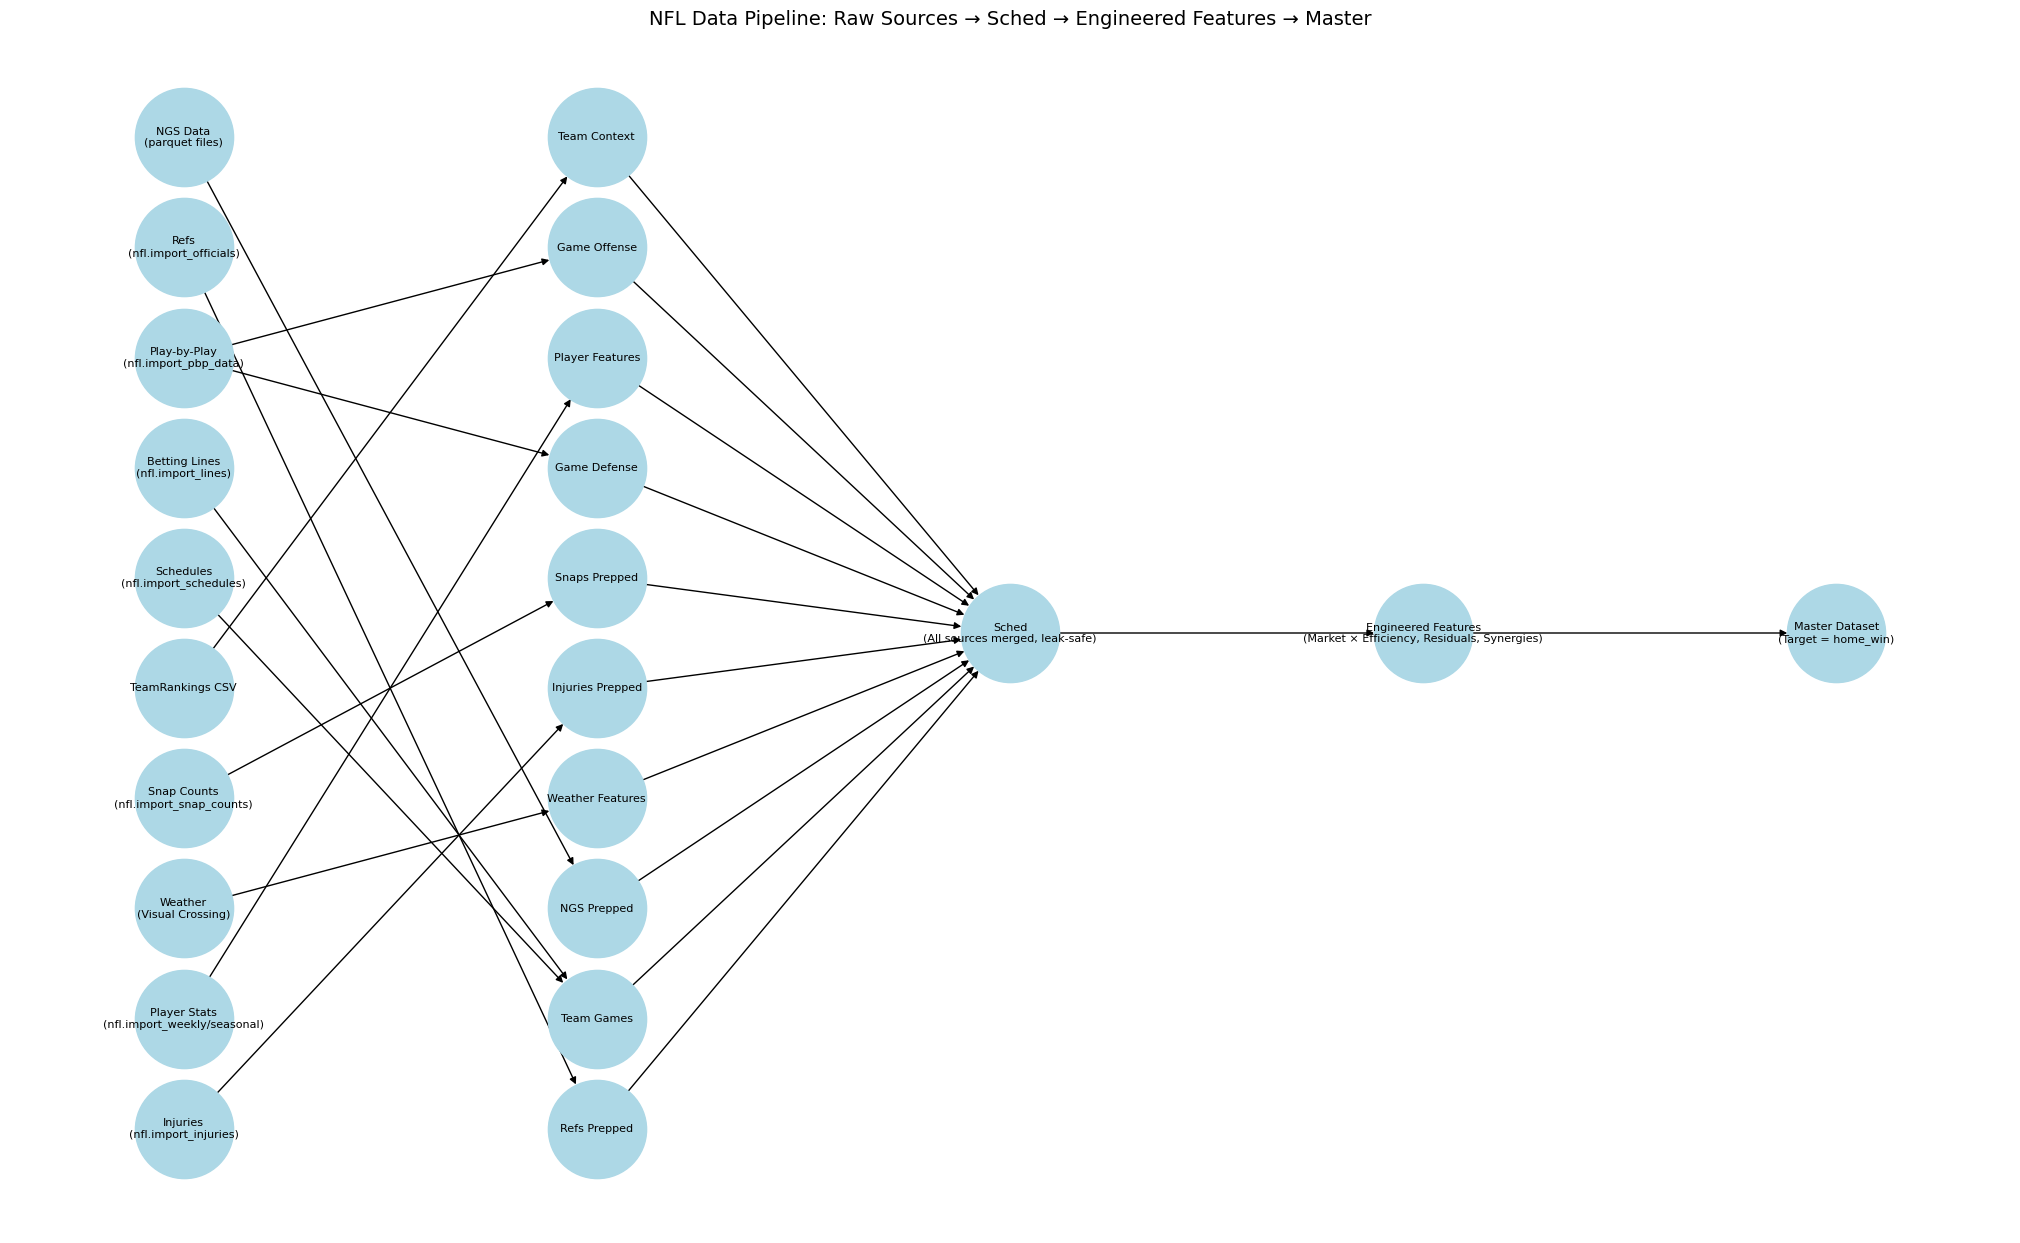

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# ============================================================
# Define nodes with subsets (layers)
# ============================================================
nodes = {
    # Raw Inputs
    "Schedules": ("Schedules\n(nfl.import_schedules)", 0),
    "Betting": ("Betting Lines\n(nfl.import_lines)", 0),
    "PBP": ("Play-by-Play\n(nfl.import_pbp_data)", 0),
    "Players": ("Player Stats\n(nfl.import_weekly/seasonal)", 0),
    "Refs": ("Refs\n(nfl.import_officials)", 0),
    "Snaps": ("Snap Counts\n(nfl.import_snap_counts)", 0),
    "Injuries": ("Injuries\n(nfl.import_injuries)", 0),
    "NGS": ("NGS Data\n(parquet files)", 0),
    "Weather": ("Weather\n(Visual Crossing)", 0),
    "TeamRankings": ("TeamRankings CSV", 0),

    # Intermediate Preps
    "TeamGames": ("Team Games", 1),
    "TeamContext": ("Team Context", 1),
    "GameOff": ("Game Offense", 1),
    "GameDef": ("Game Defense", 1),
    "PlayerFeats": ("Player Features", 1),
    "RefsPrepped": ("Refs Prepped", 1),
    "SnapsPrepped": ("Snaps Prepped", 1),
    "InjPrepped": ("Injuries Prepped", 1),
    "NGSPrepped": ("NGS Prepped", 1),
    "WeatherFeats": ("Weather Features", 1),

    # Unified Schedule
    "Sched": ("Sched\n(All sources merged, leak-safe)", 2),

    # Engineered Features
    "Interactions": ("Engineered Features\n(Market × Efficiency, Residuals, Synergies)", 3),

    # Final
    "Master": ("Master Dataset\n(Target = home_win)", 4)
}

# ============================================================
# Define edges
# ============================================================
edges = [
    ("Schedules","TeamGames"),
    ("Betting","TeamGames"),
    ("PBP","GameOff"),
    ("PBP","GameDef"),
    ("Players","PlayerFeats"),
    ("Refs","RefsPrepped"),
    ("Snaps","SnapsPrepped"),
    ("Injuries","InjPrepped"),
    ("NGS","NGSPrepped"),
    ("Weather","WeatherFeats"),
    ("TeamRankings","TeamContext"),

    ("TeamGames","Sched"),
    ("TeamContext","Sched"),
    ("GameOff","Sched"),
    ("GameDef","Sched"),
    ("PlayerFeats","Sched"),
    ("RefsPrepped","Sched"),
    ("SnapsPrepped","Sched"),
    ("InjPrepped","Sched"),
    ("NGSPrepped","Sched"),
    ("WeatherFeats","Sched"),

    ("Sched","Interactions"),
    ("Interactions","Master")
]

# ============================================================
# Build graph
# ============================================================
G = nx.DiGraph()
for k, (label, subset) in nodes.items():
    G.add_node(k, label=label, subset=subset)
G.add_edges_from(edges)

# ============================================================
# Layout (Graphviz DOT for clean layering)
# ============================================================
try:
    from networkx.drawing.nx_agraph import graphviz_layout
    pos = graphviz_layout(G, prog="dot", args="-Grankdir=LR")  # Left-to-right
except ImportError:
    pos = nx.multipartite_layout(G, subset_key="subset")       # fallback

# ============================================================
# Draw + Save
# ============================================================
plt.figure(figsize=(20, 12))
nx.draw(
    G, pos,
    with_labels=True,
    labels=nx.get_node_attributes(G, "label"),
    node_color="lightblue",
    node_size=5000,
    font_size=8,
    arrows=True,
    edge_color="black"
)
plt.title("NFL Data Pipeline: Raw Sources → Sched → Engineered Features → Master", fontsize=14)
plt.tight_layout()
plt.savefig("nfl_pipeline.png", dpi=300)
plt.show()

# ============================================================
# Save HTML Overview
# ============================================================
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>NFL Data Pipeline Overview</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 40px; line-height: 1.6; }
        h1 { color: #2c3e50; }
        h2 { color: #34495e; margin-top: 30px; }
        img { display: block; margin: 20px auto; max-width: 90%; height: auto; border: 1px solid #ccc; }
        p { margin: 10px 0; }
        ul { margin: 10px 0 10px 20px; }
        li { margin-bottom: 5px; }
    </style>
</head>
<body>
    <h1>NFL Data Pipeline</h1>
    <img src="nfl_pipeline.png" alt="NFL Pipeline Diagram">

    <h2>1. Inputs (Raw Data Sources)</h2>
    <ul>
        <li><b>Schedules</b> (<code>nfl.import_schedules</code>)</li>
        <li><b>Betting Lines</b> (<code>nfl.import_lines</code>)</li>
        <li><b>PBP</b> (<code>nfl.import_pbp_data</code>)</li>
        <li><b>Players</b> (<code>nfl.import_weekly/seasonal</code>)</li>
        <li><b>Refs</b> (<code>nfl.import_officials</code>)</li>
        <li><b>Snap Counts</b> (<code>nfl.import_snap_counts</code>)</li>
        <li><b>Injuries</b> (<code>nfl.import_injuries</code>)</li>
        <li><b>NGS</b> (parquet files)</li>
        <li><b>Weather</b> (Visual Crossing JSONs)</li>
        <li><b>TeamRankings</b> (CSV)</li>
    </ul>

    <h2>2. Core Preps</h2>
    <p>Raw inputs → team/game aggregates:</p>
    <ul>
        <li>Team Games, Team Context</li>
        <li>Offense / Defense (EPA, success, explosives)</li>
        <li>Player Features (starters, usage, lagged stats)</li>
        <li>Refs, Snaps, Injuries, NGS, Weather</li>
    </ul>

    <h2>3. Unified Schedule (Sched)</h2>
    <p>All preps merged into a single <code>sched</code> table, leak-safe.</p>

    <h2>4. Engineered Features</h2>
    <p>Market × Efficiency, Residuals, Weather sensitivity, Matchup synergies, etc.</p>

    <h2>5. Master Dataset</h2>
    <p>Final dataset with target <code>home_win</code>.</p>
</body>
</html>
"""

with open("nfl_pipeline_overview.html", "w", encoding="utf-8") as f:
    f.write(html_content)

## **VECTORIZE DATA AND PREP FOR MODELING**

In [ ]:
# ============================================================
# PHASE 6: Build model matrix (X, y) — exclude 'tb' categories
# ============================================================

import numpy as np
import pandas as pd
import re

# --- Column cleanup before Phase 6 ---
gf = game_features_extended.copy()

# --- Team code normalization (critical for alignment!) ---
TEAM_FIX = {
    "LA": "LAR",  # Rams
    "LV": "LVR",  # Raiders
    "WSH": "WAS", # Commanders
    "JAX": "JAC", # Jaguars
}
for c in ["home_team", "away_team"]:
    gf[c] = gf[c].replace(TEAM_FIX)

# --- Rebuild game_id after team fix ---
gf["game_id"] = (
    gf["season"].astype(str) + "_" +
    gf["week"].astype(str).str.zfill(2) + "_" +
    gf["home_team"] + "_" +
    gf["away_team"]
)

# --- Normalize season/week columns ---
if "season_x" in gf.columns:
    gf = gf.rename(columns={"season_x": "season"})
if "season_y" in gf.columns:
    gf = gf.drop(columns=["season_y"])
for col in ["away_week", "home_ngs_week", "away_ngs_week"]:
    if col in gf.columns:
        gf = gf.drop(columns=[col])

# --- Deduplicate and clean ---
dup_cols = [c for c in gf.columns if c.endswith("_y")]
gf = gf.drop(columns=dup_cols, errors="ignore")
gf = gf.loc[:, ~gf.columns.duplicated()]
print("[CLEANUP] Remaining columns:", gf.shape[1])

# ------------------------
# 0) Basic checks
# ------------------------
_required = {"game_id","season","week","home_team","away_team","home_score","away_score"}
missing = sorted(list(_required - set(gf.columns)))
if missing:
    raise ValueError(f"[PHASE 6] Missing required columns: {missing}")

# ------------------------
# 1) Spread implied probabilities
# ------------------------
def moneyline_to_prob(odds):
    try:
        odds = float(odds)
    except (TypeError, ValueError):
        return np.nan
    if odds > 0:
        return 100.0 / (odds + 100.0)
    elif odds < 0:
        return abs(odds) / (abs(odds) + 100.0)
    else:
        return np.nan

gf["home_spread_prob"] = gf["home_spread_odds"].apply(moneyline_to_prob)
gf["away_spread_prob"] = gf["away_spread_odds"].apply(moneyline_to_prob)

mask_valid = gf["home_spread_prob"].notna() & gf["away_spread_prob"].notna()
gf = gf.loc[mask_valid].copy()

total_prob = gf["home_spread_prob"] + gf["away_spread_prob"]
gf["home_spread_vigfree"] = gf["home_spread_prob"] / total_prob
gf["away_spread_vigfree"] = gf["away_spread_prob"] / total_prob

# ------------------------
# 2) Define target: home cover vs spread
# ------------------------
if "spread_line" not in gf.columns:
    raise ValueError("[PHASE 6] Missing spread_line column")

margin = gf["home_score"] - gf["away_score"]
home_cover = (margin > gf["spread_line"]).astype("Int64")
y = pd.Series(home_cover, index=gf.index, name="home_cover")

# ------------------------
# 3) Build feature list
# ------------------------
exclude = {
    "game_id","home_team","away_team",
    "home_score","away_score",
    "away_win","home_result","away_result","result"
}

leakage_exact = {
    "home_win","home_cover",
    "home_away_score","away_home_score","home_home_score",
    "away_szn_sum_away_result","away_away_score","home_szn_sum_home_result",
    "home_r3_mean_pre_home_result","home_szn_mean_home_away_score",
    "home_szn_mean_home_score","away_szn_sum_away_score",
    "away_r5_sum_pre_away_result","away_r3_sum_pre_away_result",
    "home_trailing","away_trailing","home_leading","away_leading",
    "home_lead_pass","away_lead_pass","home_trail_pass","away_trail_pass",
    "overtime","total",    "home_kickoff_attempts",
    "away_kickoff_attempts",
    "home_szn_sum_home_kickoff_attempts",
    "away_szn_sum_away_kickoff_attempts"
}

market_patterns = ["moneyline","spread","implied_prob","vig","vigfree"]
safe_context = ["kickoff_et","game_date","stadium","head_ref_name"]

leakage_patterns = [
    r".*_score.*",
    r".*_result.*",
    r".*kickoff_attempts.*",
]

# ❌ Exclude tb_* category features here
tb_pattern = re.compile(r"^tb_|_tb$|tb_")  # matches tb_ prefix or suffix or anywhere in middle

feature_cols = []
for c in gf.columns:
    if c in exclude or c in leakage_exact:
        continue
    if any(re.search(p, c) for p in leakage_patterns) and "_pre_" not in c:
        continue
    if tb_pattern.search(c):
        continue  # 🚫 drop tb-related features
    feature_cols.append(c)

for c in safe_context:
    if c in gf.columns and c not in feature_cols:
        feature_cols.append(c)

X = gf[feature_cols].copy()
market_cols = [c for c in gf.columns if any(p in c for p in market_patterns)]
print(f"[PHASE 6] Final feature count (no tb features): {len(feature_cols)}")

# ------------------------
# 4) Split numeric vs categorical
# ------------------------
X.columns = X.columns.astype(str)
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]
for c in categorical_cols:
    if pd.api.types.is_object_dtype(X[c]):
        X[c] = X[c].astype("category")
cat_categories = {c: X[c].cat.categories for c in categorical_cols if pd.api.types.is_categorical_dtype(X[c])}

print(f"[PHASE 6] model matrix shape: {X.shape}, target shape: {y.shape}")

# ------------------------
# 5) Meta frame
# ------------------------
spread_cols = ["home_spread_prob","away_spread_prob","home_spread_vigfree","away_spread_vigfree"]
meta = gf[["game_id","season","week","kickoff_et","home_team","away_team"] + market_cols + spread_cols].copy()
meta = meta.loc[:, ~meta.columns.duplicated()]

# ------------------------
# 6) Train/valid/test masks
# ------------------------
season_ser = pd.to_numeric(gf["season"], errors="coerce").astype("Int64")
train_mask = season_ser.between(2000, 2017)
valid_mask = season_ser.between(2018, 2021)
test_mask  = season_ser.between(2022, 2024)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_valid, y_valid = X.loc[valid_mask], y.loc[valid_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

meta_train = meta.loc[train_mask]
meta_valid = meta.loc[valid_mask]
meta_test  = meta.loc[test_mask]

print("[PHASE 6] Split sizes:", X_train.shape[0], X_valid.shape[0], X_test.shape[0])

# ------------------------
# 7) Persist artifacts
# ------------------------
meta_out, X_out, y_out = meta.copy(), X.copy(), y.copy()

# ------------------------
# 8) Category locking
# ------------------------
cat_categories = {c: X_out[c].cat.categories for c in categorical_cols if pd.api.types.is_categorical_dtype(X_out[c])}

def preprocess_for_xgb(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    # datetime → int
    dt_cols = X.select_dtypes(include=["datetimetz","datetime64"]).columns
    for c in dt_cols:
        X[c] = pd.to_datetime(X[c], errors="coerce").view("int64") // 10**9
    # force category locking
    for c, cats in cat_categories.items():
        if c in X.columns:
            X[c] = pd.Categorical(X[c], categories=cats)
    return X

[CLEANUP] Remaining columns: 6397
[PHASE 6] Final feature count (no tb features): 6320
[PHASE 6] model matrix shape: (4595, 6320), target shape: (4595,)
[PHASE 6] Split sizes: 2610 1038 854


## **MODEL**

In [ ]:
# ============================================================
# PHASE 7 — Expanded Hyperparameter + Threshold Tuning (XGBoost GPU + tqdm)
# ============================================================
import numpy as np, pandas as pd, gc
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# ---- Bring Phase 6 artifacts ----
X, y, meta = X_out.copy(), y_out.copy(), meta_out.copy()
labeled = y.notna()
X_lab, y_lab, M_lab = X.loc[labeled], y.loc[labeled].astype(int), meta.loc[labeled]
seasons = pd.to_numeric(M_lab["season"], errors="coerce").astype(int)

# splits
train_mask = seasons.between(2000, 2018)
valid_mask = seasons.between(2019, 2021)
test_mask  = seasons.between(2022, 2024)

def split(X_, y_, M_, mask): 
    return X_.loc[mask], y_.loc[mask], M_.loc[mask]

X_tr, y_tr, M_tr = split(X_lab, y_lab, M_lab, train_mask)
X_va, y_va, M_va = split(X_lab, y_lab, M_lab, valid_mask)
X_te, y_te, M_te = split(X_lab, y_lab, M_lab, test_mask)

# --- Preprocess (match Phase 6 casting) ---
def preprocess_for_xgb(Xdf: pd.DataFrame) -> pd.DataFrame:
    Xdf = Xdf.copy()
    dt_cols = Xdf.select_dtypes(include=["datetimetz","datetime64"]).columns
    for c in dt_cols:
        Xdf[c] = pd.to_datetime(Xdf[c], errors="coerce").view("int64") // 10**9
    obj_cols = Xdf.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        Xdf[c] = Xdf[c].astype("category")
    return Xdf

X_tr, X_va, X_te = map(preprocess_for_xgb, [X_tr, X_va, X_te])

dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
dvalid = xgb.DMatrix(X_va, label=y_va, enable_categorical=True)
dtest  = xgb.DMatrix(X_te, label=y_te, enable_categorical=True)

# ============================================================
# Helpers
# ============================================================
def cast_params(d: dict) -> dict:
    out = d.copy()
    int_fields = ["max_depth", "min_child_weight", "max_bin"]
    for k in int_fields:
        if k in out: out[k] = int(out[k])
    float_fields = ["learning_rate","reg_alpha","reg_lambda","gamma",
                    "colsample_bytree","subsample"]
    for k in float_fields:
        if k in out: out[k] = float(out[k])
    return out

# --- Tunable metric ---
def make_disagree_metric(
    threshold=0.5,
    w_acc=0.3,
    w_disagree_acc=0.3,
    w_disagree_rate=0.1,
    w_ev=0.3
):
    def evaluate(probs, y_true, M_meta):
        y_true = y_true.values
        y_pred = (probs >= threshold).astype(int)

        if {"home_spread_vigfree", "away_spread_vigfree"}.issubset(M_meta.columns):
            home_prob = pd.to_numeric(M_meta["home_spread_vigfree"], errors="coerce").values
            away_prob = pd.to_numeric(M_meta["away_spread_vigfree"], errors="coerce").values
        elif {"home_spread_prob", "away_spread_prob"}.issubset(M_meta.columns):
            home_prob = pd.to_numeric(M_meta["home_spread_prob"], errors="coerce").values
            away_prob = pd.to_numeric(M_meta["away_spread_prob"], errors="coerce").values
        else:
            raise KeyError("M_meta must include spread-based prob columns")

        market_pick = (home_prob >= away_prob).astype(int)

        overall_acc = (y_pred == y_true).mean()
        mask = y_pred != market_pick
        disagree_acc = (y_pred[mask] == y_true[mask]).mean() if mask.any() else 0.0
        disagree_rate = mask.mean()

        def fair_payout(p):
            if p <= 0 or p >= 1 or np.isnan(p): return np.nan
            return p / (1 - p)

        ev_list = []
        for yp, yt, hp, ap in zip(y_pred, y_true, home_prob, away_prob):
            if yp == 1:
                payout = fair_payout(hp)
                if not np.isnan(payout):
                    ev_list.append(payout if yt == 1 else -1.0)
            else:
                payout = fair_payout(ap)
                if not np.isnan(payout):
                    ev_list.append(payout if yt == 0 else -1.0)
        ev = np.nanmean(ev_list) if ev_list else 0.0

        score = (w_acc * overall_acc +
                 w_disagree_acc * disagree_acc +
                 w_disagree_rate * disagree_rate +
                 w_ev * ev)

        return score, overall_acc, disagree_acc, disagree_rate, ev
    return evaluate

def eval_bundle(preds, y_true, M_meta, thresholds):
    """Evaluate across threshold grid; pick best score."""
    results = []
    for th in thresholds:
        metric_fn = make_disagree_metric(threshold=th)
        score, overall, disa_acc, disa_rate, ev = metric_fn(preds, y_true, M_meta)
        results.append((th, score, overall, disa_acc, disa_rate, ev))
    # Pick best threshold by score
    best = max(results, key=lambda x: x[1])
    th, score, overall, disa_acc, disa_rate, ev = best
    auc = roc_auc_score(y_true, preds)
    return dict(threshold=th, score=score, overall=overall,
                disa_acc=disa_acc, disa_rate=disa_rate, ev=ev, auc=auc)

def train_once(params, num_round=800, es_rounds=100, seed=1337, thresholds=np.arange(0.4,0.61,0.02)):
    base = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "verbosity": 0,
        "seed": seed
    }
    p = cast_params({**base, **params})
    booster = xgb.train(
        p, dtrain, num_boost_round=num_round,
        evals=[(dtrain,"train"), (dvalid,"valid")],
        early_stopping_rounds=es_rounds,
        verbose_eval=False
    )
    best_iter = booster.best_iteration
    predict = lambda dm: booster.predict(dm, iteration_range=(0, best_iter+1))
    tr_p, va_p, te_p = map(predict, [dtrain, dvalid, dtest])

    m_tr = eval_bundle(tr_p, y_tr, M_tr, thresholds)
    m_va = eval_bundle(va_p, y_va, M_va, thresholds)
    m_te = eval_bundle(te_p, y_te, M_te, thresholds)

    return booster, best_iter, m_tr, m_va, m_te

# ============================================================
# Hyperparameter grid
# ============================================================
depths   = [8]        # tighten around 8
lrs      = [0.03, 0.04, 0.05]  # refine around 0.04
mcw      = [20]    # slight variation around 20
subsmpl  = [1.0]          # leave fixed for now
colsmp   = [1.0]          # leave fixed for now
reg_a    = [0]           # can tune later if needed
reg_l    = [10]          # keep fixed for now
gammas   = [0]           # keep fixed for now

grid = [
    {
        "max_depth": d,
        "learning_rate": lr,
        "min_child_weight": w,
        "subsample": ss,
        "colsample_bytree": cs,
        "reg_alpha": ra,
        "reg_lambda": rl,
        "gamma": g,
    }
    for d in depths
    for lr in lrs
    for w in mcw
    for ss in subsmpl
    for cs in colsmp
    for ra in reg_a
    for rl in reg_l
    for g in gammas
]
print(f"Grid size: {len(grid)}")

Grid size: 27


In [ ]:
# ============================================================
# Grid search loop
# ============================================================
results = []
for i, params in enumerate(tqdm(grid, desc="Grid")):
    booster, best_iter, m_tr, m_va, m_te = train_once(params, seed=1337+i)
    results.append({
        **params,
        "best_iter": best_iter,
        "train_score": m_tr["score"],
        "valid_score": m_va["score"],
        "test_score": m_te["score"],
        "valid_auc": m_va["auc"],
        "valid_ev": m_va["ev"]
    })
    gc.collect()

results_df = pd.DataFrame(results).sort_values("valid_score", ascending=False)

print("\n[TOP 10 VALID by custom score]")
print(results_df.head(10)[[
    "valid_score","valid_auc","valid_ev",
    "max_depth","min_child_weight","learning_rate",
    "subsample","colsample_bytree","reg_alpha","reg_lambda","gamma","best_iter"
]])

# Best config
best_cfg = cast_params(results_df.iloc[0][[
    "max_depth","min_child_weight","learning_rate","subsample","colsample_bytree",
    "reg_alpha","reg_lambda","gamma",
]].to_dict())

print("\n[FINAL BEST CONFIG]")
print(best_cfg)

# Retrain on train+valid with best config
X_trva = pd.concat([X_tr, X_va], axis=0)
y_trva = pd.concat([y_tr, y_va], axis=0)
dtrva  = xgb.DMatrix(X_trva, label=y_trva, enable_categorical=True)

final_params = cast_params({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "verbosity": 0,
    **best_cfg
})
final_booster = xgb.train(
    final_params, dtrva,
    num_boost_round=int(max(800, results_df["best_iter"].max()*1.2)),
    evals=[(dtrva,"train")],
    early_stopping_rounds=100,
    verbose_eval=False
)

# Expose
best_model = final_booster
best_params = best_cfg
results_overview = results_df.reset_index(drop=True)

Grid: 100%|██████████| 27/27 [22:42<00:00, 50.45s/it]



[TOP 10 VALID by custom score]
    valid_score  valid_auc  valid_ev  max_depth  min_child_weight  \
8      0.599988   0.764214  0.428006          7                25   
3      0.598619   0.766060  0.425704          7                15   
2      0.598298   0.771865  0.425123          7                25   
24     0.597151   0.765675  0.423253          9                15   
7      0.597148   0.763297  0.423245          7                20   
22     0.596831   0.762456  0.422594          9                20   
14     0.595806   0.768229  0.421012          8                25   
4      0.595656   0.765852  0.420885          7                20   
21     0.595293   0.762621  0.419906          9                15   
25     0.593996   0.763082  0.417980          9                20   

    learning_rate  subsample  colsample_bytree  reg_alpha  reg_lambda  gamma  \
8           0.045        1.0               1.0          0          10      0   
3           0.040        1.0               1.0  

## **EVALUATION TIME**

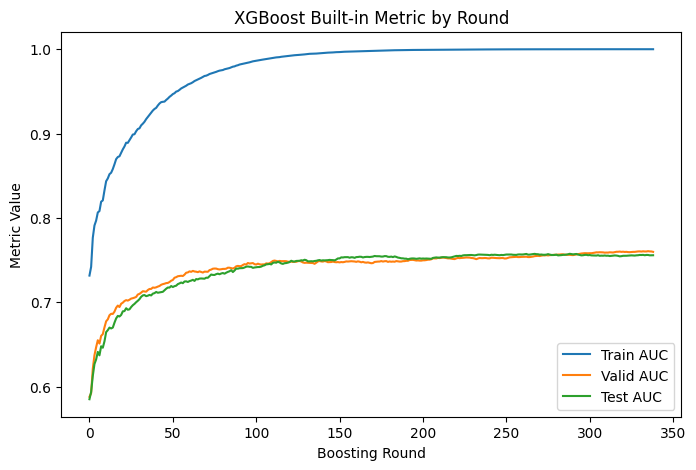

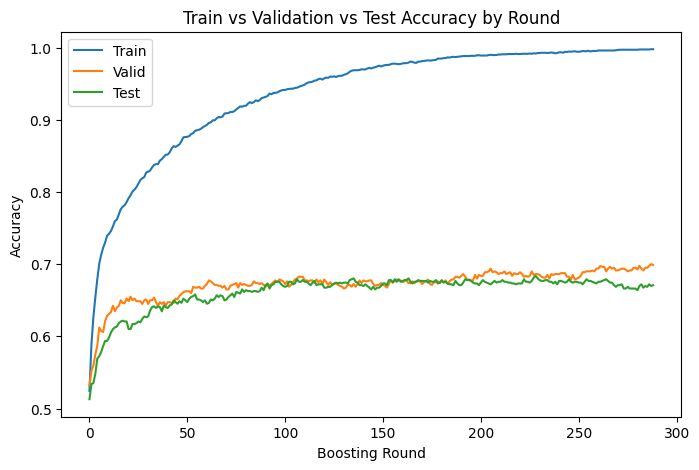

In [40]:
best_params = best_cfg
# ============================================================
# Train final model with best Phase 7 params + plot curves
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import os

# --- Build DMatrices (with preprocessing) ---
dtrain = xgb.DMatrix(preprocess_for_xgb(X_tr), label=y_tr.astype(int), enable_categorical=True)
dvalid = xgb.DMatrix(preprocess_for_xgb(X_va), label=y_va.astype(int), enable_categorical=True)
dtest  = xgb.DMatrix(preprocess_for_xgb(X_te), label=y_te.astype(int), enable_categorical=True)

# --- Base params ---
default_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",          # keep built-in for monitoring
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "verbosity": 0,
    "nthread": os.cpu_count()
}

# --- Use best params from Phase 7 ---
best_params = best_params.copy()
params = {**default_params, **best_params}

# --- Train with early stopping ---
evals_result = {}
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dvalid, "valid"), (dtest, "test")],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=False
)

# ============================================================
# Plot logloss / auc curves
# ============================================================
plt.figure(figsize=(8,5))
for split in ["train", "valid", "test"]:
    if "logloss" in evals_result[split]:
        plt.plot(evals_result[split]["logloss"], label=f"{split.capitalize()} LogLoss")
    elif "auc" in evals_result[split]:
        plt.plot(evals_result[split]["auc"], label=f"{split.capitalize()} AUC")
plt.xlabel("Boosting Round")
plt.ylabel("Metric Value")
plt.title("XGBoost Built-in Metric by Round")
plt.legend()
plt.show()

# ============================================================
# Accuracy by boosting round
# ============================================================
def accuracy_curve(dset, y_true, booster, max_round, threshold=0.5):
    accs = []
    for r in range(1, max_round + 1):
        preds = booster.predict(dset, iteration_range=(0, r))
        labels = (preds >= threshold).astype(int)
        acc = (labels == y_true.values).mean()
        accs.append(acc)
    return accs

max_round = best_model.best_iteration + 1

acc_train = accuracy_curve(dtrain, y_tr, best_model, max_round)
acc_valid = accuracy_curve(dvalid, y_va, best_model, max_round)
acc_test  = accuracy_curve(dtest,  y_te, best_model, max_round)

plt.figure(figsize=(8,5))
plt.plot(acc_train, label="Train")
plt.plot(acc_valid, label="Valid")
plt.plot(acc_test,  label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("Accuracy")
plt.title("Train vs Validation vs Test Accuracy by Round")
plt.legend()
plt.show()


Top 20 Features by Gain:
                                              Feature  Importance
0                        away_szn_mean_away_lead_pass   19.441938
1         home_r5_sum_pre_home_def_def_yards_per_play   19.291294
2                  home_r3_sum_pre_home_air_yards_sum   18.963167
3                         home_r3_mean_pre_home_plays   17.996134
4                         away_szn_mean_away_trailing   17.417353
5                         home_r5_mean_pre_home_plays   17.010029
6                              home_ko_touchback_rate   16.786234
7                         away_szn_sum_away_over_odds   16.484140
8                      offensive-points-per-game_Away   14.299398
9    away_r3_mean_pre_away_def_def_pass_plays_allowed   14.173261
10                        home_szn_mean_home_trailing   13.996306
11                                    away_neutralish   13.971298
12            home_r3_mean_pre_home_def_def_takeaways   13.866714
13                 home_szn_sum_home_points_per_dr

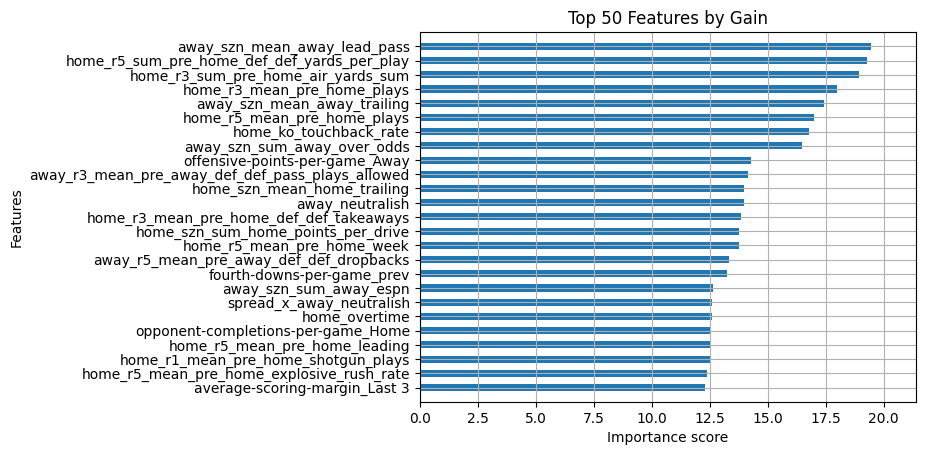

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

if "best_model" not in globals():
    raise RuntimeError("best_model not defined — run training cell first.")

# --- Feature Importance (gain-based) ---
importance = best_model.get_score(importance_type="gain")

importance_df = (
    pd.DataFrame(list(importance.items()), columns=["Feature", "Importance"])
      .sort_values("Importance", ascending=False)
      .reset_index(drop=True)
)

print("\nTop 20 Features by Gain:")
print(importance_df.head(50))

# --- Plot Top 20 ---
xgb.plot_importance(
    best_model,
    importance_type="gain",
    max_num_features=25,
    height=0.5,
    show_values=False
)
plt.title("Top 50 Features by Gain")
plt.show()

In [42]:
# =========================
# PHASE 7b — Weekly & Yearly Metrics (XGB, TEST only, Cover)
# =========================
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, confusion_matrix

# --- Predictions: only test ---
X_te_pp = preprocess_for_xgb(X_te)
dtest = xgb.DMatrix(X_te_pp, enable_categorical=True)

y_true_te = y_te.astype(int).values
y_prob_te = best_model.predict(dtest)
y_pred_te = (y_prob_te >= 0.5).astype(int)
# Build predictions DataFrame
xgb_preds_te = M_te.copy()
xgb_preds_te["y_true"] = y_te.values
xgb_preds_te["prob"]   = y_prob_te
xgb_preds_te["y_pred"] = y_pred_te

# Ensure numeric season/week
xgb_preds_te["season"] = pd.to_numeric(xgb_preds_te["season"], errors="coerce").astype("Int64")
xgb_preds_te["week"]   = pd.to_numeric(xgb_preds_te["week"],   errors="coerce").astype("Int64")

# --- Helpers ---
def _safe_confusion_counts(y, yhat):
    if len(y) == 0:
        return 0, 0, 0, 0
    cm = confusion_matrix(y, yhat, labels=[0, 1])
    if cm.shape == (1, 1):
        if np.all(y == 0): 
            return int(cm[0, 0]), 0, 0, 0
        else:              
            return 0, 0, 0, int(cm[0, 0])
    return tuple(map(int, cm.ravel()))

def _safe_auc(y, p):
    try: return float(roc_auc_score(y, p))
    except Exception: return np.nan

def _safe_logloss(y, p):
    try: return float(log_loss(y, p, labels=[0, 1]))
    except Exception: return np.nan

def _agg_group(g):
    y, yhat, p = g["y_true"].to_numpy(), g["y_pred"].to_numpy(), g["prob"].to_numpy()
    n = len(g)
    tn, fp, fn, tp = _safe_confusion_counts(y, yhat)
    return pd.Series({
        "n": n,
        "win_rate": float((y == yhat).mean()) if n else np.nan,
        "avg_prob": float(np.mean(p)) if n else np.nan,
        "pred_win_rate": float(yhat.mean()) if n else np.nan,
        "brier": float(brier_score_loss(y, p)) if n else np.nan,
        "logloss": _safe_logloss(y, p),
        "auc": _safe_auc(y, p),
        "tp": tp, "tn": tn, "fp": fp, "fn": fn
    })

# --- Weekly (TEST only) ---
weekly_test = (
    xgb_preds_te
    .dropna(subset=["season","week"])
    .groupby(["season","week"], as_index=False)
    .apply(_agg_group)
    .reset_index(drop=True)
    .sort_values(["season","week"])
)

# --- Yearly (TEST only) ---
yearly_test = (
    xgb_preds_te
    .dropna(subset=["season"])
    .groupby(["season"], as_index=False)
    .apply(_agg_group)
    .reset_index(drop=True)
    .sort_values(["season"])
)

# --- Preview ---
print("\n[PHASE 7b] Weekly TEST win metrics:")
print(weekly_test.tail(200))

print("\n[PHASE 7b] Yearly TEST win metrics:")
yearly_test.tail(200)


[PHASE 7b] Weekly TEST win metrics:
    season  week     n  win_rate  avg_prob  pred_win_rate     brier   logloss  \
0     2022     1  16.0  0.812500  0.479187       0.500000  0.124984  0.398808   
1     2022     2  16.0  0.750000  0.561768       0.625000  0.152083  0.456845   
2     2022     3  16.0  0.937500  0.404987       0.437500  0.108404  0.369692   
3     2022     4  16.0  0.562500  0.463127       0.437500  0.207106  0.586714   
4     2022     5  16.0  0.812500  0.395167       0.250000  0.143359  0.448183   
..     ...   ...   ...       ...       ...            ...       ...       ...   
61    2024    18  16.0  0.812500  0.484099       0.437500  0.185073  0.553470   
62    2024    19   6.0  0.833333  0.594006       0.666667  0.172668  0.528861   
63    2024    20   4.0  0.250000  0.492579       0.500000  0.283724  0.760023   
64    2024    21   2.0  0.500000  0.419139       0.500000  0.356898  0.928376   
65    2024    22   1.0  1.000000  0.565924       1.000000  0.188422  0.5

,season,n,win_rate,avg_prob,pred_win_rate,brier,logloss,auc,tp,tn,fp,fn
0,2022,284.0,0.679577,0.448216,0.443662,0.197059,0.574347,0.765399,85.0,108.0,41.0,50.0
1,2023,285.0,0.656140,0.475910,0.459649,0.202383,0.583693,0.744543,84.0,103.0,47.0,51.0
2,2024,285.0,0.677193,0.452922,0.414035,0.203138,0.591481,0.762048,86.0,107.0,32.0,60.0


[PHASE 7c] Best TEST threshold by disagreement accuracy: 0.355 (disagree_acc=0.6911)


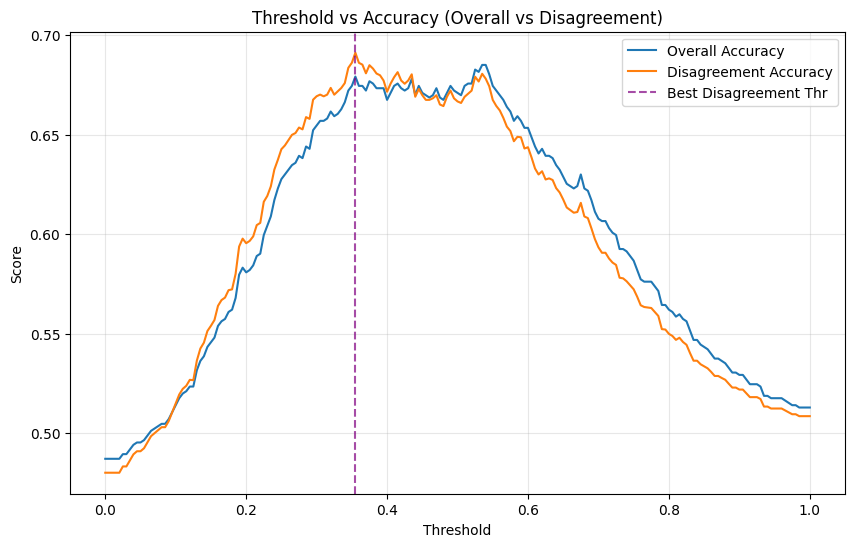

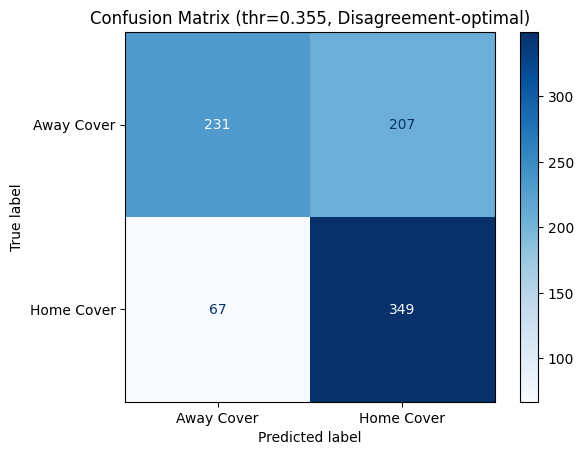

[TEST SET] Disagreement-optimal threshold: 0.355
[TEST SET] Predicted Home covers: 556 (65.1%)
[TEST SET] Predicted Away covers: 298 (34.9%)

[TEST SET] Actual outcome distribution:
  Home covers: 416 (48.7%)
  Away covers: 438 (51.3%)

[TEST SET] Predicted outcome distribution (thr=0.355, Disagreement-optimal):
  Home covers: 556 (65.1%)
  Away covers: 298 (34.9%)


In [43]:
# =========================
# PHASE 7c — Threshold Tuning Curve (XGB, TEST only, extended)
# =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
def _ensure_spread_probs(M):
    M = M.copy()
    if {"home_spread_vigfree","away_spread_vigfree"}.issubset(M.columns):
        return M
    elif {"home_spread_prob","away_spread_prob"}.issubset(M.columns):
        total_prob = M["home_spread_prob"] + M["away_spread_prob"]
        M["home_spread_vigfree"] = M["home_spread_prob"] / total_prob
        M["away_spread_vigfree"] = M["away_spread_prob"] / total_prob
        return M
    else:
        raise KeyError("M_meta must include spread-based odds/probs")


M_te = _ensure_spread_probs(M_te)

# --- Helper: implied probs (if not already defined) ---
def _implied_prob_from_ml(ml: pd.Series) -> pd.Series:
    ml = pd.to_numeric(ml, errors="coerce")
    out = pd.Series(np.nan, index=ml.index)
    pos = ml > 0
    out.loc[pos]  = 100 / (ml.loc[pos] + 100)
    out.loc[~pos] = (-ml.loc[~pos]) / ((-ml.loc[~pos]) + 100)
    return out

# --- Extended threshold sweep (with disagreement accuracy) ---
def threshold_sweep_disagree(booster, X, y, M_meta, n_steps=101):
    """Return DataFrame with threshold vs overall acc + disagree acc."""
    if len(y) == 0:
        return pd.DataFrame(columns=["thr","accuracy","disagree_acc","agree_rate"])
    
    dtest = xgb.DMatrix(X, enable_categorical=True)
    p = booster.predict(dtest)   # model probabilities

    # Market baseline
    if {"home_spread_vigfree","away_spread_vigfree"}.issubset(M_meta.columns):
        home_prob = pd.to_numeric(M_meta["home_spread_vigfree"], errors="coerce").values
        away_prob = pd.to_numeric(M_meta["away_spread_vigfree"], errors="coerce").values
    else:
        raise KeyError("M_meta must include spread vigfree probabilities")

    market_pick = (home_prob >= away_prob).astype(int)


    thrs = np.linspace(0.0, 1.0, n_steps)
    rows = []
    for t in thrs:
        yhat = (p >= t).astype(int)
        overall_acc = accuracy_score(y, yhat)

        # disagreement mask
        mask = yhat != market_pick
        if mask.any():
            disagree_acc = accuracy_score(y[mask], yhat[mask])
        else:
            disagree_acc = np.nan

        rows.append({
            "thr": t,
            "accuracy": overall_acc,
            "disagree_acc": disagree_acc,
            "agree_rate": 1 - mask.mean()
        })
    
    return pd.DataFrame(rows)

# --- Run sweep on TEST set ---
thr_curve_test = threshold_sweep_disagree(best_model, X_te, y_te, M_te, n_steps=201)

# Best threshold by disagreement accuracy
best_dis_idx = thr_curve_test["disagree_acc"].idxmax()
best_thr_dis = thr_curve_test.loc[best_dis_idx, "thr"]
best_dis_acc = thr_curve_test.loc[best_dis_idx, "disagree_acc"]

print(f"[PHASE 7c] Best TEST threshold by disagreement accuracy: "
      f"{best_thr_dis:.3f} (disagree_acc={best_dis_acc:.4f})")

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(thr_curve_test["thr"], thr_curve_test["accuracy"], label="Overall Accuracy")
plt.plot(thr_curve_test["thr"], thr_curve_test["disagree_acc"], label="Disagreement Accuracy")
plt.axvline(best_thr_dis, color="purple", linestyle="--", alpha=0.7, label="Best Disagreement Thr")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Accuracy (Overall vs Disagreement)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# --- Confusion matrix at Disagreement-optimal threshold ---
dtest = xgb.DMatrix(X_te, enable_categorical=True)
y_prob = best_model.predict(dtest)

# Ensure y_te is numpy
y_te_arr = np.asarray(y_te)

# Use disagreement-optimal threshold
y_pred_dis = (y_prob >= best_thr_dis).astype(int)

cm_dis = confusion_matrix(y_te_arr, y_pred_dis, labels=[0,1])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_dis,
    display_labels=["Away Cover", "Home Cover"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (thr={best_thr_dis:.3f}, Disagreement-optimal)")
plt.show()

# --- Outcome distribution ---
pred_home = int((y_pred_dis == 1).sum())
pred_away = int((y_pred_dis == 0).sum())
total     = len(y_pred_dis)

print(f"[TEST SET] Disagreement-optimal threshold: {best_thr_dis:.3f}")
print(f"[TEST SET] Predicted Home covers: {pred_home} ({pred_home/total:.1%})")
print(f"[TEST SET] Predicted Away covers: {pred_away} ({pred_away/total:.1%})")

# --- Actual outcome distribution ---
actual_home = int((y_te_arr == 1).sum())
actual_away = int((y_te_arr == 0).sum())
total       = len(y_te_arr)

print("\n[TEST SET] Actual outcome distribution:")
print(f"  Home covers: {actual_home} ({actual_home/total:.1%})")
print(f"  Away covers: {actual_away} ({actual_away/total:.1%})")

# --- Predicted outcome distribution (disagreement-optimal threshold) ---
print(f"\n[TEST SET] Predicted outcome distribution (thr={best_thr_dis:.3f}, Disagreement-optimal):")
print(f"  Home covers: {pred_home} ({pred_home/total:.1%})")
print(f"  Away covers: {pred_away} ({pred_away/total:.1%})")

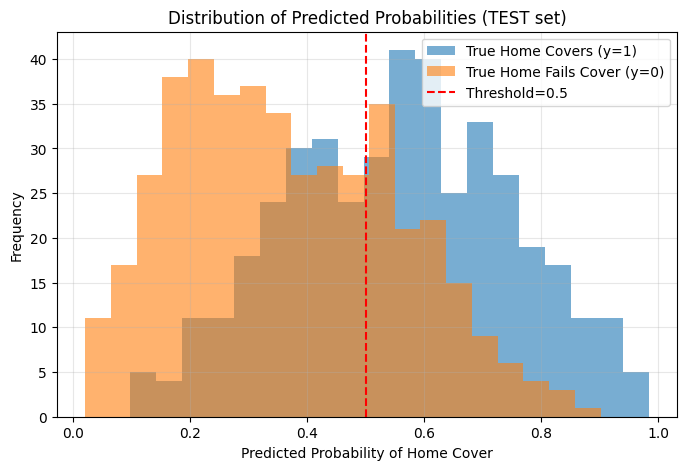

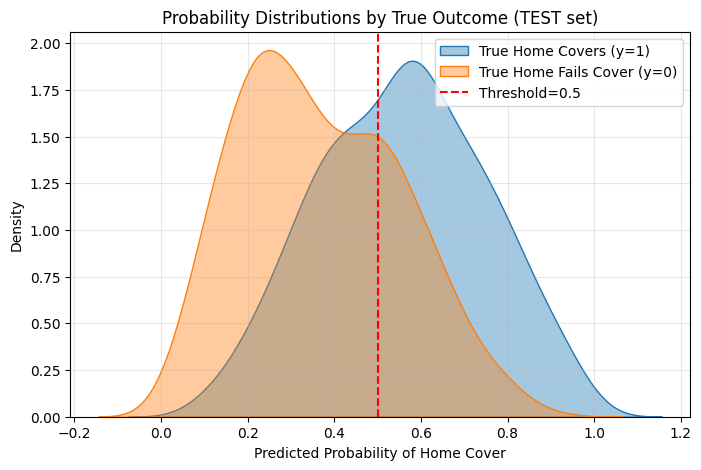

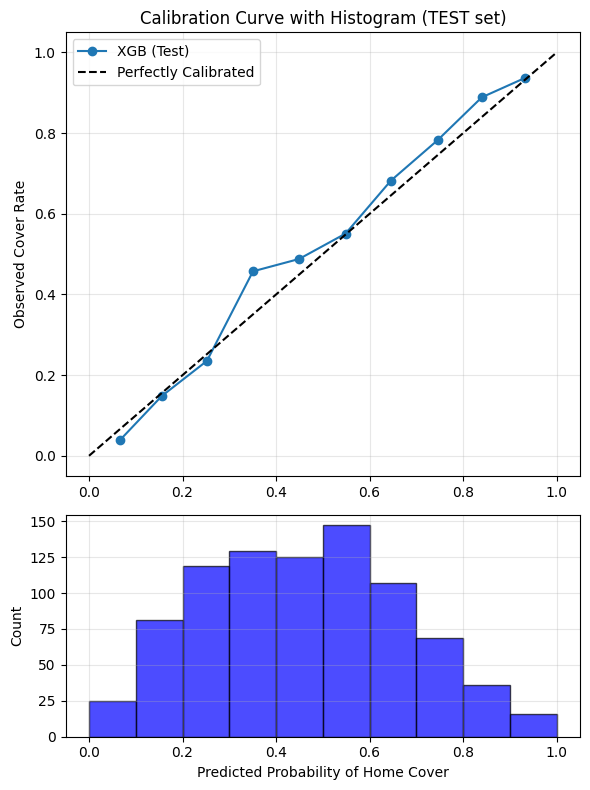

In [44]:
# =========================
# PHASE 7d — Probability Distribution (XGB, TEST only)
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

# --- Preprocess and predict ---
X_te_pp = preprocess_for_xgb(X_te)
y_true_te = y_te.astype(int).values

dtest = xgb.DMatrix(X_te_pp, enable_categorical=True)
y_prob_te = best_model.predict(dtest)   # Booster outputs probabilities

# --- Separate by true label ---
probs_homewin = y_prob_te[y_true_te == 1]
probs_awaywin = y_prob_te[y_true_te == 0]

# --- Histogram ---
plt.figure(figsize=(8,5))
plt.hist(probs_homewin, bins=20, alpha=0.6, label="True Home Covers (y=1)")
plt.hist(probs_awaywin, bins=20, alpha=0.6, label="True Home Fails Cover (y=0)")
plt.axvline(0.5, color="red", linestyle="--", label="Threshold=0.5")
plt.xlabel("Predicted Probability of Home Cover")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities (TEST set)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- KDE ---
plt.figure(figsize=(8,5))
sns.kdeplot(probs_homewin, fill=True, alpha=0.4, label="True Home Covers (y=1)")
sns.kdeplot(probs_awaywin, fill=True, alpha=0.4, label="True Home Fails Cover (y=0)")
plt.axvline(0.5, color="red", linestyle="--", label="Threshold=0.5")
plt.xlabel("Predicted Probability of Home Cover")
plt.ylabel("Density")
plt.title("Probability Distributions by True Outcome (TEST set)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Calibration curve ---
prob_true, prob_pred = calibration_curve(y_true_te, y_prob_te, n_bins=10, strategy="uniform")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8), gridspec_kw={'height_ratios':[2,1]})

ax1.plot(prob_pred, prob_true, marker="o", label="XGB (Test)")
ax1.plot([0,1],[0,1], "k--", label="Perfectly Calibrated")
ax1.set_ylabel("Observed Cover Rate")
ax1.set_title("Calibration Curve with Histogram (TEST set)")
ax1.legend()
ax1.grid(alpha=0.3)

ax2.hist(y_prob_te, bins=10, range=(0,1), alpha=0.7, color="blue", edgecolor="black")
ax2.set_xlabel("Predicted Probability of Home Cover")
ax2.set_ylabel("Count")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# --- Feature importance (Gain) ---
importance = best_model.get_score(importance_type="gain")  # no .get_booster()

# Convert to DataFrame
fi_df = pd.DataFrame({
    "feature": list(importance.keys()),
    "importance": list(importance.values())
}).sort_values("importance", ascending=False).reset_index(drop=True)

# --- Show Top 100 ---
top100 = fi_df.head(100)
print("\nTop 100 Features by Gain:")
print(top100)


Top 100 Features by Gain:
                                              feature  importance
0                        away_szn_mean_away_lead_pass   19.441938
1         home_r5_sum_pre_home_def_def_yards_per_play   19.291294
2                  home_r3_sum_pre_home_air_yards_sum   18.963167
3                         home_r3_mean_pre_home_plays   17.996134
4                         away_szn_mean_away_trailing   17.417353
..                                                ...         ...
95            away_szn_sum_away_ko_touchback_rate_lag    9.098608
96                 extra-point-attempts-per-game_Away    9.088314
97                       away_szn_sum_away_trail_pass    9.072521
98  away_szn_mean_away_def_def_third_down_conv_rat...    9.045259
99           opponent-extra-point-conversion-pct_prev    9.036841

[100 rows x 2 columns]


In [46]:
### PLACEHOLDER

import nfl_data_py as nfl

# Get base schedule
# Always rely on nfl_data_py game_id for merging
sched = nfl.import_schedules([2022,2023,2024])

# Make sure features also carry the official game_id
if "game_id" not in game_features_extended.columns:
    raise ValueError("game_features_extended must include nfl_data_py game_id for alignment")

In [47]:
print("[SCHED TEAMS]", sched["home_team"].unique())
print("[FEATURE TEAMS]", game_features_extended["home_team"].unique())

[SCHED TEAMS] ['LA' 'ATL' 'CAR' 'CHI' 'CIN' 'DET' 'HOU' 'MIA' 'NYJ' 'WAS' 'ARI' 'LAC'
 'MIN' 'TEN' 'DAL' 'SEA' 'KC' 'BAL' 'CLE' 'JAX' 'NO' 'NYG' 'PIT' 'SF'
 'DEN' 'LV' 'GB' 'BUF' 'PHI' 'IND' 'NE' 'TB']
[FEATURE TEAMS] ['NE' 'MIA' 'CLE' 'PIT' 'CHI' 'HOU' 'WAS' 'NO' 'BUF' 'PHI' 'MIN' 'DEN'
 'CAR' 'KC' 'ATL' 'TEN' 'BAL' 'DET' 'JAX' 'GB' 'TB' 'CIN' 'SEA' 'ARI'
 'IND' 'DAL' 'NYG' 'NYJ' 'SF' 'LAR' 'LAC' 'LVR']


In [48]:
# ============================================================
# PHASE 7d — Model vs Market Comparison (Spread-Cover, TEST/VAL)
# ============================================================

# --- Spread implied probabilities ---
def moneyline_to_prob(odds):
    try:
        odds = float(odds)
    except (TypeError, ValueError):
        return np.nan
    if odds > 0:
        return 100.0 / (odds + 100.0)
    elif odds < 0:
        return abs(odds) / (abs(odds) + 100.0)
    else:
        return np.nan

sched_mkt = sched.copy()

# Build spread probabilities
sched_mkt["home_spread_prob"] = sched_mkt["home_spread_odds"].apply(moneyline_to_prob)
sched_mkt["away_spread_prob"] = sched_mkt["away_spread_odds"].apply(moneyline_to_prob)

mask_valid = sched_mkt["home_spread_prob"].notna() & sched_mkt["away_spread_prob"].notna()
sched_mkt = sched_mkt.loc[mask_valid].copy()

# Vig-free normalization
total = sched_mkt["home_spread_prob"] + sched_mkt["away_spread_prob"]
sched_mkt["home_spread_vigfree"] = sched_mkt["home_spread_prob"] / total
sched_mkt["away_spread_vigfree"] = sched_mkt["away_spread_prob"] / total

# --- True cover outcome (fixed formula) ---
margin = sched_mkt["home_score"] - sched_mkt["away_score"]
sched_mkt["true_home_cover"] = np.where(
    sched_mkt["home_score"].notna() & sched_mkt["away_score"].notna(),
    (margin > sched_mkt["spread_line"]).astype(int),
    np.nan
)

# ============================================================
# Prediction helper (for covers, not wins)
# ============================================================
def predict_games(game_rows: pd.DataFrame, features_df: pd.DataFrame, threshold=best_thr_dis):
    if game_rows.empty:
        return pd.DataFrame(columns=[
            "game_id","season","week","kickoff_et","home_team","away_team",
            "prob_home_cover","predicted_home_cover","predicted_outcome"
        ])

    game_ids = game_rows["game_id"].tolist()
    feats = features_df[features_df["game_id"].isin(game_ids)].copy()

    missing_ids = set(game_ids) - set(feats["game_id"])
    if missing_ids:
        print(f"[WARN] Missing {len(missing_ids)} games in features: {sorted(list(missing_ids))[:10]} ...")

    feats = feats.loc[:, ~feats.columns.duplicated()].copy()
    ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
    X_new = feats.reindex(columns=ref_cols, fill_value=0).copy()
    X_new = preprocess_for_xgb(X_new)

    dnew = xgb.DMatrix(X_new, enable_categorical=True)
    probs = best_model.predict(dnew)

    preds_df = pd.DataFrame({"game_id": feats["game_id"].values, "prob_home_cover": probs})
    game_preds = preds_df.groupby("game_id", as_index=False)["prob_home_cover"].mean()

    out = game_rows.merge(game_preds, on="game_id", how="left").copy()
    out["predicted_home_cover"] = (out["prob_home_cover"] >= threshold).astype(int)
    out["predicted_outcome"] = np.where(
        out["predicted_home_cover"] == 1,
        out["home_team"] + " covers",
        out["away_team"] + " covers"
    )
    return out

# ============================================================
# Build predictions for seasons of interest
# ============================================================
all_preds_list = []
for yr in [2022, 2023, 2024]:
    season_rows = sched.loc[sched["season"] == yr].copy()
    if season_rows.empty:
        print(f"[WARN] No games for {yr}")
        continue
    season_preds = predict_games(season_rows, game_features_extended, threshold=best_thr_dis)
    all_preds_list.append(season_preds[[
        "game_id","season","week","prob_home_cover",
        "predicted_home_cover","predicted_outcome"
    ]])

all_preds = pd.concat(all_preds_list, ignore_index=True)
print(f"[PREDICTIONS] all_preds built for 2022–2024 → {len(all_preds)} rows")
print(all_preds["season"].value_counts())

# ============================================================
# Merge predictions with spread market data
# ============================================================
all_eval = all_preds.merge(
    sched_mkt[[
        "game_id","season","week","home_team","away_team",
        "home_score","away_score","spread_line",
        "home_spread_odds","away_spread_odds",
        "home_spread_vigfree","away_spread_vigfree",
        "true_home_cover"
    ]],
    on="game_id", how="left"
)

# Canonicalize season/week after merge
if "season_x" in all_eval.columns and "season_y" in all_eval.columns:
    all_eval = all_eval.rename(columns={"season_y": "season"}).drop(columns=["season_x"])
elif "season_y" in all_eval.columns:
    all_eval = all_eval.rename(columns={"season_y": "season"})
elif "season_x" in all_eval.columns:
    all_eval = all_eval.rename(columns={"season_x": "season"})

if "week_x" in all_eval.columns and "week_y" in all_eval.columns:
    all_eval = all_eval.rename(columns={"week_y": "week"}).drop(columns=["week_x"])
elif "week_y" in all_eval.columns:
    all_eval = all_eval.rename(columns={"week_y": "week"})
elif "week_x" in all_eval.columns:
    all_eval = all_eval.rename(columns={"week_x": "week"})

all_eval = all_eval.loc[all_eval["season"].between(2022, 2024)].copy()

# ============================================================
# Scoring
# ============================================================
if "predicted_home_cover" not in all_eval.columns:
    thr = best_thr_dis
    all_eval["predicted_home_cover"] = (all_eval["prob_home_cover"] >= thr).astype(int)

all_eval["model_pick"]  = np.where(all_eval["predicted_home_cover"]==1, "Home Cover", "Away Cover")
all_eval["market_pick"] = np.where(
    all_eval["home_spread_vigfree"] >= all_eval["away_spread_vigfree"],
    "Home Cover","Away Cover"
)
all_eval["agree"] = (all_eval["model_pick"] == all_eval["market_pick"]).astype(int)

scored = all_eval.loc[all_eval["true_home_cover"].isin([0,1])].copy()
scored["true_outcome"] = np.where(scored["true_home_cover"]==1, "Home Cover", "Away Cover")

overall_acc  = (scored["model_pick"] == scored["true_outcome"]).mean()
agree_acc    = (scored.loc[scored["agree"]==1,"model_pick"] == scored.loc[scored["agree"]==1,"true_outcome"]).mean()
disagree_acc = (scored.loc[scored["agree"]==0,"model_pick"] == scored.loc[scored["agree"]==0,"true_outcome"]).mean()
agree_rate   = scored["agree"].mean()
market_acc   = (scored["market_pick"] == scored["true_outcome"]).mean()

scored["model_correct"]  = (scored["model_pick"]  == scored["true_outcome"]).astype(int)
scored["market_correct"] = (scored["market_pick"] == scored["true_outcome"]).astype(int)

disagreements = scored.loc[scored["agree"]==0].copy()
disagree_model_correct_rate  = disagreements["model_correct"].mean()
disagree_market_correct_rate = disagreements["market_correct"].mean()

print(f"[COMPARE] Model vs Market — Spread Covers, 2022–2024, scored games: {len(scored)}")
print(f"  Agreement rate: {agree_rate:.1%}")
print(f"  Model accuracy (overall): {overall_acc:.1%}")
print(f"  Market accuracy (overall): {market_acc:.1%}")
print(f"  Model accuracy (AGREE): {agree_acc:.1%}")
print(f"  Model accuracy (DISAGREE): {disagree_acc:.1%}")
print(f"  Model correct in disagreements: {disagree_model_correct_rate:.1%}")
print(f"  Market correct in disagreements: {disagree_market_correct_rate:.1%}")

cmp_table = (
    all_eval.assign(_m=all_eval["model_pick"], _k=all_eval["market_pick"])
            .pivot_table(index="_k", columns="_m", aggfunc="size", fill_value=0)
)
cmp_table.index.name = "Market"; cmp_table.columns.name = "Model"
print("\n[COMPARE] Market vs Model pick counts:\n", cmp_table)

edges = (
    scored.loc[scored["agree"]==0, [
        "game_id","season","week","home_team","away_team",
        "home_score","away_score","spread_line",
        "home_spread_odds","away_spread_odds",
        "prob_home_cover","home_spread_vigfree","away_spread_vigfree",
        "model_pick","market_pick","true_outcome",
        "model_correct","market_correct","agree"
    ]]
    .sort_values(by=["season","week"], ascending=[True, True])
)

edges.tail(40)

[PREDICTIONS] all_preds built for 2022–2024 → 854 rows
2023    285
2024    285
2022    284
Name: season, dtype: int64
[COMPARE] Model vs Market — Spread Covers, 2022–2024, scored games: 854
  Agreement rate: 52.6%
  Model accuracy (overall): 67.0%
  Market accuracy (overall): 50.2%
  Model accuracy (AGREE): 66.4%
  Model accuracy (DISAGREE): 67.7%
  Model correct in disagreements: 67.7%
  Market correct in disagreements: 32.3%

[COMPARE] Market vs Model pick counts:
 Model       Away Cover  Home Cover
Market                            
Away Cover         132         195
Home Cover         210         317


,game_id,season,week,home_team,away_team,home_score,away_score,spread_line,home_spread_odds,away_spread_odds,prob_home_cover,home_spread_vigfree,away_spread_vigfree,model_pick,market_pick,true_outcome,model_correct,market_correct,agree
775,2024_14_LAC_KC,2024,14,KC,LAC,19.0,17.0,5.0,-105.0,-115.0,0.484581,0.489166,0.510834,Home Cover,Away Cover,Away Cover,0,1,0
778,2024_15_DAL_CAR,2024,15,CAR,DAL,14.0,30.0,2.5,-120.0,100.0,0.169462,0.521739,0.478261,Away Cover,Home Cover,Away Cover,1,0,0
779,2024_15_KC_CLE,2024,15,CLE,KC,7.0,21.0,-4.5,-110.0,-110.0,0.291033,0.500000,0.500000,Away Cover,Home Cover,Away Cover,1,0,0
782,2024_15_WAS_NO,2024,15,NO,WAS,19.0,20.0,-7.5,-108.0,-112.0,0.457235,0.495670,0.504330,Home Cover,Away Cover,Home Cover,1,0,0
786,2024_15_IND_DEN,2024,15,DEN,IND,31.0,13.0,4.5,-115.0,-105.0,0.153090,0.510834,0.489166,Away Cover,Home Cover,Home Cover,0,1,0
787,2024_15_BUF_DET,2024,15,DET,BUF,42.0,48.0,2.5,-110.0,-110.0,0.258036,0.500000,0.500000,Away Cover,Home Cover,Away Cover,1,0,0
790,2024_15_GB_SEA,2024,15,SEA,GB,13.0,30.0,-3.0,-110.0,-110.0,0.238234,0.500000,0.500000,Away Cover,Home Cover,Away Cover,1,0,0
791,2024_15_CHI_MIN,2024,15,MIN,CHI,30.0,12.0,7.0,-105.0,-115.0,0.520492,0.489166,0.510834,Home Cover,Away Cover,Home Cover,1,0,0
792,2024_15_ATL_LV,2024,15,LV,ATL,9.0,15.0,-6.5,-110.0,-110.0,0.340772,0.500000,0.500000,Away Cover,Home Cover,Home Cover,0,1,0
793,2024_16_DEN_LAC,2024,16,LAC,DEN,34.0,27.0,3.0,100.0,-120.0,0.749490,0.478261,0.521739,Home Cover,Away Cover,Home Cover,1,0,0


In [49]:
# ============================================================
# Yearly Aggregation for 2022, 2023, 2024
# ============================================================

target_years = [2022, 2023, 2024]

yearly_summary = []

for yr, group in scored[scored["season"].isin(target_years)].groupby("season"):
    n_games = len(group)
    agree_rate = group["agree"].mean()

    # ✅ compare against true_outcome (not true_winner)
    overall_acc = (group["model_pick"] == group["true_outcome"]).mean()
    market_acc  = (group["market_pick"] == group["true_outcome"]).mean()

    agree_acc = (group.loc[group["agree"]==1, "model_pick"] 
                 == group.loc[group["agree"]==1, "true_outcome"]).mean()
    disagree_acc = (group.loc[group["agree"]==0, "model_pick"] 
                    == group.loc[group["agree"]==0, "true_outcome"]).mean()

    disagree_model_correct_rate  = group.loc[group["agree"]==0, "model_correct"].mean()
    disagree_market_correct_rate = group.loc[group["agree"]==0, "market_correct"].mean()

    yearly_summary.append({
        "season": yr,
        "games": n_games,
        "agree_rate": agree_rate,
        "overall_acc": overall_acc,
        "market_acc": market_acc,
        "agree_acc": agree_acc,
        "disagree_acc": disagree_acc,
        "disagree_model_correct": disagree_model_correct_rate,
        "disagree_market_correct": disagree_market_correct_rate
    })

yearly_summary_df = pd.DataFrame(yearly_summary).sort_values("season").reset_index(drop=True)

pd.set_option("display.float_format", "{:.3f}".format)
print("\n[Yearly Model vs Market Performance 2022–2024]")
yearly_summary_df


[Yearly Model vs Market Performance 2022–2024]


,season,games,agree_rate,overall_acc,market_acc,agree_acc,disagree_acc,disagree_model_correct,disagree_market_correct
0,2022,284,0.493,0.687,0.532,0.721,0.653,0.653,0.347
1,2023,285,0.572,0.649,0.502,0.632,0.672,0.672,0.328
2,2024,285,0.512,0.674,0.474,0.644,0.705,0.705,0.295


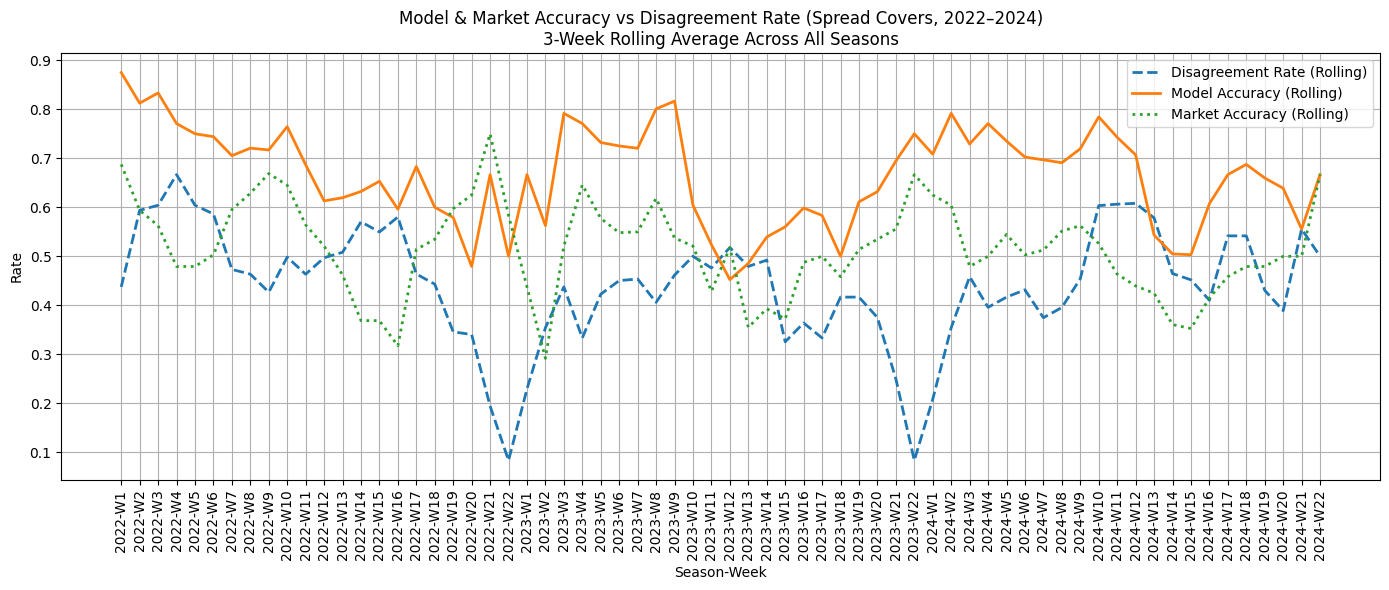

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = scored.copy()

df["model_correct"]  = (df["model_pick"]  == df["true_outcome"]).astype(int)
df["market_correct"] = (df["market_pick"] == df["true_outcome"]).astype(int)
df["agree"] = (df["model_pick"] == df["market_pick"]).astype(int)

summary = (
    df.groupby(["season","week"])
    .agg(
        games_played=("game_id","count"),
        disagree_rate=("agree", lambda x: (x==0).mean()),
        model_acc=("model_correct","mean"),
        market_acc=("market_correct","mean")
    )
    .reset_index()
    .sort_values(["season","week"])
)

# Global chronological index across seasons
summary["chron_idx"] = range(len(summary))
summary["season_week"] = summary["season"].astype(str) + "-W" + summary["week"].astype(str)

# Rolling across the entire index, not reset each season
window = 3
summary["disagree_rate_roll"] = summary["disagree_rate"].rolling(window, min_periods=1).mean()
summary["model_acc_roll"] = summary["model_acc"].rolling(window, min_periods=1).mean()
summary["market_acc_roll"] = summary["market_acc"].rolling(window, min_periods=1).mean()

plt.figure(figsize=(14,6))
# Rolling
plt.plot(summary["chron_idx"], summary["disagree_rate_roll"], label="Disagreement Rate (Rolling)", linestyle="--", linewidth=2)
plt.plot(summary["chron_idx"], summary["model_acc_roll"], label="Model Accuracy (Rolling)", linestyle="-", linewidth=2)
plt.plot(summary["chron_idx"], summary["market_acc_roll"], label="Market Accuracy (Rolling)", linestyle=":", linewidth=2)

plt.title(f"Model & Market Accuracy vs Disagreement Rate (Spread Covers, 2022–2024)\n{window}-Week Rolling Average Across All Seasons")
plt.xlabel("Season-Week")
plt.ylabel("Rate")
plt.xticks(summary["chron_idx"], summary["season_week"], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
import numpy as np
import pandas as pd

# Copy the scored set
calib = scored.copy()

# Define probability bin edges
bin_edges = np.linspace(0.0, 1.0, 21)  # 0.0–0.05, ..., 0.95–1.0
results = []

for i in range(len(bin_edges) - 1):
    low = bin_edges[i]
    high = bin_edges[i + 1]
    subset = calib.loc[
        (calib["prob_home_cover"] >= low) & (calib["prob_home_cover"] < high)
    ].copy()

    if subset.empty:
        cover_rate = np.nan
    else:
        cover_rate = (subset["model_pick"] == subset["true_outcome"]).mean()

    results.append({
        "prob_range": f"{low:.2f}–{high:.2f}",
        "n_games": len(subset),
        "cover_rate": cover_rate
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

prob_range  n_games  cover_rate
 0.00–0.05        7       1.000
 0.05–0.10       17       0.941
 0.10–0.15       44       0.864
 0.15–0.20       54       0.815
 0.20–0.25       63       0.762
 0.25–0.30       77       0.675
 0.30–0.35       74       0.554
 0.35–0.40       66       0.500
 0.40–0.45       67       0.448
 0.45–0.50       77       0.545
 0.50–0.55       73       0.630
 0.55–0.60       62       0.629
 0.60–0.65       44       0.659
 0.65–0.70       40       0.775
 0.70–0.75       34       0.765
 0.75–0.80       24       0.833
 0.80–0.85       10       1.000
 0.85–0.90       11       0.909
 0.90–0.95        6       1.000
 0.95–1.00        4       1.000


## **PREDICTION TIME**

In [52]:
sched = game_features_extended

In [53]:
# ============================================================
# PHASE 7f — Weekly Spread Cover Predictions
# ============================================================
import numpy as np
import pandas as pd
import xgboost as xgb

opt_thr = best_thr_dis  # threshold from Phase 6

# --- Strict preprocessing (category locking + datetime handling) ---
def preprocess_for_xgb_strict(X_new: pd.DataFrame) -> pd.DataFrame:
    X_new = X_new.copy()
    for c, cats in cat_categories.items():
        if c in X_new.columns:
            X_new[c] = pd.Categorical(X_new[c], categories=cats)
    dt_cols = X_new.select_dtypes(include=["datetimetz","datetime64"]).columns
    for c in dt_cols:
        X_new[c] = pd.to_datetime(X_new[c], errors="coerce").view("int64") // 10**9
    return X_new

# -------------------------
# Helper: predict per game_id (Home Cover)
# -------------------------
def predict_games(game_rows: pd.DataFrame, features_df: pd.DataFrame, threshold=opt_thr):
    if game_rows.empty:
        return pd.DataFrame(columns=[
            "game_id","season","week","kickoff_et","home_team","away_team",
            "prob_home_cover","predicted_home_cover","predicted_outcome"
        ])

    game_ids = game_rows["game_id"].tolist()
    feats = features_df[features_df["game_id"].isin(game_ids)].copy()

    # Align to training schema
    ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
    feats = feats.loc[:, ~feats.columns.duplicated()].copy()
    X_new = feats.reindex(columns=ref_cols, fill_value=0).copy()
    X_new = preprocess_for_xgb_strict(X_new)

    dnew = xgb.DMatrix(X_new, enable_categorical=True)
    probs = best_model.predict(dnew)  # P(home covers)

    preds_df = pd.DataFrame({"game_id": feats["game_id"].values, "prob_home_cover": probs})
    game_preds = preds_df.groupby("game_id", as_index=False)["prob_home_cover"].mean()

    out = game_rows.merge(game_preds, on="game_id", how="left").copy()
    out["predicted_home_cover"] = (out["prob_home_cover"] >= threshold).astype(int)
    out["predicted_outcome"] = np.where(
        out["predicted_home_cover"] == 1,
        out["home_team"] + " covers",
        out["away_team"] + " covers"
    )
    return out

# -------------------------
# Example: Week 2 (2025 REG)
# -------------------------
week2_games = (
    sched[
        (sched["season"] == 2025) &
        (sched["game_type"] == "REG") &
        (sched["week"] == 2)                     # <-- FIXED to match "Week 2"
    ][["game_id","season","week","home_team","away_team","kickoff_et"]]
    .sort_values("kickoff_et")
)

week2_preds = predict_games(week2_games, game_features_extended, threshold=opt_thr)

print("\n[PHASE 7f] Week 2 Spread Cover Predictions:")
print(week2_preds)


[PHASE 7f] Week 2 Spread Cover Predictions:
            game_id  season  week home_team away_team  \
0    2025_02_WAS_GB    2025     2        GB       WAS   
1    2025_02_LA_TEN    2025     2       TEN       LAR   
2   2025_02_NYG_DAL    2025     2       DAL       NYG   
3   2025_02_CHI_DET    2025     2       DET       CHI   
4   2025_02_BUF_NYJ    2025     2       NYJ       BUF   
5   2025_02_SEA_PIT    2025     2       PIT       SEA   
6     2025_02_SF_NO    2025     2        NO        SF   
7   2025_02_JAX_CIN    2025     2       CIN       JAX   
8   2025_02_CLE_BAL    2025     2       BAL       CLE   
9    2025_02_NE_MIA    2025     2       MIA        NE   
10  2025_02_DEN_IND    2025     2       IND       DEN   
11  2025_02_CAR_ARI    2025     2       ARI       CAR   
12   2025_02_PHI_KC    2025     2        KC       PHI   
13  2025_02_ATL_MIN    2025     2       MIN       ATL   
14   2025_02_TB_HOU    2025     2       HOU        TB   
15   2025_02_LAC_LV    2025     2       LVR

In [54]:
# =========================
# PHASE 7g — Evaluate Week 1 Spread-Cover Predictions (with vig-free spreads)
# =========================
import numpy as np
import pandas as pd

def _implied_prob_from_odds(odds: pd.Series) -> pd.Series:
    """Convert American odds to implied probability (with vig)."""
    odds = pd.to_numeric(odds, errors="coerce")
    out = pd.Series(np.nan, index=odds.index)
    pos = odds > 0
    out.loc[pos]  = 100 / (odds.loc[pos] + 100)
    out.loc[~pos] = (-odds.loc[~pos]) / ((-odds.loc[~pos]) + 100)
    return out

sched_eval = sched.copy()

# True home cover (matches Phase 6 target)
sched_eval["true_home_cover"] = np.where(
    sched_eval["home_score"].notna() & sched_eval["away_score"].notna(),
    (sched_eval["home_score"] - sched_eval["away_score"] > sched_eval["spread_line"]).astype(int),
    np.nan
)

# Attach spread odds if present
spread_cols = ["home_spread_odds", "away_spread_odds"]
have_spreads = [c for c in spread_cols if c in sched_eval.columns]
merge_cols = ["game_id","home_score","away_score","spread_line","true_home_cover"] + have_spreads

week1_eval = week2_preds.merge(
    sched_eval[merge_cols],
    on="game_id", how="left"
)

# Vig-free implied cover probabilities
if "home_spread_odds" in week1_eval.columns and "away_spread_odds" in week1_eval.columns:
    home_raw = _implied_prob_from_odds(week1_eval["home_spread_odds"])
    away_raw = _implied_prob_from_odds(week1_eval["away_spread_odds"])
    total = home_raw + away_raw
    week1_eval["home_spread_prob"] = home_raw / total
    week1_eval["away_spread_prob"] = away_raw / total
    week1_eval["market_pick"]  = np.where(
        week1_eval["home_spread_prob"] >= week1_eval["away_spread_prob"],
        "Home Cover", "Away Cover"
    )

# Binary predictions (re-check threshold)
week1_eval["predicted_home_cover"] = (week1_eval["prob_home_cover"] >= opt_thr).astype(int)

# Labels
week1_eval["predicted_outcome"] = np.where(
    week1_eval["predicted_home_cover"] == 1, "Home Cover", "Away Cover"
)
week1_eval["true_outcome"] = np.where(
    week1_eval["true_home_cover"] == 1, "Home Cover",
    np.where(week1_eval["true_home_cover"] == 0, "Away Cover", "N/A")
)

# Correctness
week1_eval["correct"] = np.where(
    week1_eval["true_home_cover"].isna(),
    np.nan,
    (week1_eval["predicted_home_cover"] == week1_eval["true_home_cover"]).astype(float)
)

# Accuracy (exclude missing scores)
acc = week1_eval.loc[~week1_eval["true_home_cover"].isna(), "correct"].mean()
print(f"\n[PHASE 7g] Week 1 Spread-Cover Accuracy: {acc:.2%}")

# Detailed rows
cols = [
    "game_id","home_team","away_team",
    "home_score","away_score","spread_line",
    "prob_home_cover","predicted_outcome","true_outcome","correct",
    "home_spread_odds","away_spread_odds",
    "home_spread_prob","away_spread_prob","market_pick"
]
week1_eval[[c for c in cols if c in week1_eval.columns]]


[PHASE 7g] Week 1 Spread-Cover Accuracy: 75.00%


,game_id,home_team,away_team,home_score,away_score,spread_line,prob_home_cover,predicted_outcome,true_outcome,correct,home_spread_odds,away_spread_odds,home_spread_prob,away_spread_prob,market_pick
0,2025_02_WAS_GB,GB,WAS,27.000,18.000,3.500,0.924,Home Cover,Home Cover,1.000,-102.000,-118.000,0.483,0.517,Away Cover
1,2025_02_LA_TEN,TEN,LAR,19.000,33.000,-5.500,0.115,Away Cover,Away Cover,1.000,-112.000,-108.000,0.504,0.496,Home Cover
2,2025_02_NYG_DAL,DAL,NYG,40.000,37.000,4.500,0.144,Away Cover,Away Cover,1.000,-120.000,100.000,0.522,0.478,Home Cover
3,2025_02_CHI_DET,DET,CHI,52.000,21.000,6.000,0.912,Home Cover,Home Cover,1.000,-110.000,-110.000,0.500,0.500,Home Cover
4,2025_02_BUF_NYJ,NYJ,BUF,10.000,30.000,-6.000,0.193,Away Cover,Away Cover,1.000,-108.000,-112.000,0.496,0.504,Away Cover
5,2025_02_SEA_PIT,PIT,SEA,17.000,31.000,3.500,0.177,Away Cover,Away Cover,1.000,-110.000,-110.000,0.500,0.500,Home Cover
6,2025_02_SF_NO,NO,SF,21.000,26.000,-3.000,0.105,Away Cover,Away Cover,1.000,-110.000,-110.000,0.500,0.500,Home Cover
7,2025_02_JAX_CIN,CIN,JAX,31.000,27.000,3.500,0.221,Away Cover,Home Cover,0.000,-105.000,-115.000,0.489,0.511,Away Cover
8,2025_02_CLE_BAL,BAL,CLE,41.000,17.000,12.500,0.798,Home Cover,Home Cover,1.000,-115.000,-105.000,0.511,0.489,Home Cover
9,2025_02_NE_MIA,MIA,NE,27.000,33.000,1.500,0.033,Away Cover,Away Cover,1.000,-110.000,-110.000,0.500,0.500,Home Cover


In [55]:
# --- Ensure we have market implied probs (spread-based) ---
need = {"home_spread_prob","away_spread_prob"}
if not need.issubset(week1_eval.columns):
    raise ValueError("Run the spread-odds step first to create home_spread_prob/away_spread_prob.")

# --- Model & market picks ---
week1_eval["model_pick"]   = np.where(week1_eval["predicted_home_cover"]==1, "Home Cover", "Away Cover")
week1_eval["market_pick"]  = np.where(
    week1_eval["home_spread_prob"] >= week1_eval["away_spread_prob"],
    "Home Cover","Away Cover"
)
week1_eval["agree"] = (week1_eval["model_pick"] == week1_eval["market_pick"]).astype(int)

# --- True outcome label (ignore games without scores) ---
mask_scored = week1_eval["true_home_cover"].isin([0,1])
week1_scored = week1_eval.loc[mask_scored].copy()
week1_scored["true_outcome"] = np.where(
    week1_scored["true_home_cover"]==1, "Home Cover", "Away Cover"
)

# --- Accuracy overall, agree, disagree ---
overall_acc  = (week1_scored["model_pick"]==week1_scored["true_outcome"]).mean()
agree_acc    = (week1_scored.loc[week1_scored["agree"]==1,"model_pick"]==
                week1_scored.loc[week1_scored["agree"]==1,"true_outcome"]).mean()
disagree_acc = (week1_scored.loc[week1_scored["agree"]==0,"model_pick"]==
                week1_scored.loc[week1_scored["agree"]==0,"true_outcome"]).mean()
agree_rate   = week1_scored["agree"].mean()

print(f"[COMPARE] Model vs Market — scored games: {len(week1_scored)}")
print(f"  Agreement rate: {agree_rate:.1%}")
print(f"  Model accuracy (overall): {overall_acc:.1%}")
print(f"  Model accuracy (when AGREE with market): {agree_acc:.1%}")
print(f"  Model accuracy (when DISAGREE with market): {disagree_acc:.1%}")

# --- Confusion table (model vs market picks) ---
cmp_table = (week1_eval
             .assign(_m=week1_eval["model_pick"], _k=week1_eval["market_pick"])
             .pivot_table(index="_k", columns="_m", aggfunc="size", fill_value=0))
cmp_table.index.name = "Market"
cmp_table.columns.name = "Model"
print("\n[COMPARE] Market vs Model pick counts:\n", cmp_table)

# --- Full disagreement rundown ---
edges = (week1_scored
         .loc[week1_scored["agree"]==0,
              ["game_id","home_team","away_team",
               "prob_home_cover","home_spread_prob","away_spread_prob",
               "model_pick","market_pick","true_outcome"]]
         .copy())

# Add correctness flags
edges["model_correct"]  = (edges["model_pick"]==edges["true_outcome"]).astype(int)
edges["market_correct"] = (edges["market_pick"]==edges["true_outcome"]).astype(int)

print("\n[COMPARE] Full Disagreement Rundown:")
print(edges.sort_values(["model_correct","prob_home_cover"], ascending=[False,False]).to_string(index=False))

[COMPARE] Model vs Market — scored games: 16
  Agreement rate: 56.2%
  Model accuracy (overall): 75.0%
  Model accuracy (when AGREE with market): 55.6%
  Model accuracy (when DISAGREE with market): 100.0%

[COMPARE] Market vs Model pick counts:
 Model       Away Cover  Home Cover
Market                            
Away Cover           3           1
Home Cover           6           6

[COMPARE] Full Disagreement Rundown:
        game_id home_team away_team  prob_home_cover  home_spread_prob  away_spread_prob model_pick market_pick true_outcome  model_correct  market_correct
 2025_02_WAS_GB        GB       WAS            0.924             0.483             0.517 Home Cover  Away Cover   Home Cover              1               0
 2025_02_LAC_LV       LVR       LAC            0.341             0.511             0.489 Away Cover  Home Cover   Away Cover              1               0
2025_02_SEA_PIT       PIT       SEA            0.177             0.500             0.500 Away Cover  Home Co

### **WEEK 3**

In [56]:
# =========================
# PHASE 7f — Week 3 + Today's Predictions (XGB Booster, Spread Cover)
# =========================
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
import pytz

# --- Strict preprocessing (uses locked categories from Phase 6) ---
def preprocess_for_xgb_strict(X_new: pd.DataFrame) -> pd.DataFrame:
    X_new = X_new.copy()
    for c, cats in cat_categories.items():
        if c in X_new.columns:
            X_new[c] = pd.Categorical(X_new[c], categories=cats)
    dt_cols = X_new.select_dtypes(include=["datetimetz","datetime64"]).columns
    for c in dt_cols:
        X_new[c] = pd.to_datetime(X_new[c], errors="coerce").view("int64") // 10**9
    return X_new


# -------------------------
# Helper: predict per game_id (Home Cover)
# -------------------------
def predict_games(game_rows: pd.DataFrame, features_df: pd.DataFrame, threshold=opt_thr):
    if game_rows.empty:
        return pd.DataFrame(columns=[
            "game_id","season","week","kickoff_et","home_team","away_team",
            "prob_home_cover","predicted_home_cover","predicted_outcome"
        ])

    # Extract features for requested games
    game_ids = game_rows["game_id"].tolist()
    feats = features_df[features_df["game_id"].isin(game_ids)].copy()

    # --- Align to training schema and preprocess (deduplicate columns)
    ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
    feats = feats.loc[:, ~feats.columns.duplicated()].copy()
    X_new = feats.reindex(columns=ref_cols, fill_value=0).copy()
    X_new = preprocess_for_xgb_strict(X_new)

    # Predict with Booster
    dnew = xgb.DMatrix(X_new, enable_categorical=True)
    probs = best_model.predict(dnew)  # P(home covers spread)

    # Average to one row per game_id in case of duplicates
    preds_df = pd.DataFrame({"game_id": feats["game_id"].values, "prob_home_cover": probs})
    game_preds = preds_df.groupby("game_id", as_index=False)["prob_home_cover"].mean()

    # Merge predictions back to schedule metadata
    out = game_rows.merge(game_preds, on="game_id", how="left").copy()

    out["predicted_home_cover"] = (out["prob_home_cover"] >= threshold).astype(int)
    out["predicted_outcome"] = np.where(
        out["predicted_home_cover"] == 1,
        out["home_team"] + " covers",
        out["away_team"] + " covers"
    )

    return out


# -------------------------
# Week 3 (2025 REG)
# -------------------------
week3_games = (
    sched[
        (sched["season"] == 2025) &
        (sched["game_type"] == "REG") &
        (sched["week"] == 3)
    ][["game_id","season","week","home_team","away_team","kickoff_et"]]
    .sort_values("kickoff_et")
)

week3_preds = predict_games(week3_games, game_features_extended, threshold=opt_thr)
week3_preds

,game_id,season,week,home_team,away_team,kickoff_et,prob_home_cover,predicted_home_cover,predicted_outcome
0,2025_03_MIA_BUF,2025,3,BUF,MIA,2025-09-18 20:15:00-04:00,0.358,1,BUF covers
1,2025_03_LA_PHI,2025,3,PHI,LAR,2025-09-21 13:00:00-04:00,0.686,1,PHI covers
2,2025_03_LV_WAS,2025,3,WAS,LVR,2025-09-21 13:00:00-04:00,0.888,1,WAS covers
3,2025_03_IND_TEN,2025,3,TEN,IND,2025-09-21 13:00:00-04:00,0.150,0,IND covers
4,2025_03_PIT_NE,2025,3,NE,PIT,2025-09-21 13:00:00-04:00,0.232,0,PIT covers
5,2025_03_HOU_JAX,2025,3,JAX,HOU,2025-09-21 13:00:00-04:00,0.732,1,JAX covers
6,2025_03_CIN_MIN,2025,3,MIN,CIN,2025-09-21 13:00:00-04:00,0.502,1,MIN covers
7,2025_03_GB_CLE,2025,3,CLE,GB,2025-09-21 13:00:00-04:00,0.235,0,GB covers
8,2025_03_ATL_CAR,2025,3,CAR,ATL,2025-09-21 13:00:00-04:00,0.835,1,CAR covers
9,2025_03_NYJ_TB,2025,3,TB,NYJ,2025-09-21 13:00:00-04:00,0.331,0,NYJ covers


In [57]:
import numpy as np
import pandas as pd

def _implied_prob_from_odds(odds: pd.Series) -> pd.Series:
    odds = pd.to_numeric(odds, errors="coerce")
    out = pd.Series(np.nan, index=odds.index)
    pos = odds > 0
    out.loc[pos]  = 100 / (odds.loc[pos] + 100)
    out.loc[~pos] = (-odds.loc[~pos]) / ((-odds.loc[~pos]) + 100)
    return out

sched_eval = sched.copy()

# True spread outcome
sched_eval["true_home_cover"] = np.where(
    sched_eval["home_score"].notna() & sched_eval["away_score"].notna(),
    (sched_eval["home_score"] - sched_eval["away_score"] > sched_eval["spread_line"]).astype(int),
    np.nan
)

# Merge predictions with schedule fields
merge_cols = [
    "game_id","home_team","away_team","home_score","away_score","spread_line","true_home_cover",
    "home_spread_odds","away_spread_odds","home_moneyline","away_moneyline"
]
merge_cols = [c for c in merge_cols if c in sched_eval.columns]

week3_eval = week3_preds.merge(sched_eval[merge_cols], on="game_id", how="left")

# Market implied cover probabilities: prefer spread odds
if {"home_spread_odds","away_spread_odds"}.issubset(week3_eval.columns):
    h_raw = _implied_prob_from_odds(week3_eval["home_spread_odds"])
    a_raw = _implied_prob_from_odds(week3_eval["away_spread_odds"])
else:
    # fallback to moneylines if spread odds are missing
    if {"home_moneyline","away_moneyline"}.issubset(week3_eval.columns):
        h_raw = _implied_prob_from_odds(week3_eval["home_moneyline"])
        a_raw = _implied_prob_from_odds(week3_eval["away_moneyline"])
    else:
        h_raw = pd.Series(np.nan, index=week3_eval.index)
        a_raw = pd.Series(np.nan, index=week3_eval.index)

total = h_raw + a_raw
week3_eval["home_spread_prob"] = h_raw / total
week3_eval["away_spread_prob"] = a_raw / total

# Model predictions (threshold already chosen as opt_thr)
week3_eval["predicted_home_cover"] = (week3_eval["prob_home_cover"] >= opt_thr).astype(int)
week3_eval["predicted_outcome"] = np.where(week3_eval["predicted_home_cover"]==1, "Home Cover", "Away Cover")

# Market pick
week3_eval["market_pick"] = np.where(
    week3_eval["home_spread_prob"] >= week3_eval["away_spread_prob"],
    "Home Cover","Away Cover"
)

# Labels and correctness
week3_eval["true_outcome"] = np.where(
    week3_eval["true_home_cover"]==1, "Home Cover",
    np.where(week3_eval["true_home_cover"]==0, "Away Cover", "N/A")
)
week3_eval["correct"] = np.where(
    week3_eval["true_home_cover"].isna(),
    np.nan,
    (week3_eval["predicted_home_cover"] == week3_eval["true_home_cover"]).astype(float)
)

# Accuracy (exclude missing scores)
acc = week3_eval.loc[~week3_eval["true_home_cover"].isna(), "correct"].mean()
print(f"\n[PHASE 7g] Week 3 Spread-Cover Accuracy: {acc:.2%}")

# Detailed rows
cols = [
    "game_id","home_team","away_team","home_score","away_score","spread_line",
    "prob_home_cover","predicted_outcome","true_outcome","correct",
    "home_spread_odds","away_spread_odds","home_spread_prob","away_spread_prob","market_pick"
]
print(week3_eval[[c for c in cols if c in week3_eval.columns]].to_string(index=False))


[PHASE 7g] Week 3 Spread-Cover Accuracy: 75.00%
        game_id  home_score  away_score  spread_line  prob_home_cover predicted_outcome true_outcome  correct  home_spread_odds  away_spread_odds  home_spread_prob  away_spread_prob market_pick
2025_03_MIA_BUF      31.000      21.000       12.500            0.358        Home Cover   Away Cover    0.000          -110.000          -110.000             0.500             0.500  Home Cover
 2025_03_LA_PHI      33.000      26.000        3.500            0.686        Home Cover   Home Cover    1.000          -112.000          -108.000             0.504             0.496  Home Cover
 2025_03_LV_WAS      41.000      24.000        2.500            0.888        Home Cover   Home Cover    1.000          -120.000           100.000             0.522             0.478  Home Cover
2025_03_IND_TEN      20.000      41.000       -6.000            0.150        Away Cover   Away Cover    1.000          -112.000          -108.000             0.504            

In [58]:
# --- Ensure we have spread probabilities ---
need = {"home_spread_prob", "away_spread_prob"}
for col in need:
    if col not in week3_eval.columns:
        week3_eval[col] = np.nan

# --- Model & market picks ---
week3_eval["model_pick"] = np.where(
    week3_eval["predicted_home_cover"] == 1, "Home Cover", "Away Cover"
)
week3_eval["market_pick"] = np.where(
    week3_eval["home_spread_prob"] >= week3_eval["away_spread_prob"],
    "Home Cover", "Away Cover"
)
week3_eval["agree"] = (week3_eval["model_pick"] == week3_eval["market_pick"]).astype(int)

# --- True outcome label (ignore games without scores) ---
mask_scored = week3_eval["true_home_cover"].isin([0, 1])
week3_scored = week3_eval.loc[mask_scored].copy()
week3_scored["true_outcome"] = np.where(
    week3_scored["true_home_cover"] == 1, "Home Cover", "Away Cover"
)

# --- Accuracy metrics ---
overall_acc  = (week3_scored["model_pick"] == week3_scored["true_outcome"]).mean()
agree_acc    = (
    week3_scored.loc[week3_scored["agree"] == 1, "model_pick"]
    == week3_scored.loc[week3_scored["agree"] == 1, "true_outcome"]
).mean()
disagree_acc = (
    week3_scored.loc[week3_scored["agree"] == 0, "model_pick"]
    == week3_scored.loc[week3_scored["agree"] == 0, "true_outcome"]
).mean()
agree_rate   = week3_scored["agree"].mean()

print(f"[COMPARE] Model vs Market — Week 3 scored games: {len(week3_scored)}")
print(f"  Agreement rate: {agree_rate:.1%}")
print(f"  Model accuracy (overall): {overall_acc:.1%}")
print(f"  Model accuracy (when AGREE with market): {agree_acc:.1%}")
print(f"  Model accuracy (when DISAGREE with market): {disagree_acc:.1%}")

# --- Confusion table ---
cmp_table = (
    week3_eval
    .assign(_m=week3_eval["model_pick"], _k=week3_eval["market_pick"])
    .pivot_table(index="_k", columns="_m", aggfunc="size", fill_value=0)
)
cmp_table.index.name = "Market"
cmp_table.columns.name = "Model"
print("\n[COMPARE] Market vs Model pick counts:\n", cmp_table)

# --- Full disagreement rundown ---
cols = [
    "game_id", "home_team", "away_team",  # only included if present
    "prob_home_cover", "home_spread_prob", "away_spread_prob",
    "model_pick", "market_pick", "true_outcome"
]
cols = [c for c in cols if c in week3_scored.columns]  # safe subset

edges = week3_scored.loc[week3_scored["agree"] == 0, cols].copy()
edges["model_correct"]  = (edges["model_pick"] == edges["true_outcome"]).astype(int)
edges["market_correct"] = (edges["market_pick"] == edges["true_outcome"]).astype(int)

print("\n[COMPARE] Full Disagreement Rundown:")
print(edges.sort_values(["model_correct", "prob_home_cover"], ascending=[False, False]).to_string(index=False))


[COMPARE] Model vs Market — Week 3 scored games: 16
  Agreement rate: 43.8%
  Model accuracy (overall): 75.0%
  Model accuracy (when AGREE with market): 85.7%
  Model accuracy (when DISAGREE with market): 66.7%

[COMPARE] Market vs Model pick counts:
 Model       Away Cover  Home Cover
Market                            
Away Cover           1           3
Home Cover           6           6

[COMPARE] Full Disagreement Rundown:
        game_id  prob_home_cover  home_spread_prob  away_spread_prob model_pick market_pick true_outcome  model_correct  market_correct
 2025_03_NO_SEA            0.753             0.489             0.511 Home Cover  Away Cover   Home Cover              1               0
2025_03_DAL_CHI            0.530             0.489             0.511 Home Cover  Away Cover   Home Cover              1               0
 2025_03_NYJ_TB            0.331             0.511             0.489 Away Cover  Home Cover   Away Cover              1               0
 2025_03_PIT_NE           

# **Week 4**

In [59]:
# =========================
# PHASE 7f — Week 4 + Today's Predictions (XGB Booster, Spread Cover)
# =========================
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
import pytz
opt_thr = best_thr_dis  # threshold from Phase 6
# --- Strict preprocessing (uses locked categories from Phase 6) ---
def preprocess_for_xgb_strict(X_new: pd.DataFrame) -> pd.DataFrame:
    X_new = X_new.copy()
    for c, cats in cat_categories.items():
        if c in X_new.columns:
            X_new[c] = pd.Categorical(X_new[c], categories=cats)
    dt_cols = X_new.select_dtypes(include=["datetimetz","datetime64"]).columns
    for c in dt_cols:
        X_new[c] = pd.to_datetime(X_new[c], errors="coerce").view("int64") // 10**9
    return X_new


# -------------------------
# Helper: predict per game_id (Home Cover)
# -------------------------
def predict_games(game_rows: pd.DataFrame, features_df: pd.DataFrame, threshold=opt_thr):
    if game_rows.empty:
        return pd.DataFrame(columns=[
            "game_id","season","week","kickoff_et","home_team","away_team",
            "prob_home_cover","predicted_home_cover","predicted_outcome"
        ])

    # Extract features for requested games
    game_ids = game_rows["game_id"].tolist()
    feats = features_df[features_df["game_id"].isin(game_ids)].copy()

    # --- Align to training schema and preprocess (deduplicate columns)
    ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
    feats = feats.loc[:, ~feats.columns.duplicated()].copy()
    X_new = feats.reindex(columns=ref_cols, fill_value=0).copy()
    X_new = preprocess_for_xgb_strict(X_new)

    # Predict with Booster
    dnew = xgb.DMatrix(X_new, enable_categorical=True)
    probs = best_model.predict(dnew)  # P(home covers spread)

    # Average to one row per game_id in case of duplicates
    preds_df = pd.DataFrame({"game_id": feats["game_id"].values, "prob_home_cover": probs})
    game_preds = preds_df.groupby("game_id", as_index=False)["prob_home_cover"].mean()

    # Merge predictions back to schedule metadata
    out = game_rows.merge(game_preds, on="game_id", how="left").copy()

    out["predicted_home_cover"] = (out["prob_home_cover"] >= threshold).astype(int)
    out["predicted_outcome"] = np.where(
        out["predicted_home_cover"] == 1,
        out["home_team"] + " covers",
        out["away_team"] + " covers"
    )

    return out


# -------------------------
# Week 4 (2025 REG)
# -------------------------
week4_games = (
    sched[
        (sched["season"] == 2025) &
        (sched["game_type"] == "REG") &
        (sched["week"] == 4)
    ][["game_id","season","week","home_team","away_team","kickoff_et"]]
    .sort_values("kickoff_et")
)

week4_preds = predict_games(week4_games, game_features_extended, threshold=opt_thr)
week4_preds

,game_id,season,week,home_team,away_team,kickoff_et,prob_home_cover,predicted_home_cover,predicted_outcome
0,2025_04_SEA_ARI,2025,4,ARI,SEA,2025-09-25 20:15:00-04:00,0.144,0,SEA covers
1,2025_04_MIN_PIT,2025,4,PIT,MIN,2025-09-28 09:30:00-04:00,0.585,1,PIT covers
2,2025_04_WAS_ATL,2025,4,ATL,WAS,2025-09-28 13:00:00-04:00,0.541,1,ATL covers
3,2025_04_PHI_TB,2025,4,TB,PHI,2025-09-28 13:00:00-04:00,0.598,1,TB covers
4,2025_04_CAR_NE,2025,4,NE,CAR,2025-09-28 13:00:00-04:00,0.258,0,CAR covers
5,2025_04_NO_BUF,2025,4,BUF,NO,2025-09-28 13:00:00-04:00,0.508,1,BUF covers
6,2025_04_TEN_HOU,2025,4,HOU,TEN,2025-09-28 13:00:00-04:00,0.533,1,HOU covers
7,2025_04_LAC_NYG,2025,4,NYG,LAC,2025-09-28 13:00:00-04:00,0.478,1,NYG covers
8,2025_04_CLE_DET,2025,4,DET,CLE,2025-09-28 13:00:00-04:00,0.290,0,CLE covers
9,2025_04_IND_LA,2025,4,LAR,IND,2025-09-28 16:05:00-04:00,0.132,0,IND covers


In [60]:
import numpy as np
import pandas as pd
opt_thr = best_thr_dis  # threshold from Phase 6
def _implied_prob_from_odds(odds: pd.Series) -> pd.Series:
    odds = pd.to_numeric(odds, errors="coerce")
    out = pd.Series(np.nan, index=odds.index)
    pos = odds > 0
    out.loc[pos]  = 100 / (odds.loc[pos] + 100)
    out.loc[~pos] = (-odds.loc[~pos]) / ((-odds.loc[~pos]) + 100)
    return out

sched_eval = sched.copy()

# --- True spread outcome ---
sched_eval["true_home_cover"] = np.where(
    sched_eval["home_score"].notna() & sched_eval["away_score"].notna(),
    (sched_eval["home_score"] - sched_eval["away_score"] > sched_eval["spread_line"]).astype(int),
    np.nan
)

# --- Merge predictions with schedule fields ---
merge_cols = [
    "game_id","home_team","away_team","home_score","away_score","spread_line","true_home_cover",
    "home_spread_odds","away_spread_odds","home_moneyline","away_moneyline"
]
merge_cols = [c for c in merge_cols if c in sched_eval.columns]

week4_eval = week4_preds.merge(sched_eval[merge_cols], on="game_id", how="left")

# --- Market implied cover probabilities: prefer spread odds ---
if {"home_spread_odds","away_spread_odds"}.issubset(week4_eval.columns):
    h_raw = _implied_prob_from_odds(week4_eval["home_spread_odds"])
    a_raw = _implied_prob_from_odds(week4_eval["away_spread_odds"])
elif {"home_moneyline","away_moneyline"}.issubset(week4_eval.columns):
    h_raw = _implied_prob_from_odds(week4_eval["home_moneyline"])
    a_raw = _implied_prob_from_odds(week4_eval["away_moneyline"])
else:
    h_raw = pd.Series(np.nan, index=week4_eval.index)
    a_raw = pd.Series(np.nan, index=week4_eval.index)

total = h_raw + a_raw
week4_eval["home_spread_prob"] = h_raw / total
week4_eval["away_spread_prob"] = a_raw / total

# --- Model predictions ---
week4_eval["predicted_home_cover"] = (week4_eval["prob_home_cover"] >= opt_thr).astype(int)
week4_eval["predicted_outcome"] = np.where(
    week4_eval["predicted_home_cover"]==1, "Home Cover", "Away Cover"
)

# --- Model pick line (explicit bet instruction) ---
def format_bet(row):
    spread = row["spread_line"]
    if pd.isna(spread):
        return "No Line"
    # Home favored → print as negative
    home_line = -spread
    # Away line is just the negative of home_line
    away_line = spread

    if row["predicted_home_cover"] == 1:
        return f"Take {row['home_team_x']} {home_line:+}"
    else:
        return f"Take {row['away_team_x']} {away_line:+}"

week4_eval["model_pick_line"] = week4_eval.apply(format_bet, axis=1)

# --- Market pick ---
week4_eval["market_pick"] = np.where(
    week4_eval["home_spread_prob"] >= week4_eval["away_spread_prob"],
    "Home Cover","Away Cover"
)

# --- Labels and correctness ---
week4_eval["true_outcome"] = np.where(
    week4_eval["true_home_cover"]==1, "Home Cover",
    np.where(week4_eval["true_home_cover"]==0, "Away Cover", "N/A")
)
week4_eval["correct"] = np.where(
    week4_eval["true_home_cover"].isna(),
    np.nan,
    (week4_eval["predicted_home_cover"] == week4_eval["true_home_cover"]).astype(float)
)

# --- Accuracy ---
acc = week4_eval.loc[~week4_eval["true_home_cover"].isna(), "correct"].mean()
print(f"\n[PHASE 7g] Week 4 Spread-Cover Accuracy: {acc:.2%}")

# --- Detailed rows ---
cols = [
    "game_id","home_team_x","away_team_x","home_score","away_score","spread_line",""
    "prob_home_cover","predicted_outcome","model_pick_line","true_outcome","correct",
    "home_spread_odds","away_spread_odds","home_spread_prob","away_spread_prob","market_pick"
]

print(week4_eval[[c for c in cols if c in week4_eval.columns]].to_string(index=False))


[PHASE 7g] Week 4 Spread-Cover Accuracy: 56.25%
        game_id home_team_x away_team_x  home_score  away_score  spread_line  prob_home_cover predicted_outcome model_pick_line true_outcome  correct  home_spread_odds  away_spread_odds  home_spread_prob  away_spread_prob market_pick
2025_04_SEA_ARI         ARI         SEA      20.000      23.000       -1.500            0.144        Away Cover   Take SEA -1.5   Away Cover    1.000          -110.000          -110.000             0.500             0.500  Home Cover
2025_04_MIN_PIT         PIT         MIN      24.000      21.000       -2.500            0.585        Home Cover   Take PIT +2.5   Home Cover    1.000           105.000          -125.000             0.468             0.532  Away Cover
2025_04_WAS_ATL         ATL         WAS      34.000      27.000        2.500            0.541        Home Cover   Take ATL -2.5   Home Cover    1.000          -110.000          -110.000             0.500             0.500  Home Cover
 2025_04_PHI_TB

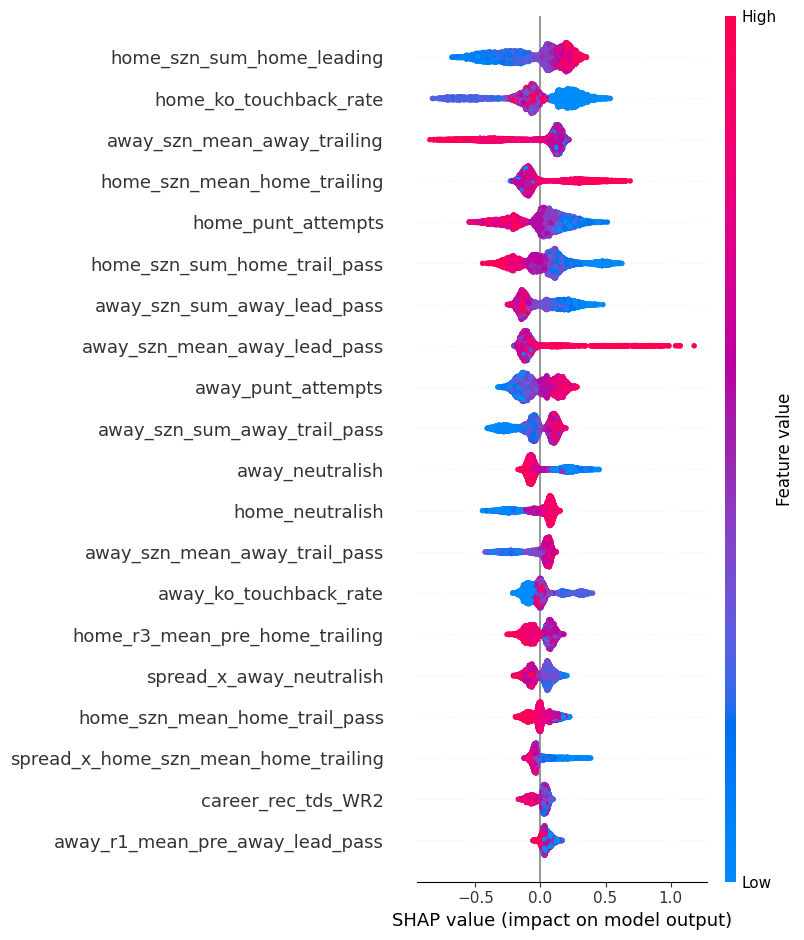


Top SHAP contributors for game_id=2004_01_BAL_CLE
home_szn_sum_home_trail_pass    0.445
home_ko_touchback_rate          0.330
away_szn_sum_away_lead_pass     0.303
away_szn_sum_away_trail_pass    0.253
home_szn_sum_home_leading       0.171
away_szn_mean_away_trailing     0.167
away_szn_mean_away_lead_pass    0.152
home_szn_mean_home_trailing     0.150
home_szn_mean_home_trail_pass   0.140
home_punt_attempts              0.139
Name: 2004_01_BAL_CLE, dtype: float32

Top SHAP contributors for game_id=2004_01_DAL_MIN
away_szn_mean_away_lead_pass   0.785
home_szn_mean_home_trailing    0.305
away_szn_sum_away_lead_pass    0.223
home_neutralish                0.200
home_penalty_yards_per_play    0.183
away_szn_sum_away_trail_pass   0.171
home_szn_sum_home_trail_pass   0.147
away_szn_mean_away_trailing    0.139
spread_x_away_neutralish       0.136
home_szn_sum_home_leading      0.116
Name: 2004_01_DAL_MIN, dtype: float32

Top SHAP contributors for game_id=2004_01_DET_CHI
away_szn_mean_away_tr

In [61]:
# =========================
# PHASE 7h — SHAP value analysis for ALL GAMES
# =========================
import shap
import numpy as np
import pandas as pd
import xgboost as xgb

# --- Use all available game_ids from the feature table ---
game_ids_all = game_features_extended["game_id"].unique().tolist()
feats_all = game_features_extended.copy()

# --- Align to training schema ---
ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
feats_all = feats_all.loc[:, ~feats_all.columns.duplicated()].copy()
X_all = feats_all.reindex(columns=ref_cols, fill_value=0).copy()
X_all = preprocess_for_xgb_strict(X_all)

# --- Convert categorical columns to integer codes for SHAP ---
for col in X_all.select_dtypes(["category"]).columns:
    X_all[col] = X_all[col].cat.codes

# Ensure numeric only
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0)

# --- SHAP Explainer ---
explainer_all = shap.TreeExplainer(best_model, feature_perturbation="interventional")
shap_values_all = explainer_all.shap_values(X_all, check_additivity=False)

# --- Convert to DataFrame ---
shap_df_all = pd.DataFrame(shap_values_all, columns=X_all.columns, index=feats_all.index)
shap_df_all["game_id"] = feats_all["game_id"].values

# --- Aggregate SHAP values to game level ---
game_shap_all = shap_df_all.groupby("game_id").mean(numeric_only=True)

# --- Merge with schedule or evaluation table ---
sched_shap = sched.merge(game_shap_all, on="game_id", how="left", suffixes=("", "_shap"))

# --- Global SHAP summary plot ---
shap.summary_plot(shap_values_all, X_all, feature_names=X_all.columns)

# --- Top 10 SHAP contributors for every game ---
# Produces a dict: {game_id: top10_features_series}
top_shap_by_game = {
    gid: row.abs().sort_values(ascending=False).head(10)
    for gid, row in game_shap_all.iterrows()
}

# Example: print top features for the first 5 games
for i, gid in enumerate(list(top_shap_by_game.keys())[:5]):
    print(f"\nTop SHAP contributors for game_id={gid}")
    print(top_shap_by_game[gid])

In [62]:
# --- Ensure we have spread probabilities ---
need = {"home_spread_prob", "away_spread_prob"}
for col in need:
    if col not in week4_eval.columns:
        week4_eval[col] = np.nan

# --- Model & market picks ---
week4_eval["model_pick"] = np.where(
    week4_eval["predicted_home_cover"] == 1, "Home Cover", "Away Cover"
)
week4_eval["market_pick"] = np.where(
    week4_eval["home_spread_prob"] >= week4_eval["away_spread_prob"],
    "Home Cover", "Away Cover"
)
week4_eval["agree"] = (week4_eval["model_pick"] == week4_eval["market_pick"]).astype(int)

# --- True outcome label (ignore games without scores) ---
mask_scored = week4_eval["true_home_cover"].isin([0, 1])
week3_scored = week4_eval.loc[mask_scored].copy()
week3_scored["true_outcome"] = np.where(
    week3_scored["true_home_cover"] == 1, "Home Cover", "Away Cover"
)

# --- Accuracy metrics ---
overall_acc  = (week3_scored["model_pick"] == week3_scored["true_outcome"]).mean()
agree_acc    = (
    week3_scored.loc[week3_scored["agree"] == 1, "model_pick"]
    == week3_scored.loc[week3_scored["agree"] == 1, "true_outcome"]
).mean()
disagree_acc = (
    week3_scored.loc[week3_scored["agree"] == 0, "model_pick"]
    == week3_scored.loc[week3_scored["agree"] == 0, "true_outcome"]
).mean()
agree_rate   = week3_scored["agree"].mean()

print(f"[COMPARE] Model vs Market — Week 3 scored games: {len(week3_scored)}")
print(f"  Agreement rate: {agree_rate:.1%}")
print(f"  Model accuracy (overall): {overall_acc:.1%}")
print(f"  Model accuracy (when AGREE with market): {agree_acc:.1%}")
print(f"  Model accuracy (when DISAGREE with market): {disagree_acc:.1%}")

# --- Confusion table ---
cmp_table = (
    week4_eval
    .assign(_m=week4_eval["model_pick"], _k=week4_eval["market_pick"])
    .pivot_table(index="_k", columns="_m", aggfunc="size", fill_value=0)
)
cmp_table.index.name = "Market"
cmp_table.columns.name = "Model"
print("\n[COMPARE] Market vs Model pick counts:\n", cmp_table)

# --- Full disagreement rundown ---
cols = [
    "game_id", "home_team", "away_team",  # only included if present
    "prob_home_cover", "home_spread_prob", "away_spread_prob",
    "model_pick", "market_pick", "true_outcome"
]
cols = [c for c in cols if c in week3_scored.columns]  # safe subset

edges = week3_scored.loc[week3_scored["agree"] == 0, cols].copy()
edges["model_correct"]  = (edges["model_pick"] == edges["true_outcome"]).astype(int)
edges["market_correct"] = (edges["market_pick"] == edges["true_outcome"]).astype(int)

print("\n[COMPARE] Full Disagreement Rundown:")
print(edges.sort_values(["model_correct", "prob_home_cover"], ascending=[False, False]).to_string(index=False))

[COMPARE] Model vs Market — Week 3 scored games: 16
  Agreement rate: 31.2%
  Model accuracy (overall): 56.2%
  Model accuracy (when AGREE with market): 60.0%
  Model accuracy (when DISAGREE with market): 54.5%

[COMPARE] Market vs Model pick counts:
 Model       Away Cover  Home Cover
Market                            
Away Cover           0           7
Home Cover           4           5

[COMPARE] Full Disagreement Rundown:
        game_id  prob_home_cover  home_spread_prob  away_spread_prob model_pick market_pick true_outcome  model_correct  market_correct
 2025_04_BAL_KC            0.680             0.478             0.522 Home Cover  Away Cover   Home Cover              1               0
2025_04_MIN_PIT            0.585             0.468             0.532 Home Cover  Away Cover   Home Cover              1               0
2025_04_TEN_HOU            0.533             0.489             0.511 Home Cover  Away Cover   Home Cover              1               0
2025_04_CIN_DEN           

In [63]:
import pandas as pd
import numpy as np
from itertools import combinations, product

# --- Merge teams into evaluation set (ensure team names available) ---
merge_cols = ["game_id", "home_team", "away_team"]
week4_eval = week4_eval.merge(
    sched[merge_cols],
    on="game_id",
    how="left"
)

# --- Helpers ---
def odds_to_decimal(odds):
    """Convert US odds to decimal odds."""
    try:
        odds = float(odds)
    except (TypeError, ValueError):
        return np.nan
    return 1 + (odds / 100 if odds > 0 else 100 / abs(odds))

def parlay_ev(legs, stake=1.0):
    """Compute EV, win prob, and payout for a parlay ticket."""
    p_win = np.prod([p for p, _ in legs])
    payout = np.prod([D for _, D in legs]) * stake
    ev = p_win * payout - stake
    return ev, p_win, payout

# --- Ensure kickoff column is datetime ---
week4_eval["kickoff_et"] = pd.to_datetime(week4_eval["kickoff_et"], errors="coerce")
subset_1pm = week4_eval[week4_eval["kickoff_et"].dt.hour == 13].copy()
subset_4pm = week4_eval[week4_eval["kickoff_et"].dt.hour == 16].copy()

def analyze_round_robin(subset, label="", stake=1.0):
    print(f"\n===== {label} ROUND ROBIN (Spread Cover) =====")

    # --- Build legs from model pick ---
    legs = []
    for _, row in subset.iterrows():
        if row.get("predicted_home_cover", 0) == 1:
            p = row["prob_home_cover"]
            D = odds_to_decimal(row.get("home_spread_odds"))
            pick = f"{row['home_team_x']} (Home Cover)"
        else:
            p = 1 - row["prob_home_cover"]
            D = odds_to_decimal(row.get("away_spread_odds"))
            pick = f"{row['away_team_x']} (Away Cover)"
        legs.append((p, D, pick))

    n = len(legs)
    if n == 0:
        print("No games in this slate.")
        return pd.DataFrame(), {}

    # --- Generate all tickets (round robin 1..n) ---
    all_tickets = []
    total_ev = 0.0
    for k in range(1, n + 1):
        for combo in combinations(range(n), k):
            sel = [(legs[i][0], legs[i][1]) for i in combo]
            ev, p_win, payout = parlay_ev(sel, stake=stake)
            picks = [legs[i][2] for i in combo]
            all_tickets.append({
                "k": k,
                "legs": picks,
                "prob_win": p_win,
                "payout_$": payout,
                "EV_$": ev
            })
            total_ev += ev

    tickets_df = pd.DataFrame(all_tickets)

    # --- Total staked across all tickets ---
    num_tix = (1 << n) - 1  # 2^n - 1 tickets
    total_spent = num_tix * stake

    print("\n--- Tickets (first 20) ---")
    print(tickets_df.head(20))
    print(f"\nTotal tickets: {num_tix}")
    print(f"Stake per ticket: ${stake:.2f}")
    print(f"Total amount spent across all tickets: ${total_spent:.2f}")
    print(f"Total EV across all tickets: ${total_ev:.2f}")

    # --- Scenario EVs: conditional on exactly m covers ---
    probs = [p for p, _, _ in legs]
    decs  = [D for _, D, _ in legs]

    ev_mass   = {m: 0.0 for m in range(n + 1)}
    prob_mass = {m: 0.0 for m in range(n + 1)}

    for outcome in product([0, 1], repeat=n):
        p_out = np.prod([p if o == 1 else 1 - p for p, o in zip(probs, outcome)])
        if p_out == 0.0:
            continue
        wins = sum(outcome)

        # Net P/L across all tickets
        net = 0.0
        for k in range(1, n + 1):
            for combo in combinations(range(n), k):
                if all(outcome[i] == 1 for i in combo):
                    payout = np.prod([decs[i] for i in combo]) * stake
                    net += payout - stake
                else:
                    net += -stake

        ev_mass[wins]   += p_out * net
        prob_mass[wins] += p_out

    scenario_ev_conditional = {
        m: (ev_mass[m] / prob_mass[m]) if prob_mass[m] > 0 else np.nan
        for m in range(n + 1)
    }

    total_ev_from_scenarios = sum(ev_mass.values())
    print("\n--- Scenario EV (conditional on exactly m covers) ---")
    for m in range(n + 1):
        print(f"m={m}: EV|m = ${scenario_ev_conditional[m]:.2f}   "
              f"P(m)={prob_mass[m]:.4f}")

    print(f"\nCheck: sum_m P(m)*EV|m = ${total_ev_from_scenarios:.2f} "
          f"vs Total EV = ${total_ev:.2f}  (diff=${total_ev_from_scenarios - total_ev:.6f})")

    # --- Worst/best case ---
    net_if_all_lose = -stake * num_tix
    net_if_all_win  = sum(
        np.prod([decs[i] for i in combo]) * stake - stake
        for k in range(1, n + 1)
        for combo in combinations(range(n), k)
    )
    print(f"\nNet if all {n} lose (no covers): ${net_if_all_lose:.2f}")
    print(f"Net if all {n} win (all covers): ${net_if_all_win:.2f}")

    return tickets_df, scenario_ev_conditional

# --- Run analysis ---
tickets_1pm, scen_1pm = analyze_round_robin(subset_1pm, "SUNDAY 1PM", stake=1.0)
tickets_4pm, scen_4pm = analyze_round_robin(subset_4pm, "SUNDAY 4PM", stake=1.0)


===== SUNDAY 1PM ROUND ROBIN (Spread Cover) =====

--- Tickets (first 20) ---
    k                                  legs  prob_win  payout_$   EV_$
0   1                    [ATL (Home Cover)]     0.541     1.909  0.033
1   1                     [TB (Home Cover)]     0.598     1.847  0.104
2   1                    [CAR (Away Cover)]     0.742     1.926  0.428
3   1                    [BUF (Home Cover)]     0.508     1.952 -0.009
4   1                    [HOU (Home Cover)]     0.533     1.952  0.041
5   1                    [NYG (Home Cover)]     0.478     1.926 -0.079
6   1                    [CLE (Away Cover)]     0.710     1.926  0.367
7   2   [ATL (Home Cover), TB (Home Cover)]     0.323     3.527  0.140
8   2  [ATL (Home Cover), CAR (Away Cover)]     0.401     3.677  0.475
9   2  [ATL (Home Cover), BUF (Home Cover)]     0.275     3.727  0.023
10  2  [ATL (Home Cover), HOU (Home Cover)]     0.288     3.727  0.075
11  2  [ATL (Home Cover), NYG (Home Cover)]     0.259     3.677 -0.04

In [64]:
import pandas as pd
import numpy as np
from itertools import combinations, product

# --- Merge team names into evaluation set safely ---
merge_cols = [c for c in ["game_id", "home_team", "away_team"] if c in sched.columns]
week4_eval = week4_eval.merge(
    sched[merge_cols],
    on="game_id",
    how="left"
)

# --- Helpers ---
def odds_to_decimal(odds):
    """Convert US odds to decimal odds."""
    try:
        odds = float(odds)
    except (TypeError, ValueError):
        return np.nan
    return 1 + (odds / 100 if odds > 0 else 100 / abs(odds))

def parlay_ev(legs, stake=1.0):
    """Compute EV, win prob, and payout for a parlay ticket."""
    p_win = np.prod([p for p, _ in legs])
    payout = np.prod([D for _, D in legs]) * stake
    ev = p_win * payout - stake
    return ev, p_win, payout

def analyze_round_robin(subset, label="", stake=1.0):
    print(f"\n===== {label} ROUND ROBIN (Spread Cover) =====")

    # --- Build legs from model pick ---
    legs = []
    for _, row in subset.iterrows():
        home_team = row.get("home_team", "HOME")
        away_team = row.get("away_team", "AWAY")

        if row.get("predicted_home_cover", 0) == 1:
            p = row["prob_home_cover"]
            D = odds_to_decimal(row.get("home_spread_odds"))
            pick = f"{home_team} (Home Cover)"
        else:
            p = 1 - row["prob_home_cover"]
            D = odds_to_decimal(row.get("away_spread_odds"))
            pick = f"{away_team} (Away Cover)"

        legs.append((p, D, pick))

    n = len(legs)
    if n == 0:
        print("No games in this slate.")
        return pd.DataFrame(), {}

    # --- Generate all tickets ---
    all_tickets, total_ev = [], 0.0
    for k in range(1, n + 1):
        for combo in combinations(range(n), k):
            sel = [(legs[i][0], legs[i][1]) for i in combo]
            ev, p_win, payout = parlay_ev(sel, stake=stake)
            picks = [legs[i][2] for i in combo]
            all_tickets.append({
                "k": k,
                "legs": picks,
                "prob_win": p_win,
                "payout_$": payout,
                "EV_$": ev
            })
            total_ev += ev

    tickets_df = pd.DataFrame(all_tickets)

    # --- Totals ---
    num_tix = (1 << n) - 1  # 2^n - 1 tickets
    total_spent = num_tix * stake

    print("\n--- Tickets (first 20) ---")
    print(tickets_df.head(20).to_string(index=False))
    print(f"\nTotal tickets: {num_tix}")
    print(f"Stake per ticket: ${stake:.2f}")
    print(f"Total amount spent: ${total_spent:.2f}")
    print(f"Total EV across all tickets: ${total_ev:.2f}")

    # --- Scenario EVs ---
    probs = [p for p, _, _ in legs]
    decs  = [D for _, D, _ in legs]

    ev_mass   = {m: 0.0 for m in range(n + 1)}
    prob_mass = {m: 0.0 for m in range(n + 1)}

    for outcome in product([0, 1], repeat=n):
        p_out = np.prod([p if o == 1 else 1 - p for p, o in zip(probs, outcome)])
        if p_out == 0.0:
            continue
        wins = sum(outcome)

        # Net P/L across all tickets
        net = 0.0
        for k in range(1, n + 1):
            for combo in combinations(range(n), k):
                if all(outcome[i] == 1 for i in combo):
                    payout = np.prod([decs[i] for i in combo]) * stake
                    net += payout - stake
                else:
                    net += -stake

        ev_mass[wins]   += p_out * net
        prob_mass[wins] += p_out

    scenario_ev_conditional = {
        m: (ev_mass[m] / prob_mass[m]) if prob_mass[m] > 0 else np.nan
        for m in range(n + 1)
    }

    total_ev_from_scenarios = sum(ev_mass.values())
    print("\n--- Scenario EV (conditional on exactly m covers) ---")
    for m in range(n + 1):
        print(f"m={m}: EV|m = ${scenario_ev_conditional[m]:.2f}   "
              f"P(m)={prob_mass[m]:.4f}")

    print(f"\nCheck: sum_m P(m)*EV|m = ${total_ev_from_scenarios:.2f} "
          f"vs Total EV = ${total_ev:.2f}  "
          f"(diff=${total_ev_from_scenarios - total_ev:.6f})")

    # --- Worst/best case ---
    net_if_all_lose = -stake * num_tix
    net_if_all_win  = sum(
        np.prod([decs[i] for i in combo]) * stake - stake
        for k in range(1, n + 1)
        for combo in combinations(range(n), k)
    )
    print(f"\nNet if all {n} lose (no covers): ${net_if_all_lose:.2f}")
    print(f"Net if all {n} win (all covers): ${net_if_all_win:.2f}")

    return tickets_df, {
        "EV": total_ev,
        "TotalSpent": total_spent,
        "NumTickets": num_tix,
        "ScenarioEV": scenario_ev_conditional
    }

# --- Split into two batches of 8 games each ---
week4_eval = week4_eval.reset_index(drop=True)
batch1 = week4_eval.iloc[:8].copy()
batch2 = week4_eval.iloc[8:16].copy()

# --- Run analysis ---
tickets_b1, scen_b1 = analyze_round_robin(batch1, "BATCH 1 (First 8 Games)", stake=1.0)
tickets_b2, scen_b2 = analyze_round_robin(batch2, "BATCH 2 (Next 8 Games)", stake=1.0)

# --- Combined totals ---
combined_ev = scen_b1["EV"] + scen_b2["EV"]
combined_spent = scen_b1["TotalSpent"] + scen_b2["TotalSpent"]
combined_tix = scen_b1["NumTickets"] + scen_b2["NumTickets"]

print("\n===== COMBINED SUMMARY =====")
print(f"Total tickets: {combined_tix}")
print(f"Total amount spent: ${combined_spent:.2f}")
print(f"Total EV across all tickets: ${combined_ev:.2f}")


===== BATCH 1 (First 8 Games) ROUND ROBIN (Spread Cover) =====

--- Tickets (first 20) ---
 k                                   legs  prob_win  payout_$   EV_$
 1                    [AWAY (Away Cover)]     0.856     1.909  0.633
 1                    [HOME (Home Cover)]     0.585     2.050  0.199
 1                    [HOME (Home Cover)]     0.541     1.909  0.033
 1                    [HOME (Home Cover)]     0.598     1.847  0.104
 1                    [AWAY (Away Cover)]     0.742     1.926  0.428
 1                    [HOME (Home Cover)]     0.508     1.952 -0.009
 1                    [HOME (Home Cover)]     0.533     1.952  0.041
 1                    [HOME (Home Cover)]     0.478     1.926 -0.079
 2 [AWAY (Away Cover), HOME (Home Cover)]     0.500     3.914  0.958
 2 [AWAY (Away Cover), HOME (Home Cover)]     0.463     3.645  0.687
 2 [AWAY (Away Cover), HOME (Home Cover)]     0.511     3.527  0.804
 2 [AWAY (Away Cover), AWAY (Away Cover)]     0.635     3.677  1.333
 2 [AWAY (A

C:\Users\Sam\AppData\Local\Temp\ipykernel_34124\4110641985.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'home_team_x', 'away_team_x'} in the result is deprecated and will raise a MergeError in a future version.
  week4_eval = week4_eval.merge(


# **WEEK 5**

In [65]:
# =========================
# PHASE 7f — Week 5 + Today's Predictions (XGB Booster, Spread Cover)
# =========================
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
import pytz

opt_thr = best_thr_dis

# --- Strict preprocessing (uses locked categories from Phase 6) ---
def preprocess_for_xgb_strict(X_new: pd.DataFrame) -> pd.DataFrame:
    X_new = X_new.copy()
    for c, cats in cat_categories.items():
        if c in X_new.columns:
            X_new[c] = pd.Categorical(X_new[c], categories=cats)
    dt_cols = X_new.select_dtypes(include=["datetimetz", "datetime64"]).columns
    for c in dt_cols:
        X_new[c] = pd.to_datetime(X_new[c], errors="coerce").view("int64") // 10**9
    return X_new

# -------------------------
# Helper: predict per game_id (Home Cover)
# -------------------------
def predict_games(game_rows: pd.DataFrame, features_df: pd.DataFrame, threshold=opt_thr):
    if game_rows.empty:
        return pd.DataFrame(columns=[
            "game_id","season","week","kickoff_et","home_team","away_team",
            "prob_home_cover","predicted_home_cover","predicted_outcome"
        ])

    # Extract features for requested games
    game_ids = game_rows["game_id"].tolist()
    feats = features_df[features_df["game_id"].isin(game_ids)].copy()

    # --- Normalize team codes so overrides match ---
    TEAM_FIX = {"LA": "LAR", "LV": "LVR", "WSH": "WAS", "JAX": "JAC"}
    for c in ("home_team","away_team"):
        if c in feats.columns:
            feats[c] = feats[c].replace(TEAM_FIX)

    # --- OVERRIDE spread for Rams vs 49ers BEFORE prediction ---
    # Set the AWAY-line 'spread_line' so that home_line = -spread_line.
    # To give Rams (home) +3.5, set spread_line = -3.5.
    if {"home_team","away_team","spread_line"}.issubset(feats.columns):
        mask_pair = (
            (feats["home_team"].isin({"LAR","SF"})) &
            (feats["away_team"].isin({"LAR","SF"}))
        )
        feats.loc[mask_pair, "spread_line"] = -1  # Rams +3.5

    # --- Align to training schema and preprocess (deduplicate columns)
    ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
    feats = feats.loc[:, ~feats.columns.duplicated()].copy()
    X_new = feats.reindex(columns=ref_cols, fill_value=0).copy()
    X_new = preprocess_for_xgb_strict(X_new)

    # Predict with Booster
    dnew = xgb.DMatrix(X_new, enable_categorical=True)
    probs = best_model.predict(dnew)  # P(home covers spread)

    # Average to one row per game_id in case of duplicates
    preds_df = pd.DataFrame({"game_id": feats["game_id"].values, "prob_home_cover": probs})
    game_preds = preds_df.groupby("game_id", as_index=False)["prob_home_cover"].mean()

    # Merge predictions back to schedule metadata
    out = game_rows.merge(game_preds, on="game_id", how="left").copy()
    out["predicted_home_cover"] = (out["prob_home_cover"] >= threshold).astype(int)
    out["predicted_outcome"] = np.where(
        out["predicted_home_cover"] == 1,
        out["home_team"] + " covers",
        out["away_team"] + " covers"
    )
    return out

# -------------------------
# Week 5 (2025 REG)
# -------------------------
week5_games = (
    sched[
        (sched["season"] == 2025) &
        (sched["game_type"] == "REG") &
        (sched["week"] == 5)
    ][["game_id","season","week","home_team","away_team","kickoff_et"]]
    .sort_values("kickoff_et")
)

# --- Run prediction AFTER overriding spread ---
week5_preds = predict_games(week5_games, game_features_extended, threshold=opt_thr)
week5_preds

,game_id,season,week,home_team,away_team,kickoff_et,prob_home_cover,predicted_home_cover,predicted_outcome
0,2025_05_SF_LA,2025,5,LAR,SF,2025-10-02 20:15:00-04:00,0.075,0,SF covers
1,2025_05_MIN_CLE,2025,5,CLE,MIN,2025-10-05 09:30:00-04:00,0.650,1,CLE covers
2,2025_05_DAL_NYJ,2025,5,NYJ,DAL,2025-10-05 13:00:00-04:00,0.160,0,DAL covers
3,2025_05_DEN_PHI,2025,5,PHI,DEN,2025-10-05 13:00:00-04:00,0.161,0,DEN covers
4,2025_05_NYG_NO,2025,5,NO,NYG,2025-10-05 13:00:00-04:00,0.445,1,NO covers
5,2025_05_LV_IND,2025,5,IND,LVR,2025-10-05 13:00:00-04:00,0.313,0,LVR covers
6,2025_05_HOU_BAL,2025,5,BAL,HOU,2025-10-05 13:00:00-04:00,0.579,1,BAL covers
7,2025_05_MIA_CAR,2025,5,CAR,MIA,2025-10-05 13:00:00-04:00,0.632,1,CAR covers
8,2025_05_TB_SEA,2025,5,SEA,TB,2025-10-05 16:05:00-04:00,0.075,0,TB covers
9,2025_05_TEN_ARI,2025,5,ARI,TEN,2025-10-05 16:05:00-04:00,0.483,1,ARI covers


In [66]:
import numpy as np
import pandas as pd

# ============================================================
# Helper: Convert US odds to decimal
# ============================================================
def _implied_prob_from_odds(odds: pd.Series) -> pd.Series:
    odds = pd.to_numeric(odds, errors="coerce")
    out = pd.Series(np.nan, index=odds.index)
    pos = odds > 0
    out.loc[pos]  = 100 / (odds.loc[pos] + 100)
    out.loc[~pos] = (-odds.loc[~pos]) / ((-odds.loc[~pos]) + 100)
    return out

# ============================================================
# Step 1: Create historical cover rates by probability bin
# ============================================================
calib = scored.copy()

bin_edges = np.linspace(0.0, 1.0, 21)  # 0.00–0.05, ..., 0.95–1.00
bin_labels = [f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]

calib["prob_bin"] = pd.cut(
    calib["prob_home_cover"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

hist_cover = (
    calib.groupby("prob_bin")
    .apply(lambda g: (g["model_pick"] == g["true_outcome"]).mean())
    .reset_index(name="historic_cover_rate")
)

# ============================================================
# Step 2: Merge schedule fields with week 5 predictions
# ============================================================
sched_eval = sched.copy()

# True spread outcome
sched_eval["true_home_cover"] = np.where(
    sched_eval["home_score"].notna() & sched_eval["away_score"].notna(),
    (sched_eval["home_score"] - sched_eval["away_score"] > sched_eval["spread_line"]).astype(int),
    np.nan
)

merge_cols = [
    "game_id","home_team","away_team","home_score","away_score","spread_line","true_home_cover",
    "home_spread_odds","away_spread_odds","home_moneyline","away_moneyline"
]
merge_cols = [c for c in merge_cols if c in sched_eval.columns]

week5_eval = week5_preds.merge(sched_eval[merge_cols], on="game_id", how="left")

# ============================================================
# Step 3: Market implied probabilities
# ============================================================
if {"home_spread_odds","away_spread_odds"}.issubset(week5_eval.columns):
    h_raw = _implied_prob_from_odds(week5_eval["home_spread_odds"])
    a_raw = _implied_prob_from_odds(week5_eval["away_spread_odds"])
elif {"home_moneyline","away_moneyline"}.issubset(week5_eval.columns):
    h_raw = _implied_prob_from_odds(week5_eval["home_moneyline"])
    a_raw = _implied_prob_from_odds(week5_eval["away_moneyline"])
else:
    h_raw = pd.Series(np.nan, index=week5_eval.index)
    a_raw = pd.Series(np.nan, index=week5_eval.index)

total = h_raw + a_raw
week5_eval["home_spread_prob"] = h_raw / total
week5_eval["away_spread_prob"] = a_raw / total

# ============================================================
# Step 4: Model predictions
# ============================================================
week5_eval["predicted_home_cover"] = (week5_eval["prob_home_cover"] >= best_thr_dis).astype(int)
week5_eval["predicted_outcome"] = np.where(
    week5_eval["predicted_home_cover"] == 1, "Home Cover", "Away Cover"
)

# ============================================================
# Step 5: Assign historical cover rate bins to week 5 games
# ============================================================
week5_eval["prob_bin"] = pd.cut(
    week5_eval["prob_home_cover"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

week5_eval = week5_eval.merge(hist_cover, on="prob_bin", how="left")

# ============================================================
# Step 6: Model pick line with historical cover rate appended
# ============================================================
def format_bet(row):
    spread = row["spread_line"]
    if pd.isna(spread):
        return "No Line"

    home_line = -spread
    away_line = spread
    hist_rate = row.get("historic_cover_rate", np.nan)
    hist_str = f" | HistAcc={hist_rate:.3f}" if not np.isnan(hist_rate) else ""

    if row["predicted_home_cover"] == 1:
        return f"Take {row['home_team_x']} {home_line:+}{hist_str}"
    else:
        return f"Take {row['away_team_x']} {away_line:+}{hist_str}"

week5_eval["model_pick_line"] = week5_eval.apply(format_bet, axis=1)

# ============================================================
# Step 7: Market pick + correctness
# ============================================================
week5_eval["market_pick"] = np.where(
    week5_eval["home_spread_prob"] >= week5_eval["away_spread_prob"],
    "Home Cover","Away Cover"
)

week5_eval["true_outcome"] = np.where(
    week5_eval["true_home_cover"]==1, "Home Cover",
    np.where(week5_eval["true_home_cover"]==0, "Away Cover", "N/A")
)

week5_eval["correct"] = np.where(
    week5_eval["true_home_cover"].isna(),
    np.nan,
    (week5_eval["predicted_home_cover"] == week5_eval["true_home_cover"]).astype(float)
)

# ============================================================
# Step 8: Print results
# ============================================================
acc = week5_eval.loc[~week5_eval["true_home_cover"].isna(), "correct"].mean()
print(f"\n[PHASE 7g] Week 5 Spread-Cover Accuracy: {acc:.2%}")

cols = [
    "game_id","home_team_x","away_team_x","home_score","away_score","spread_line",
    "prob_home_cover","predicted_outcome","model_pick_line","historic_cover_rate",
    "true_outcome","correct","home_spread_odds","away_spread_odds",
    "home_spread_prob","away_spread_prob","market_pick"
]

print(week5_eval[[c for c in cols if c in week5_eval.columns]].to_string(index=False))


[PHASE 7g] Week 5 Spread-Cover Accuracy: 57.14%
        game_id home_team_x away_team_x  home_score  away_score  spread_line  prob_home_cover predicted_outcome                model_pick_line  historic_cover_rate true_outcome  correct  home_spread_odds  away_spread_odds  home_spread_prob  away_spread_prob market_pick
  2025_05_SF_LA         LAR          SF      23.000      26.000        8.500            0.075        Away Cover   Take SF +8.5 | HistAcc=0.941                0.941   Away Cover    1.000          -110.000          -110.000             0.500             0.500  Home Cover
2025_05_MIN_CLE         CLE         MIN      17.000      21.000       -3.500            0.650        Home Cover  Take CLE +3.5 | HistAcc=0.775                0.775   Away Cover    0.000          -110.000          -110.000             0.500             0.500  Home Cover
2025_05_DAL_NYJ         NYJ         DAL      22.000      37.000        1.500            0.160        Away Cover  Take DAL +1.5 | HistAcc=0.81

In [67]:
import itertools
import numpy as np
import pandas as pd
from math import comb
from IPython.display import display

# ============================================================
# Config
# ============================================================
STAKE_PER_BET = 1.0   # dollars per round-robin parlay
RR_SIZES = range(1, 7)  # 1..6 for up to 6-team RR

# ============================================================
# Helper: Convert American odds to decimal
# ============================================================
def american_to_decimal(odds):
    odds = float(odds)
    return 1 + (odds / 100.0 if odds > 0 else 100.0 / abs(odds))

# ============================================================
# Helper: Parlay probability and EV for a subset (per $1 stake)
# ============================================================
def parlay_ev(prob_list, decimal_odds_list):
    p = np.prod(prob_list)
    payout = np.prod(decimal_odds_list) * STAKE_PER_BET
    return p, p * (payout - STAKE_PER_BET)

# ============================================================
# Helper: Total EV of a full n-team round robin (net expected value)
# ============================================================
def slip_total_ev(probs, odds):
    total_ev = 0.0
    for r in RR_SIZES:
        for subset in itertools.combinations(range(len(probs)), r):
            sub_probs = probs[list(subset)]
            sub_odds = odds[list(subset)]
            _, ev = parlay_ev(sub_probs, sub_odds)
            total_ev += ev
    return total_ev

# ============================================================
# Helper: Outcome distribution (actual PNL per win count)
# ============================================================
def slip_distribution(picks):
    n = len(picks)
    probs = picks["historic_cover_rate"].values
    odds = picks["decimal_odds"].values

    num_bets = sum(comb(n, r) for r in RR_SIZES)
    total_staked = num_bets * STAKE_PER_BET

    outcome_probs = np.zeros(n+1)
    outcome_total_pnl = np.zeros(n+1)

    for mask in itertools.product([0, 1], repeat=n):
        mask = np.array(mask, dtype=int)
        p_pattern = np.prod(probs[mask == 1]) * np.prod(1 - probs[mask == 0])
        wins = int(mask.sum())

        total_payout = 0.0
        for r in RR_SIZES:
            for subset in itertools.combinations(range(n), r):
                subset = np.array(subset)
                if mask[subset].sum() == r:
                    total_payout += np.prod(odds[subset]) * STAKE_PER_BET

        pnl_for_pattern = total_payout - total_staked
        outcome_probs[wins] += p_pattern
        outcome_total_pnl[wins] = pnl_for_pattern

    df = pd.DataFrame({
        "wins": np.arange(n+1),
        "probability": (outcome_probs * 100).round(2),
        "cumulative_probability": (np.cumsum(outcome_probs) * 100).round(2),
        "total_pnl": outcome_total_pnl.round(2),
        "num_bets": num_bets,
        "stake_per_bet": STAKE_PER_BET,
        "total_staked": total_staked
    })
    return df

# ============================================================
# Function to build slips for a filtered slate
# ============================================================
def build_best_slips_for_slate(df_slate, slate_name=""):
    if df_slate.empty:
        print(f"\n===================== {slate_name.upper()} SLATE =====================")
        print("No games found for this slate. Skipping.")
        return

    if "historic_cover_rate" not in df_slate.columns or "predicted_home_cover" not in df_slate.columns:
        raise KeyError(f"[{slate_name}] Required columns missing in slate dataframe")

    # --- Step 1: Candidate pool ---
    candidates = df_slate.dropna(subset=["historic_cover_rate"]).copy()
    candidates = candidates.sort_values("historic_cover_rate", ascending=False).head(12).reset_index(drop=True)

    def get_pick_decimal_odds(row):
        if not pd.isna(row.get("home_spread_odds")) and not pd.isna(row.get("away_spread_odds")):
            return american_to_decimal(row["home_spread_odds"]) if row["predicted_home_cover"] == 1 else american_to_decimal(row["away_spread_odds"])
        if not pd.isna(row.get("home_moneyline")) and not pd.isna(row.get("away_moneyline")):
            return american_to_decimal(row["home_moneyline"]) if row["predicted_home_cover"] == 1 else american_to_decimal(row["away_moneyline"])
        return np.nan

    candidates["decimal_odds"] = candidates.apply(get_pick_decimal_odds, axis=1)
    candidates = candidates.dropna(subset=["decimal_odds"]).reset_index(drop=True)

    n = len(candidates)
    print(f"\n===================== {slate_name.upper()} SLATE =====================")
    print(f"Valid candidates found: {n}")

    if n == 0:
        print("No valid candidates. Skipping.")
        return

    # --- Step 2: Determine slip size ---
    if n >= 12:
        slip_size = 6
        mode = "two_disjoint"
    elif n >= 6:
        slip_size = 6
        mode = "single"
    else:
        slip_size = n
        mode = "use_all"

    # --- Step 3: Precompute EVs ---
    combo_indices = list(itertools.combinations(range(n), slip_size))
    combo_evs = {}
    for combo in combo_indices:
        picks = candidates.loc[list(combo)]
        combo_evs[combo] = slip_total_ev(
            picks["historic_cover_rate"].values,
            picks["decimal_odds"].values
        )

    # --- Step 4: Choose slips ---
    if mode == "two_disjoint":
        best_pair, best_total_ev = None, -np.inf
        for i, c1 in enumerate(combo_indices):
            set_c1, ev1 = set(c1), combo_evs[c1]
            for c2 in combo_indices[i+1:]:
                if set_c1.isdisjoint(c2):
                    total_ev = ev1 + combo_evs[c2]
                    if total_ev > best_total_ev:
                        best_total_ev = total_ev
                        best_pair = (c1, c2)
        if best_pair is None:
            print("No disjoint 6-pick pairs found. Fallback to best single slip.")
            mode = "single"
        else:
            slip_combos = list(best_pair)
            best_total_ev = best_total_ev
    if mode == "single":
        best_combo = max(combo_evs, key=combo_evs.get)
        slip_combos = [best_combo]
        best_total_ev = combo_evs[best_combo]
    if mode == "use_all":
        slip_combos = [tuple(range(n))]
        best_total_ev = combo_evs[slip_combos[0]]

    # --- Step 5: Display results ---
    for slip_num, slip_idx in enumerate(slip_combos, 1):
        picks = candidates.loc[list(slip_idx)].reset_index(drop=True)
        picks_df = picks[[
            "game_id","home_team_x","away_team_x","model_pick_line",
            "prob_home_cover","historic_cover_rate","decimal_odds"
        ]].copy()
        picks_df["prob_home_cover"] = picks_df["prob_home_cover"].round(3)
        picks_df["historic_cover_rate"] = picks_df["historic_cover_rate"].round(3)
        picks_df["decimal_odds"] = picks_df["decimal_odds"].round(3)

        print(f"\n=== Slip {slip_num} Picks ===")
        display(picks_df)

        dist = slip_distribution(picks)
        print(f"\n=== Slip {slip_num} Outcome Distribution (Total PNL per win count) ===")
        display(dist)

    print(f"\n[GLOBAL OPTIMUM] Total NET EV across slips: {best_total_ev:.2f}")

# ============================================================
# Step 0: Validate kickoff_et column and extract kickoff_hour
# ============================================================
if "kickoff_et" not in week5_eval.columns:
    raise KeyError("[week5_eval] kickoff_et column is missing. Check upstream merges.")

week5_eval["kickoff_et"] = pd.to_datetime(week5_eval["kickoff_et"], errors="coerce")
week5_eval = week5_eval[week5_eval["kickoff_et"].notna()].copy()
week5_eval["kickoff_hour"] = week5_eval["kickoff_et"].dt.hour

# ============================================================
# Step 1: Filter Week 5 games by kickoff time (1 PM and 4 PM ET)
# ============================================================
week5_1pm = week5_eval[week5_eval["kickoff_hour"] == 13].copy()
week5_4pm = week5_eval[week5_eval["kickoff_hour"] == 16].copy()

# ============================================================
# Step 2: Build slips per slate
# ============================================================
build_best_slips_for_slate(week5_1pm, "1 PM")
build_best_slips_for_slate(week5_4pm, "4 PM")


===================== 1 PM SLATE =====================
Valid candidates found: 6

=== Slip 1 Picks ===


,game_id,home_team_x,away_team_x,model_pick_line,prob_home_cover,historic_cover_rate,decimal_odds
0,2025_05_DAL_NYJ,NYJ,DAL,Take DAL +1.5 | HistAcc=0.815,0.160,0.815,1.833
1,2025_05_DEN_PHI,PHI,DEN,Take DEN +3.5 | HistAcc=0.815,0.161,0.815,1.952
2,2025_05_MIA_CAR,CAR,MIA,Take CAR +1.5 | HistAcc=0.659,0.632,0.659,1.870
3,2025_05_HOU_BAL,BAL,HOU,Take BAL +2.5 | HistAcc=0.629,0.579,0.629,1.980
4,2025_05_LV_IND,IND,LVR,Take LVR +7.0 | HistAcc=0.554,0.313,0.554,2.000
5,2025_05_NYG_NO,NO,NYG,Take NO -1.5 | HistAcc=0.448,0.445,0.448,1.952



=== Slip 1 Outcome Distribution (Total PNL per win count) ===


,wins,probability,cumulative_probability,total_pnl,num_bets,stake_per_bet,total_staked
0,0,0.110,0.110,-63.000,63,1.000,63.000
1,1,1.550,1.650,-61.170,63,1.000,63.000
2,2,8.660,10.320,-55.630,63,1.000,63.000
3,3,23.890,34.210,-40.000,63,1.000,63.000
4,4,34.380,68.590,7.540,63,1.000,63.000
5,5,24.580,93.170,150.630,63,1.000,63.000
6,6,6.830,100.000,569.660,63,1.000,63.000



[GLOBAL OPTIMUM] Total NET EV across slips: 107.94

===================== 4 PM SLATE =====================
Valid candidates found: 4

=== Slip 1 Picks ===


,game_id,home_team_x,away_team_x,model_pick_line,prob_home_cover,historic_cover_rate,decimal_odds
0,2025_05_TB_SEA,SEA,TB,Take TB +3.5 | HistAcc=0.941,0.075,0.941,1.870
1,2025_05_DET_CIN,CIN,DET,Take DET -10.5 | HistAcc=0.815,0.153,0.815,1.980
2,2025_05_WAS_LAC,LAC,WAS,Take LAC -2.5 | HistAcc=0.630,0.505,0.630,1.833
3,2025_05_TEN_ARI,ARI,TEN,Take ARI -7.5 | HistAcc=0.545,0.483,0.545,1.893



=== Slip 1 Outcome Distribution (Total PNL per win count) ===


,wins,probability,cumulative_probability,total_pnl,num_bets,stake_per_bet,total_staked
0,0,0.180,0.180,-15.000,15,1.000,15.000
1,1,4.270,4.450,-13.130,15,1.000,15.000
2,2,24.120,28.570,-7.450,15,1.000,15.000
3,3,45.070,73.640,8.230,15,1.000,15.000
4,4,26.360,100.000,54.100,15,1.000,15.000



[GLOBAL OPTIMUM] Total NET EV across slips: 22.72


# **WEEK 6**

In [68]:
opt_thr = best_thr_dis

# --- Strict preprocessing (uses locked categories from Phase 6) ---
def preprocess_for_xgb_strict(X_new: pd.DataFrame) -> pd.DataFrame:
    X_new = X_new.copy()
    for c, cats in cat_categories.items():
        if c in X_new.columns:
            X_new[c] = pd.Categorical(X_new[c], categories=cats)
    dt_cols = X_new.select_dtypes(include=["datetimetz", "datetime64"]).columns
    for c in dt_cols:
        X_new[c] = pd.to_datetime(X_new[c], errors="coerce").view("int64") // 10**9
    return X_new

# -------------------------
# Helper: predict per game_id (Home Cover)
# -------------------------
def predict_games(game_rows: pd.DataFrame, features_df: pd.DataFrame, threshold=opt_thr):
    if game_rows.empty:
        return pd.DataFrame(columns=[
            "game_id","season","week","kickoff_et","home_team","away_team",
            "prob_home_cover","predicted_home_cover","predicted_outcome"
        ])

    game_ids = game_rows["game_id"].tolist()
    feats = features_df[features_df["game_id"].isin(game_ids)].copy()

    TEAM_FIX = {"LA": "LAR", "LV": "LVR", "WSH": "WAS", "JAX": "JAC"}
    for c in ("home_team","away_team"):
        if c in feats.columns:
            feats[c] = feats[c].replace(TEAM_FIX)

    # --- Example spread override (if needed) ---
    if {"home_team","away_team","spread_line"}.issubset(feats.columns):
        mask_pair = (
            (feats["home_team"].isin({"LAR","SF"})) &
            (feats["away_team"].isin({"LAR","SF"}))
        )
        feats.loc[mask_pair, "spread_line"] = 0  # adjust if necessary

    ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
    feats = feats.loc[:, ~feats.columns.duplicated()].copy()
    X_new = feats.reindex(columns=ref_cols, fill_value=0).copy()
    X_new = preprocess_for_xgb_strict(X_new)

    dnew = xgb.DMatrix(X_new, enable_categorical=True)
    probs = best_model.predict(dnew)

    preds_df = pd.DataFrame({"game_id": feats["game_id"].values, "prob_home_cover": probs})
    game_preds = preds_df.groupby("game_id", as_index=False)["prob_home_cover"].mean()

    out = game_rows.merge(game_preds, on="game_id", how="left").copy()
    out["predicted_home_cover"] = (out["prob_home_cover"] >= threshold).astype(int)
    out["predicted_outcome"] = np.where(
        out["predicted_home_cover"] == 1,
        out["home_team"] + " covers",
        out["away_team"] + " covers"
    )
    return out

# -------------------------
# Week 6 (2025 REG)
# -------------------------
week6_games = (
    sched[
        (sched["season"] == 2025) &
        (sched["game_type"] == "REG") &
        (sched["week"] == 6)
    ][["game_id","season","week","home_team","away_team","kickoff_et"]]
    .sort_values("kickoff_et")
)

# --- Run prediction ---
week6_preds = predict_games(week6_games, game_features_extended, threshold=opt_thr)
week6_preds


,game_id,season,week,home_team,away_team,kickoff_et,prob_home_cover,predicted_home_cover,predicted_outcome
0,2025_06_PHI_NYG,2025,6,NYG,PHI,2025-10-09 20:15:00-04:00,0.582,1,NYG covers
1,2025_06_DEN_NYJ,2025,6,NYJ,DEN,2025-10-12 09:30:00-04:00,0.345,0,DEN covers
2,2025_06_DAL_CAR,2025,6,CAR,DAL,2025-10-12 13:00:00-04:00,0.389,1,CAR covers
3,2025_06_LA_BAL,2025,6,BAL,LAR,2025-10-12 13:00:00-04:00,0.528,1,BAL covers
4,2025_06_SEA_JAX,2025,6,JAX,SEA,2025-10-12 13:00:00-04:00,0.587,1,JAX covers
5,2025_06_ARI_IND,2025,6,IND,ARI,2025-10-12 13:00:00-04:00,0.235,0,ARI covers
6,2025_06_LAC_MIA,2025,6,MIA,LAC,2025-10-12 13:00:00-04:00,0.241,0,LAC covers
7,2025_06_CLE_PIT,2025,6,PIT,CLE,2025-10-12 13:00:00-04:00,0.229,0,CLE covers
8,2025_06_NE_NO,2025,6,NO,NE,2025-10-12 13:00:00-04:00,0.375,1,NO covers
9,2025_06_TEN_LV,2025,6,LVR,TEN,2025-10-12 16:05:00-04:00,0.560,1,LVR covers


In [69]:
import numpy as np
import pandas as pd

# ============================================================
# Helper: Convert US odds to decimal
# ============================================================
def _implied_prob_from_odds(odds: pd.Series) -> pd.Series:
    odds = pd.to_numeric(odds, errors="coerce")
    out = pd.Series(np.nan, index=odds.index)
    pos = odds > 0
    out.loc[pos]  = 100 / (odds.loc[pos] + 100)
    out.loc[~pos] = (-odds.loc[~pos]) / ((-odds.loc[~pos]) + 100)
    return out

# ============================================================
# Step 1: Create historical cover rates by probability bin
# ============================================================
calib = scored.copy()

bin_edges = np.linspace(0.0, 1.0, 21)  # 0.00–0.05, ..., 0.95–1.00
bin_labels = [f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]

calib["prob_bin"] = pd.cut(
    calib["prob_home_cover"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

hist_cover = (
    calib.groupby("prob_bin")
    .apply(lambda g: (g["model_pick"] == g["true_outcome"]).mean())
    .reset_index(name="historic_cover_rate")
)

# ============================================================
# Step 2: Merge schedule fields with week 6 predictions
# ============================================================
sched_eval = sched.copy()

sched_eval["true_home_cover"] = np.where(
    sched_eval["home_score"].notna() & sched_eval["away_score"].notna(),
    (sched_eval["home_score"] - sched_eval["away_score"] > sched_eval["spread_line"]).astype(int),
    np.nan
)

merge_cols = [
    "game_id","home_team","away_team","home_score","away_score","spread_line","true_home_cover",
    "home_spread_odds","away_spread_odds","home_moneyline","away_moneyline"
]
merge_cols = [c for c in merge_cols if c in sched_eval.columns]

week6_eval = week6_preds.merge(sched_eval[merge_cols], on="game_id", how="left")

# ============================================================
# Step 3: Market implied probabilities
# ============================================================
if {"home_spread_odds","away_spread_odds"}.issubset(week6_eval.columns):
    h_raw = _implied_prob_from_odds(week6_eval["home_spread_odds"])
    a_raw = _implied_prob_from_odds(week6_eval["away_spread_odds"])
elif {"home_moneyline","away_moneyline"}.issubset(week6_eval.columns):
    h_raw = _implied_prob_from_odds(week6_eval["home_moneyline"])
    a_raw = _implied_prob_from_odds(week6_eval["away_moneyline"])
else:
    h_raw = pd.Series(np.nan, index=week6_eval.index)
    a_raw = pd.Series(np.nan, index=week6_eval.index)

total = h_raw + a_raw
week6_eval["home_spread_prob"] = h_raw / total
week6_eval["away_spread_prob"] = a_raw / total

# ============================================================
# Step 4: Model predictions
# ============================================================
week6_eval["predicted_home_cover"] = (week6_eval["prob_home_cover"] >= best_thr_dis).astype(int)
week6_eval["predicted_outcome"] = np.where(
    week6_eval["predicted_home_cover"] == 1, "Home Cover", "Away Cover"
)

# ============================================================
# Step 5: Assign historical cover rate bins to week 6 games
# ============================================================
week6_eval["prob_bin"] = pd.cut(
    week6_eval["prob_home_cover"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

week6_eval = week6_eval.merge(hist_cover, on="prob_bin", how="left")

# ============================================================
# Step 6: Model pick line with historical cover rate appended
# ============================================================
def format_bet(row):
    spread = row["spread_line"]
    if pd.isna(spread):
        return "No Line"

    home_line = -spread
    away_line = spread
    hist_rate = row.get("historic_cover_rate", np.nan)
    hist_str = f" | HistAcc={hist_rate:.3f}" if not np.isnan(hist_rate) else ""

    if row["predicted_home_cover"] == 1:
        return f"Take {row['home_team_x']} {home_line:+}{hist_str}"
    else:
        return f"Take {row['away_team_x']} {away_line:+}{hist_str}"

week6_eval["model_pick_line"] = week6_eval.apply(format_bet, axis=1)

# ============================================================
# Step 7: Market pick + correctness
# ============================================================
week6_eval["market_pick"] = np.where(
    week6_eval["home_spread_prob"] >= week6_eval["away_spread_prob"],
    "Home Cover","Away Cover"
)

week6_eval["true_outcome"] = np.where(
    week6_eval["true_home_cover"]==1, "Home Cover",
    np.where(week6_eval["true_home_cover"]==0, "Away Cover", "N/A")
)

week6_eval["correct"] = np.where(
    week6_eval["true_home_cover"].isna(),
    np.nan,
    (week6_eval["predicted_home_cover"] == week6_eval["true_home_cover"]).astype(float)
)

# ============================================================
# Step 8: Print results
# ============================================================
acc = week6_eval.loc[~week6_eval["true_home_cover"].isna(), "correct"].mean()
print(f"\n[PHASE 7g] Week 6 Spread-Cover Accuracy: {acc:.2%}")

cols = [
    "game_id","home_team_x","away_team_x","home_score","away_score","spread_line",
    "prob_home_cover","predicted_outcome","model_pick_line","historic_cover_rate",
    "true_outcome","correct","home_spread_odds","away_spread_odds",
    "home_spread_prob","away_spread_prob","market_pick"
]

print(week6_eval[[c for c in cols if c in week6_eval.columns]].to_string(index=False))


[PHASE 7g] Week 6 Spread-Cover Accuracy: 37.50%
        game_id home_team_x away_team_x  home_score  away_score  spread_line  prob_home_cover predicted_outcome               model_pick_line  historic_cover_rate true_outcome  correct  home_spread_odds  away_spread_odds  home_spread_prob  away_spread_prob market_pick
2025_06_PHI_NYG         NYG         PHI      34.000      17.000       -7.000            0.582        Home Cover Take NYG +7.0 | HistAcc=0.629                0.629   Home Cover    1.000           100.000          -120.000             0.478             0.522  Away Cover
2025_06_DEN_NYJ         NYJ         DEN      11.000      13.000       -7.500            0.345        Away Cover Take DEN -7.5 | HistAcc=0.554                0.554   Home Cover    0.000          -120.000           100.000             0.522             0.478  Home Cover
2025_06_DAL_CAR         CAR         DAL      30.000      27.000       -3.000            0.389        Home Cover Take CAR +3.0 | HistAcc=0.500   

In [70]:
# ============================================================
# Config
# ============================================================
import itertools
import numpy as np
import pandas as pd
from math import comb

STAKE_PER_BET = 1.0
RR_SIZES = range(1, 9)  # include singles through 8-leg

# ============================================================
# Helper: Convert American odds to decimal
# ============================================================
def american_to_decimal(odds):
    odds = float(odds)
    return 1 + (odds / 100.0 if odds > 0 else 100.0 / abs(odds))

# ============================================================
# Helper: Parlay probability and EV
# ============================================================
def parlay_ev(prob_list, decimal_odds_list):
    p = np.prod(prob_list)
    payout = np.prod(decimal_odds_list) * STAKE_PER_BET
    return p, p * (payout - STAKE_PER_BET)

# ============================================================
# Helper: Total EV of n-team round robin
# ============================================================
def slip_total_ev(probs, odds):
    total_ev = 0.0
    for r in RR_SIZES:
        for subset in itertools.combinations(range(len(probs)), r):
            sub_probs = probs[list(subset)]
            sub_odds = odds[list(subset)]
            _, ev = parlay_ev(sub_probs, sub_odds)
            total_ev += ev
    return total_ev

# ============================================================
# Helper: Outcome distribution
# ============================================================
def slip_distribution(picks):
    n = len(picks)
    probs = picks["pick_prob"].values
    odds = picks["decimal_odds"].values
    num_bets = sum(comb(n, r) for r in RR_SIZES)
    total_staked = num_bets * STAKE_PER_BET
    outcome_probs = np.zeros(n + 1)
    outcome_total_pnl = np.zeros(n + 1)

    for mask in itertools.product([0, 1], repeat=n):
        mask = np.array(mask, dtype=int)
        p_pattern = np.prod(probs[mask == 1]) * np.prod(1 - probs[mask == 0])
        wins = int(mask.sum())
        total_payout = 0.0
        for r in RR_SIZES:
            for subset in itertools.combinations(range(n), r):
                subset = np.array(subset)
                if mask[subset].sum() == r:
                    total_payout += np.prod(odds[subset]) * STAKE_PER_BET
        pnl_for_pattern = total_payout - total_staked
        outcome_probs[wins] += p_pattern
        outcome_total_pnl[wins] = pnl_for_pattern

    df = pd.DataFrame({
        "wins": np.arange(n + 1),
        "probability": (outcome_probs * 100).round(2),
        "cumulative_probability": (np.cumsum(outcome_probs) * 100).round(2),
        "total_pnl": outcome_total_pnl.round(2),
        "num_bets": num_bets,
        "stake_per_bet": STAKE_PER_BET,
        "total_staked": total_staked
    })
    return df

# ============================================================
# Build slips for slate — 8-team round robins, max coverage
# ============================================================
def build_best_slips_for_slate(df_slate, slate_name=""):
    if df_slate.empty:
        print(f"\n===================== {slate_name.upper()} SLATE =====================")
        print("No games found for this slate. Skipping.")
        return

    if "prob_home_cover" not in df_slate.columns or "predicted_home_cover" not in df_slate.columns:
        raise KeyError(f"[{slate_name}] Required columns missing")

    print(f"\n===================== {slate_name.upper()} SLATE =====================")

    candidates = df_slate.dropna(subset=["prob_home_cover", "predicted_home_cover"]).copy()

    def get_pick_decimal_odds(row):
        if not pd.isna(row.get("home_spread_odds")) and not pd.isna(row.get("away_spread_odds")):
            return american_to_decimal(row["home_spread_odds"]) if row["predicted_home_cover"] == 1 else american_to_decimal(row["away_spread_odds"])
        if not pd.isna(row.get("home_moneyline")) and not pd.isna(row.get("away_moneyline")):
            return american_to_decimal(row["home_moneyline"]) if row["predicted_home_cover"] == 1 else american_to_decimal(row["away_moneyline"])
        return np.nan

    candidates["decimal_odds"] = candidates.apply(get_pick_decimal_odds, axis=1)
    candidates["pick_prob"] = np.where(
        candidates["predicted_home_cover"] == 1,
        candidates["prob_home_cover"],
        1.0 - candidates["prob_home_cover"]
    )

    candidates = candidates.dropna(subset=["decimal_odds", "pick_prob"]).reset_index(drop=True)
    candidates = candidates.sort_values("pick_prob", ascending=False).head(14).reset_index(drop=True)

    n = len(candidates)
    print(f"Valid candidates found: {n}")
    if n == 0:
        print("No valid candidates. Skipping.")
        return

    slip_size = min(8, n)

    combo_indices = list(itertools.combinations(range(n), slip_size))
    combo_evs = {
        combo: slip_total_ev(
            candidates.loc[list(combo), "pick_prob"].values,
            candidates.loc[list(combo), "decimal_odds"].values
        )
        for combo in combo_indices
    }

    used = set()
    slip_combos = []
    for combo, ev in sorted(combo_evs.items(), key=lambda x: x[1], reverse=True):
        if not used.intersection(combo):
            slip_combos.append(combo)
            used.update(combo)
        if len(used) >= n:
            break

    best_total_ev = sum(combo_evs[c] for c in slip_combos)

    for slip_num, slip_idx in enumerate(slip_combos, 1):
        picks = candidates.loc[list(slip_idx)].reset_index(drop=True)
        picks_df = picks[[
            "game_id", "home_team_x", "away_team_x", "model_pick_line",
            "prob_home_cover", "pick_prob", "decimal_odds"
        ]].copy()
        picks_df["prob_home_cover"] = picks_df["prob_home_cover"].round(3)
        picks_df["pick_prob"] = picks_df["pick_prob"].round(3)
        picks_df["decimal_odds"] = picks_df["decimal_odds"].round(3)
        print(f"\n=== Slip {slip_num} Picks ===")
        display(picks_df)
        dist = slip_distribution(picks)
        print(f"\n=== Slip {slip_num} Outcome Distribution (Total PNL per win count) ===")
        display(dist)

    print(f"\n[GLOBAL OPTIMUM] Total NET EV across all slips: {best_total_ev:.2f}")

# ============================================================
# Validate kickoff_et and extract kickoff_hour
# ============================================================
if "kickoff_et" not in week6_eval.columns:
    raise KeyError("[week6_eval] kickoff_et column missing.")

week6_eval["kickoff_et"] = pd.to_datetime(week6_eval["kickoff_et"], errors="coerce")
week6_eval = week6_eval[week6_eval["kickoff_et"].notna()].copy()
week6_eval["kickoff_hour"] = week6_eval["kickoff_et"].dt.hour

# ============================================================
# Filter Week 6 games
# ============================================================
week6_1pm = week6_eval[week6_eval["kickoff_hour"].isin([9, 13])].copy()
week6_4pm = week6_eval[week6_eval["kickoff_hour"] == 16].copy()

# ============================================================
# Build 8-team round robin slips per slate
# ============================================================
build_best_slips_for_slate(week6_1pm, "1 PM")
build_best_slips_for_slate(week6_4pm, "4 PM")


===================== 1 PM SLATE =====================
Valid candidates found: 8

=== Slip 1 Picks ===


,game_id,home_team_x,away_team_x,model_pick_line,prob_home_cover,pick_prob,decimal_odds
0,2025_06_CLE_PIT,PIT,CLE,Take CLE +5.5 | HistAcc=0.762,0.229,0.771,2.000
1,2025_06_ARI_IND,IND,ARI,Take ARI +8.5 | HistAcc=0.762,0.235,0.765,1.909
2,2025_06_LAC_MIA,MIA,LAC,Take LAC -3.5 | HistAcc=0.762,0.241,0.759,1.870
3,2025_06_DEN_NYJ,NYJ,DEN,Take DEN -7.5 | HistAcc=0.554,0.345,0.655,2.000
4,2025_06_SEA_JAX,JAX,SEA,Take JAX +1.5 | HistAcc=0.629,0.587,0.587,1.833
5,2025_06_LA_BAL,BAL,LAR,Take BAL +7.0 | HistAcc=0.630,0.528,0.528,1.870
6,2025_06_DAL_CAR,CAR,DAL,Take CAR +3.0 | HistAcc=0.500,0.389,0.389,1.980
7,2025_06_NE_NO,NO,NE,Take NO +3.5 | HistAcc=0.500,0.375,0.375,1.870



=== Slip 1 Outcome Distribution (Total PNL per win count) ===


,wins,probability,cumulative_probability,total_pnl,num_bets,stake_per_bet,total_staked
0,0,0.030,0.030,-255.000,255,1.000,255.000
1,1,0.510,0.550,-253.000,255,1.000,255.000
2,2,3.310,3.860,-247.270,255,1.000,255.000
3,3,11.580,15.440,-230.960,255,1.000,255.000
4,4,23.850,39.290,-180.870,255,1.000,255.000
5,5,29.570,68.860,-43.130,255,1.000,255.000
6,6,21.470,90.330,354.840,255,1.000,255.000
7,7,8.340,98.670,1564.550,255,1.000,255.000
8,8,1.330,100.000,4968.190,255,1.000,255.000



[GLOBAL OPTIMUM] Total NET EV across all slips: 392.38

===================== 4 PM SLATE =====================
Valid candidates found: 3

=== Slip 1 Picks ===


,game_id,home_team_x,away_team_x,model_pick_line,prob_home_cover,pick_prob,decimal_odds
0,2025_06_SF_TB,TB,SF,Take SF +3.5 | HistAcc=0.941,0.099,0.901,1.893
1,2025_06_CIN_GB,GB,CIN,Take GB -14.0 | HistAcc=0.629,0.582,0.582,1.909
2,2025_06_TEN_LV,LVR,TEN,Take LVR -3.5 | HistAcc=0.629,0.560,0.560,1.909



=== Slip 1 Outcome Distribution (Total PNL per win count) ===


,wins,probability,cumulative_probability,total_pnl,num_bets,stake_per_bet,total_staked
0,0,1.820,1.820,-7.000,7,1.000,7.000
1,1,21.410,23.230,-5.110,7,1.000,7.000
2,2,47.390,70.620,0.420,7,1.000,7.000
3,3,29.380,100.000,16.480,7,1.000,7.000



[GLOBAL OPTIMUM] Total NET EV across all slips: 7.13


# **WEEK 7**

In [ ]:
# =========================
# PHASE 7f — Week 7 + Today's Predictions (XGB Booster, Spread Cover)
# =========================
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
import pytz

opt_thr = best_thr_dis

# --- Strict preprocessing (uses locked categories from Phase 6) ---
def preprocess_for_xgb_strict(X_new: pd.DataFrame) -> pd.DataFrame:
    X_new = X_new.copy()
    for c, cats in cat_categories.items():
        if c in X_new.columns:
            X_new[c] = pd.Categorical(X_new[c], categories=cats)
    dt_cols = X_new.select_dtypes(include=["datetimetz", "datetime64"]).columns
    for c in dt_cols:
        X_new[c] = pd.to_datetime(X_new[c], errors="coerce").view("int64") // 10**9
    return X_new

# -------------------------
# Helper: predict per game_id (Home Cover)
# -------------------------
def predict_games(game_rows: pd.DataFrame, features_df: pd.DataFrame, threshold=opt_thr):
    if game_rows.empty:
        return pd.DataFrame(columns=[
            "game_id","season","week","kickoff_et","home_team","away_team",
            "prob_home_cover","predicted_home_cover","predicted_outcome"
        ])

    # Extract features for requested games
    game_ids = game_rows["game_id"].tolist()
    feats = features_df[features_df["game_id"].isin(game_ids)].copy()

    # --- Normalize team codes so overrides match ---
    TEAM_FIX = {"LA": "LAR", "LV": "LVR", "WSH": "WAS", "JAX": "JAC"}
    for c in ("home_team","away_team"):
        if c in feats.columns:
            feats[c] = feats[c].replace(TEAM_FIX)

    # --- Align to training schema and preprocess (deduplicate columns)
    ref_cols = X_out.loc[:, ~X_out.columns.duplicated()].columns
    feats = feats.loc[:, ~feats.columns.duplicated()].copy()
    X_new = feats.reindex(columns=ref_cols, fill_value=0).copy()
    X_new = preprocess_for_xgb_strict(X_new)

    # Predict with Booster
    dnew = xgb.DMatrix(X_new, enable_categorical=True)
    probs = best_model.predict(dnew)  # P(home covers spread)

    # Average to one row per game_id in case of duplicates
    preds_df = pd.DataFrame({"game_id": feats["game_id"].values, "prob_home_cover": probs})
    game_preds = preds_df.groupby("game_id", as_index=False)["prob_home_cover"].mean()

    # Merge predictions back to schedule metadata
    out = game_rows.merge(game_preds, on="game_id", how="left").copy()
    out["predicted_home_cover"] = (out["prob_home_cover"] >= threshold).astype(int)
    out["predicted_outcome"] = np.where(
        out["predicted_home_cover"] == 1,
        out["home_team"] + " covers",
        out["away_team"] + " covers"
    )
    return out


# -------------------------
# Week 7 (2025 REG)
# -------------------------
week7_games = (
    sched[
        (sched["season"] == 2025) &
        (sched["game_type"] == "REG") &
        (sched["week"] == 7)
    ][["game_id","season","week","home_team","away_team","kickoff_et"]]
    .sort_values("kickoff_et")
)

# --- Run prediction AFTER overriding spread ---
week7_preds = predict_games(week7_games, game_features_extended, threshold=opt_thr)
week7_preds

In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# Helper: Convert US odds to decimal
# ============================================================
def _implied_prob_from_odds(odds: pd.Series) -> pd.Series:
    odds = pd.to_numeric(odds, errors="coerce")
    out = pd.Series(np.nan, index=odds.index)
    pos = odds > 0
    out.loc[pos]  = 100 / (odds.loc[pos] + 100)
    out.loc[~pos] = (-odds.loc[~pos]) / ((-odds.loc[~pos]) + 100)
    return out

# ============================================================
# Step 1: Create historical cover rates by probability bin
# ============================================================
calib = scored.copy()

bin_edges = np.linspace(0.0, 1.0, 21)
bin_labels = [f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]

calib["prob_bin"] = pd.cut(
    calib["prob_home_cover"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

hist_cover = (
    calib.groupby("prob_bin")
    .apply(lambda g: (g["model_pick"] == g["true_outcome"]).mean())
    .reset_index(name="historic_cover_rate")
)

# ============================================================
# Step 2: Merge schedule fields with week 7 predictions
# ============================================================
sched_eval = sched.copy()

sched_eval["true_home_cover"] = np.where(
    sched_eval["home_score"].notna() & sched_eval["away_score"].notna(),
    (sched_eval["home_score"] - sched_eval["away_score"] > sched_eval["spread_line"]).astype(int),
    np.nan
)

merge_cols = [
    "game_id","home_team","away_team","home_score","away_score","spread_line","true_home_cover",
    "home_spread_odds","away_spread_odds","home_moneyline","away_moneyline"
]
merge_cols = [c for c in merge_cols if c in sched_eval.columns]

week7_eval = week7_preds.merge(sched_eval[merge_cols], on="game_id", how="left")

# ============================================================
# Step 3: Market implied probabilities
# ============================================================
if {"home_spread_odds","away_spread_odds"}.issubset(week7_eval.columns):
    h_raw = _implied_prob_from_odds(week7_eval["home_spread_odds"])
    a_raw = _implied_prob_from_odds(week7_eval["away_spread_odds"])
elif {"home_moneyline","away_moneyline"}.issubset(week7_eval.columns):
    h_raw = _implied_prob_from_odds(week7_eval["home_moneyline"])
    a_raw = _implied_prob_from_odds(week7_eval["away_moneyline"])
else:
    h_raw = pd.Series(np.nan, index=week7_eval.index)
    a_raw = pd.Series(np.nan, index=week7_eval.index)

total = h_raw + a_raw
week7_eval["home_spread_prob"] = h_raw / total
week7_eval["away_spread_prob"] = a_raw / total

# ============================================================
# Step 4: Model predictions
# ============================================================
week7_eval["predicted_home_cover"] = (week7_eval["prob_home_cover"] >= best_thr_dis).astype(int)
week7_eval["predicted_outcome"] = np.where(
    week7_eval["predicted_home_cover"] == 1, "Home Cover", "Away Cover"
)

# ============================================================
# Step 5: Assign historical cover rate bins to week 7 games
# ============================================================
week7_eval["prob_bin"] = pd.cut(
    week7_eval["prob_home_cover"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

week7_eval = week7_eval.merge(hist_cover, on="prob_bin", how="left")

# ============================================================
# Step 6: Model pick line with historical cover rate appended
# ============================================================
def format_bet(row):
    spread = row["spread_line"]
    if pd.isna(spread):
        return "No Line"

    home_line = -spread
    away_line = spread
    hist_rate = row.get("historic_cover_rate", np.nan)
    hist_str = f" | HistAcc={hist_rate:.3f}" if not np.isnan(hist_rate) else ""

    if row["predicted_home_cover"] == 1:
        return f"Take {row['home_team_x']} {home_line:+}{hist_str}"
    else:
        return f"Take {row['away_team_x']} {away_line:+}{hist_str}"

week7_eval["model_pick_line"] = week7_eval.apply(format_bet, axis=1)

# ============================================================
# Step 7: Market pick + correctness
# ============================================================
week7_eval["market_pick"] = np.where(
    week7_eval["home_spread_prob"] >= week7_eval["away_spread_prob"],
    "Home Cover","Away Cover"
)

week7_eval["true_outcome"] = np.where(
    week7_eval["true_home_cover"]==1, "Home Cover",
    np.where(week7_eval["true_home_cover"]==0, "Away Cover", "N/A")
)

week7_eval["correct"] = np.where(
    week7_eval["true_home_cover"].isna(),
    np.nan,
    (week7_eval["predicted_home_cover"] == week7_eval["true_home_cover"]).astype(float)
)

# ============================================================
# Step 8: Print results
# ============================================================
acc = week7_eval.loc[~week7_eval["true_home_cover"].isna(), "correct"].mean()
print(f"\n[PHASE 7g] Week 7 Spread-Cover Accuracy: {acc:.2%}")

cols = [
    "game_id","home_team_x","away_team_x","home_score","away_score","spread_line",
    "prob_home_cover","predicted_outcome","model_pick_line","historic_cover_rate",
    "true_outcome","correct","home_spread_odds","away_spread_odds",
    "home_spread_prob","away_spread_prob","market_pick"
]

print(week7_eval[[c for c in cols if c in week7_eval.columns]].to_string(index=False))
